## **Time Series Forecasting** 
for cumulative web traffic across multiple devices (mobile, tablet, and desktop).        
models: ARIMA, SARIMA and PROPHET          

---
## Loading the libraries

In [40]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

#Time-series Forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.model_selection import ParameterGrid

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

## Read the Dataset

In [27]:
df_org = pd.read_csv('df_total_final.csv',index_col=0, parse_dates=['Date'])
df = df_org.copy()
df

,Sessions
Date,
2014-01-01,14.324045
2014-01-02,14.976250
2014-01-03,14.864884
2014-01-04,14.406985
2014-01-05,14.481084
...,...
2018-09-27,14.729266
2018-09-28,14.654276
2018-09-29,13.998475


## Train-test split

In [28]:
# Train-test split 
train_total = df.loc[df.index <  pd.Timestamp('2018-04-01')]
test_total  = df.loc[df.index >= pd.Timestamp('2018-04-01')]

In [29]:
train = train_total.shape[0]
test = test_total.shape[0]
print('print(train):', train_total.shape)
print('print(test):', test_total.shape)
print(f'\ntrain / test -> {round(train/(train + test)*100,2)}% / {round(test/(train + test)*100,2)}%')

print(train): (1551, 1)
print(test): (184, 1)

train / test -> 89.39% / 10.61%


In [5]:
# Generate all different combinations of p, q and q triplets

p = range(0, 15)
d = range(0, 4)
q = range(0, 4)

pdq = list(itertools.product(p, d, q))

---
## Time Series Forecasting with ARIMA

In [6]:
best_mape = float('inf')
best_order = None

for order in pdq:
    p, d, q = order
    model_ARIMA = ARIMA(train_total['Sessions'],
                  exog=None,
                  order=(p, d, q),
                  seasonal_order=(0, 0, 0, 0), 
                  trend=None, 
                  enforce_stationarity=True, 
                  freq='1D')

    
    results = model_ARIMA.fit()
    results = results.forecast(steps=len(test_total))
    
    mape = mean_absolute_percentage_error(test_total['Sessions'], results)
    print(f'(p, d, q) order: {order}, with MAPE = {round(mape*100, 2)}%')

    if mape < best_mape:
        best_mape = mape
        best_order = order
        
print('-------------------------------------------------')
print('Best model:')
print(f'(p, d, q) -> {best_order} with MAPE = {round(best_mape*100, 2)}%')


(p, d, q) order: (0, 0, 0), with MAPE = 2.34%
(p, d, q) order: (0, 0, 1), with MAPE = 2.32%
(p, d, q) order: (0, 0, 2), with MAPE = 2.32%
(p, d, q) order: (0, 0, 3), with MAPE = 2.33%
(p, d, q) order: (0, 1, 0), with MAPE = 3.04%
(p, d, q) order: (0, 1, 1), with MAPE = 3.88%
(p, d, q) order: (0, 1, 2), with MAPE = 1.88%
(p, d, q) order: (0, 1, 3), with MAPE = 1.88%
(p, d, q) order: (0, 2, 0), with MAPE = 400.7%
(p, d, q) order: (0, 2, 1), with MAPE = 3.06%
(p, d, q) order: (0, 2, 2), with MAPE = 3.92%
(p, d, q) order: (0, 2, 3), with MAPE = 1.87%
(p, d, q) order: (0, 3, 0), with MAPE = 25464.13%
(p, d, q) order: (0, 3, 1), with MAPE = 433.31%
(p, d, q) order: (0, 3, 2), with MAPE = 14.39%
(p, d, q) order: (0, 3, 3), with MAPE = 20.89%
(p, d, q) order: (1, 0, 0), with MAPE = 2.34%
(p, d, q) order: (1, 0, 1), with MAPE = 2.32%
(p, d, q) order: (1, 0, 2), with MAPE = 2.32%
(p, d, q) order: (1, 0, 3), with MAPE = 2.33%
(p, d, q) order: (1, 1, 0), with MAPE = 3.26%
(p, d, q) order: (1, 1, 1

In [7]:
model_ARIMA = ARIMA(train_total['Sessions'],
              exog=None,
              order = (best_order[0], best_order[1], best_order[2]),
              seasonal_order=(0, 0, 0, 0), 
              trend=None, 
              enforce_stationarity=True, 
              freq='1D')

results = model_ARIMA.fit()
print(results.summary())

results = results.forecast(steps = len(test_total))

                               SARIMAX Results                                
Dep. Variable:               Sessions   No. Observations:                 1551
Model:                 ARIMA(7, 2, 2)   Log Likelihood                 625.058
Date:                Mon, 09 Dec 2024   AIC                          -1230.117
Time:                        20:29:09   BIC                          -1176.663
Sample:                    01-01-2014   HQIC                         -1210.235
                         - 03-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0170      0.033     -0.511      0.609      -0.082       0.048
ar.L2         -0.0581      0.032     -1.791      0.073      -0.122       0.005
ar.L3         -0.0029      0.035     -0.082      0.9

In [8]:
y_test = test_total['Sessions']
y_pred = results

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Preformance metrics for ARIMA model:')
print('--------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))
print('R2:    ', round(r2*100, 2), '%')
print('MAPE:  ', round(mape*100, 2), '%')

Preformance metrics for ARIMA model:
--------------------------------------
MAE:    0.1
RMSE:   0.13
R2:     85.12 %
MAPE:   0.67 %


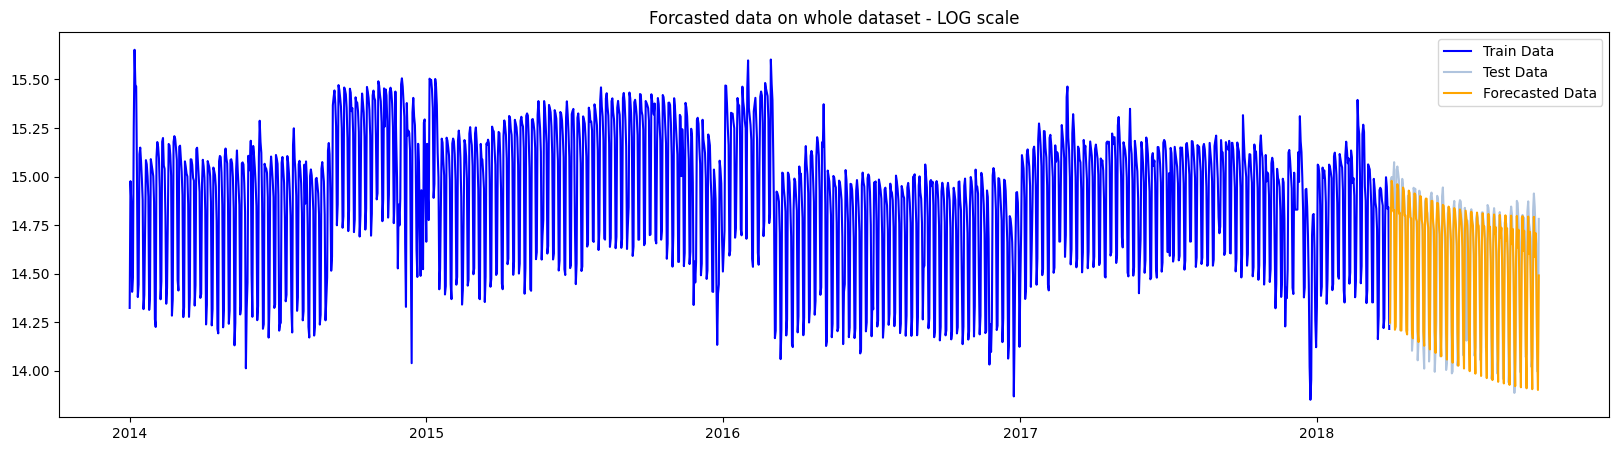

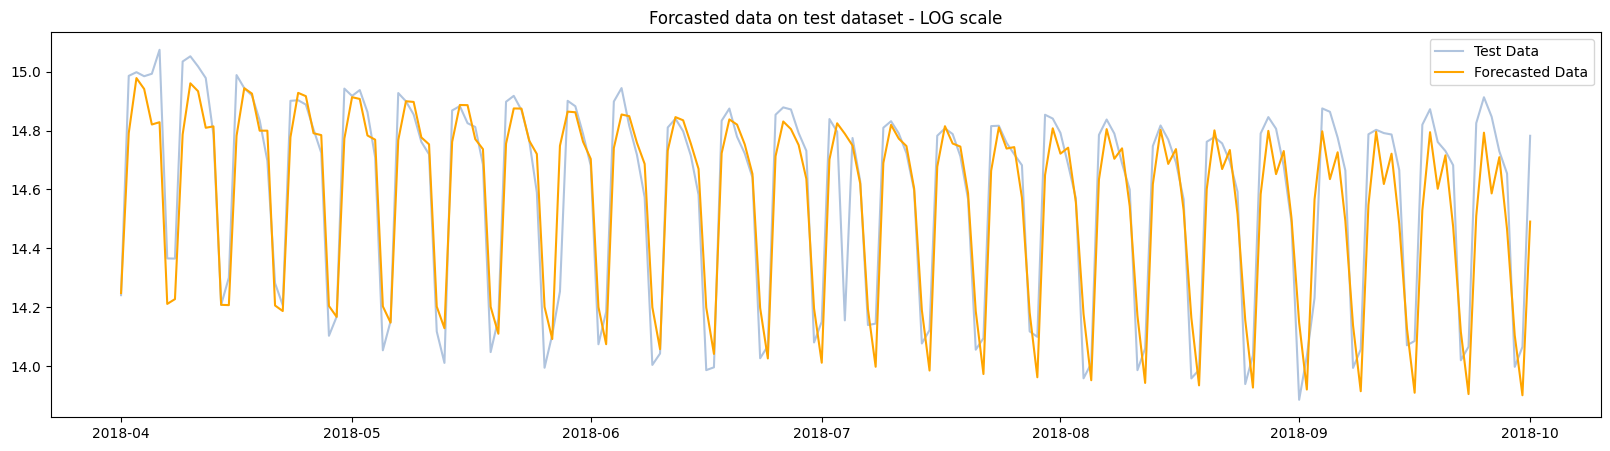

In [9]:
# Forcasted data in LOG scale

Train = train_total['Sessions']
Test = test_total['Sessions']
Forecast = results

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset - LOG scale')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset - LOG scale')
plt.legend()
plt.show()

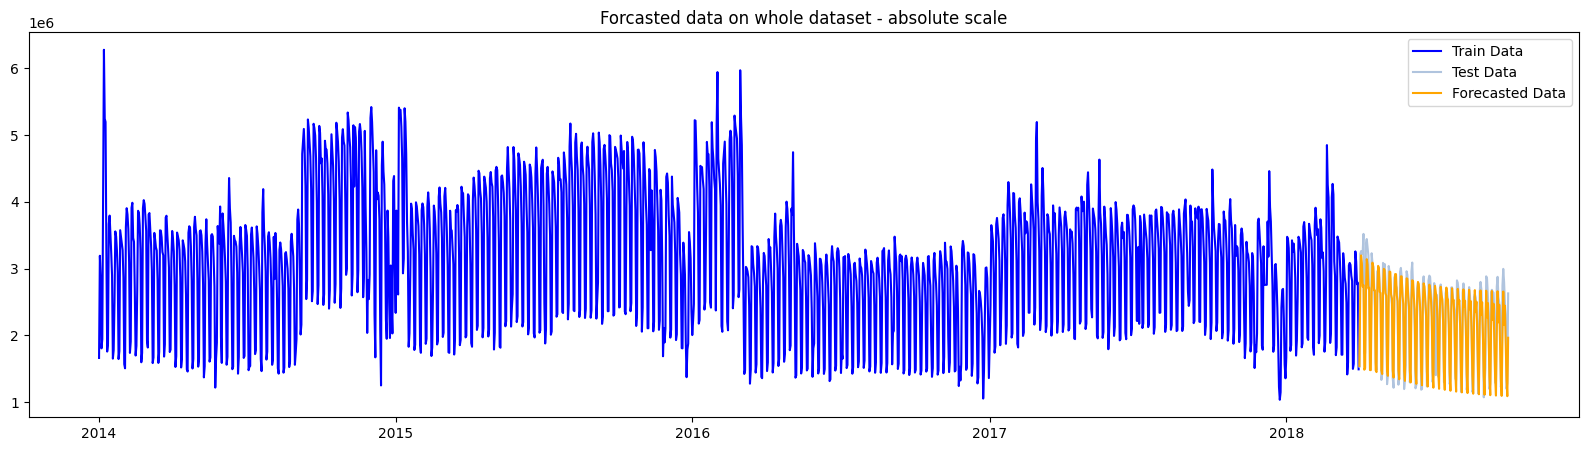

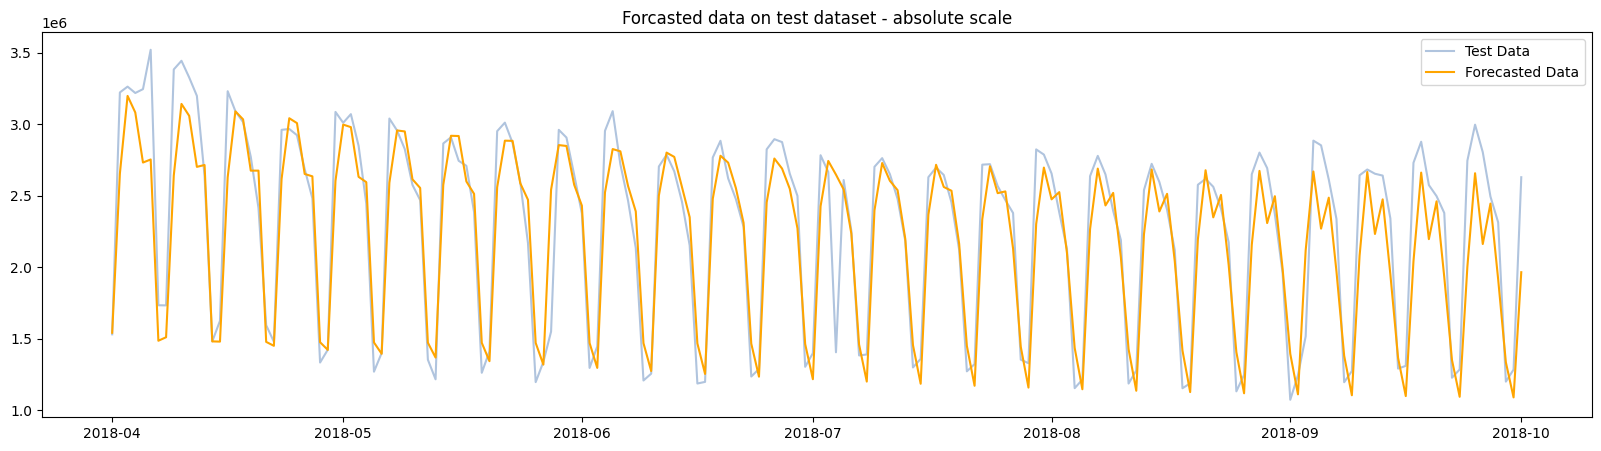

In [10]:
# Forcasted data in absolute scale

Train = np.exp(train_total['Sessions'])
Test = np.exp(test_total['Sessions'])
Forecast = np.exp(results)

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset - absolute scale')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset - absolute scale')
plt.legend()
plt.show()

#
---
## Time Series Forecasting with SARIMA

In [11]:
best_mape = float('inf')
best_order = None

for order in pdq:
    p, d, q = order

    model_SARIMA = SARIMAX(train_total['Sessions'], 
                    exog=None,
                    order=(p, d, q),
                    seasonal_order=(0, 0, 0, 7),
                    trend=None,
                    enforce_stationarity=True,
                    enforce_invertibility=False, 
                    freq='1D')
    
    results = model_SARIMA.fit()
    results = results.forecast(steps=len(test_total))
   
    mape = mean_absolute_percentage_error(test_total['Sessions'], results)
    print(f'(p, d, q) order: {order}, with MAPE = {round(mape*100, 2)}%')

    if mape < best_mape:
        best_mape = mape
        best_order = order
        
print('-------------------------------------------------')
print('Best model:')
print(f'(p, d, q) -> {best_order} with MAPE = {round(best_mape*100, 2)}%')


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12082D+00    |proj g|=  4.50306D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   4.503D-08   4.121D+00
  F =   4.1208203739841727     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p, d, q) order: (0, 0, 0), with MAPE = 100.0%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are ex

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     44      1     0     0   3.998D-04   2.848D+00
  F =   2.8475342631829124     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (0, 0, 2), with MAPE = 99.49%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91429D+00    |proj g|=  4.49055D-01

At iterate    5    f=  3.09713D+00    |proj g|=  2.90821D-01
  ys=-1.757E+00  -gs= 8.733E-01 BFGS update SKIPPED


 This problem is unconstrained.



At iterate   10    f=  2.72290D+00    |proj g|=  8.03386D-01

At iterate   15    f=  2.54666D+00    |proj g|=  7.84981D-02

At iterate   20    f=  2.53210D+00    |proj g|=  1.04544D-01

At iterate   25    f=  2.36096D+00    |proj g|=  1.17863D+00

At iterate   30    f=  2.29615D+00    |proj g|=  2.59204D-01

At iterate   35    f=  2.29206D+00    |proj g|=  2.88834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     74      1     1     0   1.029D-03   2.292D+00
  F =   2.2920621824704694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (0, 0, 3), with MAPE = 99.38%
RUNN

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     24      1     0     0   8.621D-07   9.782D-02
  F =   9.7822177342663269E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p, d, q) order: (0, 1, 2), with MAPE = 1.88%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16887D-01    |proj g|=  6.15400D-01

At iterate    5    f=  1.18586D-01    |proj g|=  4.68441D-01

At iterate   10    f=  9.61809D-02    |proj g|=  1.34343D-02


 This problem is unconstrained.



At iterate   15    f=  9.55851D-02    |proj g|=  2.00238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   6.825D-06   9.558D-02
  F =   9.5584846183800268E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p, d, q) order: (0, 1, 3), with MAPE = 1.88%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40666D-01    |proj g|=  2.76137D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


(p, d, q) order: (0, 2, 1), with MAPE = 3.06%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70545D-01    |proj g|=  4.33210D-01

At iterate    5    f=  3.43883D-01    |proj g|=  1.73473D-01

At iterate   10    f=  3.30374D-01    |proj g|=  9.04934D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     23      1     0     0   1.164D-04   3.304D-01
  F =  0.33036859411677294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (0, 2, 

 This problem is unconstrained.



At iterate   15    f=  1.04115D-01    |proj g|=  2.04177D-01

At iterate   20    f=  1.02696D-01    |proj g|=  8.02473D-01

At iterate   25    f=  1.02469D-01    |proj g|=  2.63779D-01

At iterate   30    f=  1.02352D-01    |proj g|=  2.04222D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     70      1     0     0   1.263D-01   1.024D-01
  F =  0.10235193746719569     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (0, 2, 3), with MAPE = 1.87%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08576D+00    |proj g|=  2.67832D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  3.54549D-01    |proj g|=  1.05547D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     97      1     1     0   1.055D+00   3.545D-01
  F =  0.35454859675091116     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (0, 3, 2), with MAPE = 78.78%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20651D+00    |proj g|=  1.18741D+00

At iterate    5    f=  4.30237D-01    |proj g|=  4.41118D-01

At iterate   10    f= 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      5      1     0     0   6.407D-06   3.485D-01
  F =  0.34850878334010188     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p, d, q) order: (1, 0, 0), with MAPE = 4.86%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37229D-01    |proj g|=  6.66731D-02

At iterate    5    f=  3.30592D-01    |proj g|=  4.49099D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


(p, d, q) order: (1, 1, 1), with MAPE = 3.41%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.06493D-01    |proj g|=  1.71647D+00

At iterate    5    f=  4.74809D-01    |proj g|=  7.02724D-01

At iterate   10    f=  3.57968D-01    |proj g|=  2.75848D+00

At iterate   15    f=  2.82574D-01    |proj g|=  1.52859D-01

At iterate   20    f=  2.37383D-01    |proj g|=  8.51347D-01

At iterate   25    f=  9.76379D-02    |proj g|=  1.11889D-01

At iterate   30    f=  9.65392D-02    |proj g|=  5.13533D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

         

 This problem is unconstrained.



At iterate    5    f=  1.46324D-01    |proj g|=  1.86181D-01

At iterate   10    f=  9.71709D-02    |proj g|=  1.24920D-01

At iterate   15    f=  9.59217D-02    |proj g|=  6.95333D-02

At iterate   20    f=  8.78812D-02    |proj g|=  3.61920D-01

At iterate   25    f=  7.74447D-02    |proj g|=  2.94730D-02

At iterate   30    f=  7.65922D-02    |proj g|=  1.00752D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  7.65837D-02    |proj g|=  5.40958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     68      2     0     0   5.410D-05   7.658D-02
  F =   7.6583709970104732E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (1, 1, 3), with MAPE = 1.86%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15455D-01    |proj g|=  2.48914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function

 This problem is unconstrained.



At iterate   15    f=  3.01009D-01    |proj g|=  1.06544D-01

At iterate   20    f=  3.00704D-01    |proj g|=  3.74687D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   3.747D-05   3.007D-01
  F =  0.30070363886925616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (1, 2, 2), with MAPE = 3.44%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58807D-01    |proj g|=  1.49126D+00


 This problem is unconstrained.



At iterate    5    f=  3.00407D-01    |proj g|=  3.33000D-01

At iterate   10    f=  2.01105D-01    |proj g|=  1.71532D+00

At iterate   15    f=  1.07288D-01    |proj g|=  4.90866D+00

At iterate   20    f=  1.01930D-01    |proj g|=  1.25299D+00

At iterate   25    f=  1.01871D-01    |proj g|=  2.38085D-02

At iterate   30    f=  1.01807D-01    |proj g|=  8.73925D-01

At iterate   35    f=  1.01186D-01    |proj g|=  1.47296D+00

At iterate   40    f=  1.01090D-01    |proj g|=  5.18183D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     63      1     0     0   6.139D-03   1.011D-01
  F =  0.101089593934

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.17890D-01    |proj g|=  6.18422D-02

At iterate   15    f=  6.17875D-01    |proj g|=  1.38478D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     24      1     0     0   1.385D-05   6.179D-01
  F =  0.61787501830786540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (1, 3, 1), with MAPE = 353.44%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.80058D-01    |proj g|=  5.33455D-01

At iterate    5    f=

 This problem is unconstrained.


  ys=-2.533E-01  -gs= 2.338E-02 BFGS update SKIPPED

At iterate   15    f=  3.77771D-01    |proj g|=  1.02542D+00

At iterate   20    f=  3.49526D-01    |proj g|=  2.27931D+00

At iterate   25    f=  3.49443D-01    |proj g|=  5.34132D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     78      1     1     0   5.341D-01   3.494D-01
  F =  0.34944348564268801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (1, 3, 2), with MAPE = 72.51%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variabl

 This problem is unconstrained.



At iterate    5    f=  4.03730D-01    |proj g|=  5.11789D-01

At iterate   10    f=  3.08335D-01    |proj g|=  5.03395D-01

At iterate   15    f=  3.06564D-01    |proj g|=  2.75211D-01

At iterate   20    f=  3.06412D-01    |proj g|=  6.55014D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.06186D-01    |proj g|=  9.27534D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     69      1     0     0   9.275D-02   3.062D-01
  F =  0.30618631673245222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (1, 3, 3), with MAPE = 5.35%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43873D-01    |proj g|=  5.07412D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function

 This problem is unconstrained.



At iterate   25    f=  3.73418D-01    |proj g|=  2.25866D-02

At iterate   30    f=  3.67771D-01    |proj g|=  4.36736D-01

At iterate   35    f=  3.62654D-01    |proj g|=  1.12117D-02

At iterate   40    f=  3.59296D-01    |proj g|=  7.11720D-02

At iterate   45    f=  3.57375D-01    |proj g|=  1.51381D-01

At iterate   50    f=  3.56132D-01    |proj g|=  9.30734D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   9.307D-01   3.561D-01
  F =  0.35613242946405854     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
(p, d, q) order: (2, 0, 2), with MAPE = 2.93%
RUNNI

 This problem is unconstrained.



At iterate   10    f=  1.54828D-01    |proj g|=  1.74404D-01

At iterate   15    f=  1.33058D-01    |proj g|=  1.48030D-01

At iterate   20    f=  1.30249D-01    |proj g|=  1.61610D-02

At iterate   25    f=  1.30230D-01    |proj g|=  1.04621D-03

At iterate   30    f=  1.30204D-01    |proj g|=  1.63288D-02

At iterate   35    f=  1.30100D-01    |proj g|=  2.78670D-03

At iterate   40    f=  1.29993D-01    |proj g|=  1.19597D-02

At iterate   45    f=  1.26404D-01    |proj g|=  1.80056D-01

At iterate   50    f=  9.88756D-02    |proj g|=  1.95217D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64   

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.236E-01  -gs= 7.773E-02 BFGS update SKIPPED

At iterate    5    f=  1.02438D-01    |proj g|=  4.73531D-01

At iterate   10    f=  5.57200D-02    |proj g|=  2.66107D-03

At iterate   15    f=  5.57167D-02    |proj g|=  1.48093D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     36      1     1     0   1.493D-04   5.572D-02
  F =   5.5716664948444475E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (2, 1, 1), with MAPE = 1.85%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variable


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  2.11836D-01    |proj g|=  6.64267D-01

At iterate   15    f=  7.16920D-02    |proj g|=  1.88457D-01

At iterate   20    f=  6.35869D-02    |proj g|=  3.05489D-02

At iterate   25    f=  4.77476D-02    |proj g|=  6.82439D-01

At iterate   30    f=  7.73018D-03    |proj g|=  1.00901D-01

At iterate   35    f=  6.16595D-03    |proj g|=  2.75955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     57      1     0     0   1.338D-04   6.115D-03
  F =   6.1148291098282364E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (2, 1, 2), with MAPE = 1.85%
RUNNI

 This problem is unconstrained.



At iterate    5    f=  1.68814D-01    |proj g|=  3.21343D-01

At iterate   10    f=  6.04805D-02    |proj g|=  9.22697D-01

At iterate   15    f=  1.00191D-03    |proj g|=  1.03692D-01

At iterate   20    f= -7.61169D-03    |proj g|=  4.33189D-02

At iterate   25    f= -1.06234D-02    |proj g|=  1.60879D-01

At iterate   30    f= -8.45242D-02    |proj g|=  7.74060D-01

At iterate   35    f= -1.34890D-01    |proj g|=  4.46796D-01

At iterate   40    f= -1.71095D-01    |proj g|=  2.57284D-01

At iterate   45    f= -1.85593D-01    |proj g|=  5.29675D-01

At iterate   50    f= -1.90641D-01    |proj g|=  2.53953D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.16669D-01    |proj g|=  7.52570D-01

At iterate   10    f=  2.48884D-01    |proj g|=  9.18137D-02

At iterate   15    f=  2.48269D-01    |proj g|=  2.23239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     42      1     1     0   5.107D-05   2.483D-01
  F =  0.24826860096309256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (2, 2, 1), with MAPE = 2.67%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  2.95575D-01    |proj g|=  2.99244D-01

At iterate   10    f=  2.85464D-01    |proj g|=  3.36562D-02

At iterate   15    f=  2.78214D-01    |proj g|=  3.37535D-01

At iterate   20    f=  1.81731D-01    |proj g|=  2.17174D+00

At iterate   25    f=  6.38296D-02    |proj g|=  5.28326D+00

At iterate   30    f=  6.04096D-02    |proj g|=  4.21934D-01

At iterate   35    f=  6.00872D-02    |proj g|=  1.81326D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     99      2     0     0   1.813D-02   6.009D-02
  F =   6.0087203258332222E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              
(p, d, q) order: (2, 2, 2), with MAPE = 1.85%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08611D-01    |proj g|=  1.39988D+00

At iterate    5    f=  3.61378D-01    |proj g|=  2.64164D-01


 This problem is unconstrained.


  ys=-3.186E-02  -gs= 5.630E-02 BFGS update SKIPPED

At iterate   10    f=  2.80447D-01    |proj g|=  3.20023D-01

At iterate   15    f=  2.55706D-01    |proj g|=  2.63499D-01

At iterate   20    f=  2.22004D-01    |proj g|=  2.37923D-01

At iterate   25    f=  1.99241D-01    |proj g|=  2.86994D-01

At iterate   30    f=  1.45926D-01    |proj g|=  2.37484D-01

At iterate   35    f=  1.35233D-01    |proj g|=  1.49871D-01

At iterate   40    f=  1.27766D-01    |proj g|=  2.64346D-02

At iterate   45    f=  1.25578D-01    |proj g|=  1.42663D-01

At iterate   50    f=  1.24140D-01    |proj g|=  1.81929D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.91611D-01    |proj g|=  2.09614D-02

At iterate   15    f=  4.91246D-01    |proj g|=  3.14560D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     38      1     0     0   3.146D-04   4.912D-01
  F =  0.49124607380369661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (2, 3, 1), with MAPE = 257.09%



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75000D-01    |proj g|=  2.82676D-01

At iterate    5    f=  5.12388D-01    |proj g|=  1.39941D-01

At iterate   10    f=  5.07875D-01    |proj g|=  1.33087D-01

At iterate   15    f=  3.47533D-01    |proj g|=  1.11586D+01
  ys=-8.772E-02  -gs= 6.388E-02 BFGS update SKIPPED

At iterate   20    f=  2.58875D-01    |proj g|=  2.99372D+00

At iterate   25    f=  2.57149D-01    |proj g|=  6.34951D-02

At iterate   30    f=  2.57128D-01    |proj g|=  1.42914D-02

At iterate   35    f=  2.56972D-01    |proj g|=  1.57223D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

 This problem is unconstrained.



At iterate   10    f=  6.31378D-01    |proj g|=  3.92634D-01

At iterate   15    f=  4.41453D-01    |proj g|=  5.35114D-01

At iterate   20    f=  3.76754D-01    |proj g|=  1.69204D-01

At iterate   25    f=  3.71002D-01    |proj g|=  1.53514D-01

At iterate   30    f=  3.44577D-01    |proj g|=  1.26925D+00

At iterate   35    f=  3.24956D-01    |proj g|=  6.49379D-01

At iterate   40    f=  3.18956D-01    |proj g|=  1.87724D-01

At iterate   45    f=  3.07836D-01    |proj g|=  1.63512D+00

At iterate   50    f=  3.04609D-01    |proj g|=  5.39827D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.64154D-01    |proj g|=  1.55822D-01

At iterate   10    f=  1.37500D-01    |proj g|=  3.29466D-01

At iterate   15    f=  1.22060D-01    |proj g|=  3.74983D-03

At iterate   20    f=  1.21827D-01    |proj g|=  4.64976D-02

At iterate   25    f=  1.02015D-01    |proj g|=  3.09002D-01

At iterate   30    f=  7.41046D-02    |proj g|=  1.89485D-01

At iterate   35    f=  6.20468D-02    |proj g|=  9.28225D-02

At iterate   40    f=  5.85952D-02    |proj g|=  2.27101D-02

At iterate   45    f=  5.83693D-02    |proj g|=  7.75269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     63   

 This problem is unconstrained.



At iterate   10    f=  1.51545D+00    |proj g|=  9.70784D-01

At iterate   15    f=  7.94393D-01    |proj g|=  5.38820D-01

At iterate   20    f=  7.17081D-01    |proj g|=  1.29020D+00

At iterate   25    f=  6.44134D-01    |proj g|=  3.75847D-01

At iterate   30    f=  3.39153D-01    |proj g|=  3.06648D-01

At iterate   35    f=  2.65813D-01    |proj g|=  4.73193D-01

At iterate   40    f=  2.59517D-01    |proj g|=  7.94774D-02

At iterate   45    f=  2.51236D-01    |proj g|=  9.64356D-01

At iterate   50    f=  2.49302D-01    |proj g|=  7.74214D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     78   

 This problem is unconstrained.



At iterate   15    f=  2.47202D-03    |proj g|=  2.72535D-01

At iterate   20    f= -8.64740D-02    |proj g|=  1.33794D-01

At iterate   25    f= -1.24531D-01    |proj g|=  5.19685D-01

At iterate   30    f= -1.66239D-01    |proj g|=  2.98190D-01

At iterate   35    f= -1.81924D-01    |proj g|=  3.15992D-01

At iterate   40    f= -1.86666D-01    |proj g|=  1.18292D-01

At iterate   45    f= -1.89629D-01    |proj g|=  6.07738D-01

At iterate   50    f= -1.90356D-01    |proj g|=  1.99781D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   1.998D-01  -1.904D-01
  F = -0.190356120925

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.50122D-02    |proj g|=  4.35780D-01

At iterate   15    f=  5.10925D-02    |proj g|=  1.73500D-02

At iterate   20    f=  5.09003D-02    |proj g|=  2.07136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     32      1     1     0   1.017D-05   5.090D-02
  F =   5.0900315018906094E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (3, 1, 1), with MAPE = 1.85%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  

 This problem is unconstrained.



At iterate   15    f=  9.91025D-02    |proj g|=  1.81008D-01

At iterate   20    f=  5.35429D-02    |proj g|=  2.49147D-02

At iterate   25    f=  5.31240D-02    |proj g|=  2.85177D-02

At iterate   30    f=  5.13786D-02    |proj g|=  1.53787D-01

At iterate   35    f=  4.74426D-02    |proj g|=  3.58598D-03

At iterate   40    f=  4.74365D-02    |proj g|=  2.60729D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     60      1     0     0   2.607D-05   4.744D-02
  F =   4.7436525845998001E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (3, 1, 2), with MAPE = 1.85%
RUNNI

 This problem is unconstrained.



At iterate    5    f=  1.52261D-01    |proj g|=  1.97601D-01

At iterate   10    f=  8.45145D-02    |proj g|=  1.77544D-01

At iterate   15    f= -7.26513D-03    |proj g|=  4.31114D-01

At iterate   20    f= -3.43278D-02    |proj g|=  2.62504D-01

At iterate   25    f= -1.09670D-01    |proj g|=  1.62082D-01

At iterate   30    f= -1.46002D-01    |proj g|=  3.89514D-01

At iterate   35    f= -1.58615D-01    |proj g|=  5.15099D-02

At iterate   40    f= -1.60821D-01    |proj g|=  1.06216D-01

At iterate   45    f= -1.77076D-01    |proj g|=  2.32279D-01

At iterate   50    f= -1.86225D-01    |proj g|=  2.96347D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.043E-01  -gs= 7.179E-02 BFGS update SKIPPED

At iterate    5    f=  3.04026D-01    |proj g|=  4.56002D-01

At iterate   10    f=  2.54801D-01    |proj g|=  2.06478D-01

At iterate   15    f=  2.43387D-01    |proj g|=  2.71891D-01

At iterate   20    f=  2.42908D-01    |proj g|=  8.47748D-04

At iterate   25    f=  2.42908D-01    |proj g|=  4.12763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     46      1     1     0   1.315D-04   2.429D-01
  F =  0.24290742841130947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (3, 2, 1), with MAPE = 2.52%
RUNNING THE L-B

 This problem is unconstrained.



At iterate    5    f=  3.56022D-01    |proj g|=  6.33940D-01

At iterate   10    f=  2.52900D-01    |proj g|=  2.95264D-01

At iterate   15    f=  2.45912D-01    |proj g|=  6.43723D-02

At iterate   20    f=  2.45514D-01    |proj g|=  1.03755D-01

At iterate   25    f=  1.22826D-01    |proj g|=  9.93671D-01

At iterate   30    f=  1.00404D-01    |proj g|=  4.19254D-01

At iterate   35    f=  9.84720D-02    |proj g|=  2.59483D-01

At iterate   40    f=  9.36538D-02    |proj g|=  2.95550D+00

At iterate   45    f=  6.68215D-02    |proj g|=  2.43364D+00

At iterate   50    f=  5.53385D-02    |proj g|=  1.61269D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.00124D-01    |proj g|=  5.97867D-01
  ys=-2.777E-02  -gs= 5.381E-02 BFGS update SKIPPED

At iterate   10    f=  2.56238D-01    |proj g|=  3.31540D-01

At iterate   15    f=  2.46442D-01    |proj g|=  2.97360D-01

At iterate   20    f=  1.89857D-01    |proj g|=  2.85310D-01

At iterate   25    f=  1.75093D-01    |proj g|=  1.21268D-01

At iterate   30    f=  1.69281D-01    |proj g|=  1.86431D-01

At iterate   35    f=  1.48173D-01    |proj g|=  2.63091D-01

At iterate   40    f=  1.16827D-01    |proj g|=  4.79233D-01

At iterate   45    f=  1.10325D-01    |proj g|=  2.03651D-01

At iterate   50    f=  9.52515D-02    |proj g|=  8.28074D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.89506D-01    |proj g|=  3.03444D-01

At iterate   10    f=  4.79292D-01    |proj g|=  2.42160D-02

At iterate   15    f=  4.79239D-01    |proj g|=  2.45556D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     28      1     0     0   3.160D-05   4.792D-01
  F =  0.47923872910585941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (3, 3, 1), with MAPE = 226.73%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=

 This problem is unconstrained.



At iterate   15    f=  4.86808D-01    |proj g|=  1.39563D-02

At iterate   20    f=  4.86345D-01    |proj g|=  1.61220D-02

At iterate   25    f=  4.84380D-01    |proj g|=  7.24800D-02

At iterate   30    f=  4.81339D-01    |proj g|=  5.80843D-02

At iterate   35    f=  4.80431D-01    |proj g|=  9.27620D-02

At iterate   40    f=  4.80251D-01    |proj g|=  9.20663D-03

At iterate   45    f=  4.80225D-01    |proj g|=  2.00375D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     71      1     0     0   4.448D-03   4.802D-01
  F =  0.48022407513546983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84138D-01    |proj g|=  1.55731D+00

At iterate    5    f=  6.11127D-01    |proj g|=  2.01342D-01

At iterate   10    f=  5.66482D-01    |proj g|=  2.86983D-01

At iterate   15    f=  4.31904D-01    |proj g|=  1.07914D+00

At iterate   20    f=  3.79010D-01    |proj g|=  1.92206D-01

At iterate   25    f=  3.67514D-01    |proj g|=  6.37686D-01

At iterate   30    f=  3.60472D-01    |proj g|=  3.22491D-02

At iterate   35    f=  3.56226D-01    |proj g|=  6.78753D-02

At iterate   40    f=  3.21702D-01    |proj g|=  1.02452D+00

At iterate   45    f=  3.04751D-01    |proj g|=  4.61810D-01

At iterate   50    f=  2.98240D-01    |proj g|=  2.60474D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.48129D-01    |proj g|=  2.64628D-03

At iterate   15    f=  2.47700D-01    |proj g|=  5.81020D-02

At iterate   20    f=  2.11648D-01    |proj g|=  3.53533D-01

At iterate   25    f=  1.04801D-01    |proj g|=  2.49301D-02

At iterate   30    f=  1.03716D-01    |proj g|=  2.32778D-03

At iterate   35    f=  1.03556D-01    |proj g|=  5.17368D-02

At iterate   40    f=  9.30540D-02    |proj g|=  3.40610D-01

At iterate   45    f=  6.44068D-02    |proj g|=  1.82606D-01

At iterate   50    f=  5.55324D-02    |proj g|=  2.53633D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64   

 This problem is unconstrained.



At iterate    5    f=  2.32005D+00    |proj g|=  5.44737D+00

At iterate   10    f=  1.29565D+00    |proj g|=  8.78343D-01

At iterate   15    f=  4.38299D-01    |proj g|=  5.27649D-02

At iterate   20    f=  4.32492D-01    |proj g|=  1.39783D-01

At iterate   25    f=  4.32134D-01    |proj g|=  5.75731D-01

At iterate   30    f=  4.19813D-01    |proj g|=  1.93205D+00

At iterate   35    f=  4.07498D-01    |proj g|=  4.40003D-02

At iterate   40    f=  4.07251D-01    |proj g|=  6.63594D-01

At iterate   45    f=  4.00641D-01    |proj g|=  4.63486D+00

At iterate   50    f=  3.77329D-01    |proj g|=  1.87995D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.91822D-04    |proj g|=  9.85390D-02

At iterate   15    f= -8.58151D-03    |proj g|=  1.26748D-02

At iterate   20    f= -9.09638D-03    |proj g|=  2.51805D-02

At iterate   25    f= -1.30517D-02    |proj g|=  1.90977D-01

At iterate   30    f= -1.97092D-02    |proj g|=  3.91482D-02

At iterate   35    f= -2.39329D-02    |proj g|=  5.15900D-02

At iterate   40    f= -2.46442D-02    |proj g|=  7.36484D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     51      1     0     0   7.259D-05  -2.464D-02
  F =  -2.4644229547606672E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   2.544D-06   1.578D-01
  F =  0.15782581234003407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p, d, q) order: (4, 1, 0), with MAPE = 2.11%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70239D-01    |proj g|=  2.61277D-01

At iterate    5    f= -1.66953D-02    |proj g|=  4.42156D-01

At iterate   10    f= -7.59834D-02    |proj g|=  6.96923D-02

At iterate   15    f= -

 This problem is unconstrained.



At iterate    5    f=  1.92487D-01    |proj g|=  3.23246D+00

At iterate   10    f=  1.63966D-01    |proj g|=  4.33241D-01

At iterate   15    f=  1.56021D-01    |proj g|=  2.65125D-01

At iterate   20    f=  1.18708D-01    |proj g|=  2.60661D+00

At iterate   25    f=  3.68454D-02    |proj g|=  9.69276D-02

At iterate   30    f= -1.30969D-02    |proj g|=  2.11986D-01

At iterate   35    f= -7.16355D-02    |proj g|=  3.92168D-01

At iterate   40    f= -1.22067D-01    |proj g|=  3.44849D-01

At iterate   45    f= -1.24223D-01    |proj g|=  1.71018D-02

At iterate   50    f= -1.25009D-01    |proj g|=  1.91162D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.48905D-01    |proj g|=  2.92510D-01

At iterate   10    f= -3.01471D-01    |proj g|=  1.61971D-01

At iterate   15    f= -3.12089D-01    |proj g|=  1.06234D-01

At iterate   20    f= -3.20434D-01    |proj g|=  6.22705D-02

At iterate   25    f= -3.30060D-01    |proj g|=  1.42408D-01

At iterate   30    f= -3.36735D-01    |proj g|=  2.27078D-01

At iterate   35    f= -3.40498D-01    |proj g|=  1.16751D-01

At iterate   40    f= -3.42354D-01    |proj g|=  1.13262D-01

At iterate   45    f= -3.49322D-01    |proj g|=  3.80012D-01

At iterate   50    f= -3.54969D-01    |proj g|=  8.52789D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.22034D-01    |proj g|=  1.01475D+00

At iterate   10    f=  1.62114D-01    |proj g|=  1.41280D-01

At iterate   15    f=  1.60891D-01    |proj g|=  3.76299D-02

At iterate   20    f=  1.60852D-01    |proj g|=  1.93832D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     32      1     0     0   5.956D-05   1.609D-01
  F =  0.16085017494356241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (4, 2, 1), with MAPE = 2.11%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         

 This problem is unconstrained.



At iterate    5    f=  2.98575D-01    |proj g|=  1.02188D+01

At iterate   10    f=  2.60158D-01    |proj g|=  4.73052D-01

At iterate   15    f=  2.41967D-01    |proj g|=  2.78384D+00

At iterate   20    f=  2.34930D-01    |proj g|=  4.33584D-01

At iterate   25    f=  2.10708D-01    |proj g|=  7.82685D-01

At iterate   30    f=  1.92121D-01    |proj g|=  8.79743D-02

At iterate   35    f=  1.91841D-01    |proj g|=  4.65658D-01

At iterate   40    f=  1.91505D-01    |proj g|=  1.17118D-01

At iterate   45    f=  1.91498D-01    |proj g|=  1.04492D-02

At iterate   50    f=  1.91493D-01    |proj g|=  2.94110D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.53884D-01    |proj g|=  4.82924D-01
  ys=-3.375E-02  -gs= 5.407E-02 BFGS update SKIPPED

At iterate   10    f=  2.32799D-01    |proj g|=  3.90928D-01

At iterate   15    f=  2.04271D-01    |proj g|=  2.23346D-01

At iterate   20    f= -3.96305D-02    |proj g|=  7.52355D-01

At iterate   25    f= -1.33099D-01    |proj g|=  6.72628D-01

At iterate   30    f= -1.37219D-01    |proj g|=  1.08941D-01

At iterate   35    f= -1.92969D-01    |proj g|=  6.54074D-01

At iterate   40    f= -2.00633D-01    |proj g|=  4.97054D-01

At iterate   45    f= -2.25929D-01    |proj g|=  4.64551D-01

At iterate   50    f= -2.37881D-01    |proj g|=  2.72934D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.85693D-01    |proj g|=  3.21519D-01

At iterate   10    f=  4.73841D-01    |proj g|=  2.12967D-02

At iterate   15    f=  4.73810D-01    |proj g|=  2.06486D-03

At iterate   20    f=  4.73810D-01    |proj g|=  2.92234D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     24      1     0     0   2.922D-05   4.738D-01
  F =  0.47381022870080430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (4, 3, 1), with MAPE = 202.48%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0       

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4     32      1     0     0   8.581D+00   1.074D+00
  F =   1.0736329527528687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (4, 3, 2), with MAPE = 24598.05%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25610D-01    |proj g|=  1.60957D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  6.30483D-01    |proj g|=  5.22537D-01

At iterate   10    f=  5.95673D-01    |proj g|=  2.59240D-01

At iterate   15    f=  5.47705D-01    |proj g|=  2.16943D-01

At iterate   20    f=  4.78549D-01    |proj g|=  1.05158D+00

At iterate   25    f=  3.92066D-01    |proj g|=  7.03810D-01

At iterate   30    f=  3.55406D-01    |proj g|=  2.97981D-01

At iterate   35    f=  3.48533D-01    |proj g|=  3.52970D-02

At iterate   40    f=  3.45799D-01    |proj g|=  2.49348D-02

At iterate   45    f=  3.33409D-01    |proj g|=  4.08583D-01

At iterate   50    f=  3.19341D-01    |proj g|=  1.46263D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46328D-01    |proj g|=  1.32968D+00

At iterate    5    f=  2.52413D-01    |proj g|=  2.79354D-01

At iterate   10    f=  1.47566D-01    |proj g|=  8.02415D-01

At iterate   15    f= -1.83883D-02    |proj g|=  4.26142D-01

At iterate   20    f= -5.00069D-02    |proj g|=  2.42574D-02

At iterate   25    f= -5.05743D-02    |proj g|=  1.83364D-02

At iterate   30    f= -5.06150D-02    |proj g|=  9.07154D-03

At iterate   35    f= -5.35887D-02    |proj g|=  2.15280D-01

At iterate   40    f= -6.84673D-02    |proj g|=  1.17014D-01

At iterate   45    f= -7.23340D-02    |proj g|=  3.09976D-02

At iterate   50    f= -7.36642D-02    |proj g|=  1.05003D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.05018D+00    |proj g|=  3.82441D-01

At iterate   10    f=  6.49114D-01    |proj g|=  7.84305D-01

At iterate   15    f=  4.50867D-01    |proj g|=  2.95778D+00

At iterate   20    f=  3.40537D-01    |proj g|=  5.23198D-01

At iterate   25    f=  2.92574D-01    |proj g|=  2.77307D-01

At iterate   30    f=  2.40870D-01    |proj g|=  1.14903D+00

At iterate   35    f=  2.27614D-01    |proj g|=  5.29837D-02

At iterate   40    f=  2.23726D-01    |proj g|=  2.55026D-02

At iterate   45    f=  2.23357D-01    |proj g|=  6.55362D-02

At iterate   50    f=  2.22398D-01    |proj g|=  2.31326D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.40348D-01    |proj g|=  4.14322D-01

At iterate   10    f= -3.08407D-01    |proj g|=  1.69452D-01

At iterate   15    f= -3.21303D-01    |proj g|=  4.60804D-02

At iterate   20    f= -3.31363D-01    |proj g|=  5.62717D-02

At iterate   25    f= -3.37321D-01    |proj g|=  6.47573D-02

At iterate   30    f= -3.41339D-01    |proj g|=  2.18309D-01

At iterate   35    f= -3.48426D-01    |proj g|=  2.01123D-01

At iterate   40    f= -3.52500D-01    |proj g|=  2.89429D-01

At iterate   45    f= -3.53157D-01    |proj g|=  2.58085D-02

At iterate   50    f= -3.53444D-01    |proj g|=  2.36353D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -1.74608D-01    |proj g|=  9.45276D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     55      2     0     0   1.325D-04  -1.746D-01
  F = -0.17460826866210391     

ABNORMAL_TERMINATION_IN_LNSRCH                              
(p, d, q) order: (5, 1, 0), with MAPE = 1.73%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19889D-01    |proj g|=  3.84293D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -2.79535D-01    |proj g|=  1.40671D-01

At iterate   10    f= -2.81184D-01    |proj g|=  8.89623D-02

At iterate   15    f= -2.81849D-01    |proj g|=  7.24698D-03

At iterate   20    f= -2.82092D-01    |proj g|=  4.84209D-02

At iterate   25    f= -2.82181D-01    |proj g|=  3.28892D-04

At iterate   30    f= -2.82181D-01    |proj g|=  1.22647D-04

At iterate   35    f= -2.82181D-01    |proj g|=  4.42367D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     40      1     0     0   4.424D-05  -2.822D-01
  F = -0.28218111625579767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -8.30133D-02    |proj g|=  3.32715D-01

At iterate   10    f= -1.05953D-01    |proj g|=  2.90895D-01

At iterate   15    f= -1.13765D-01    |proj g|=  5.45885D-01

At iterate   20    f= -1.25177D-01    |proj g|=  1.86435D-01

At iterate   25    f= -1.74250D-01    |proj g|=  3.36166D-01

At iterate   30    f= -1.90159D-01    |proj g|=  3.28169D-01

At iterate   35    f= -1.97076D-01    |proj g|=  7.36907D-01

At iterate   40    f= -2.13402D-01    |proj g|=  1.19010D+00

At iterate   45    f= -2.26749D-01    |proj g|=  2.27066D+00

At iterate   50    f= -2.33095D-01    |proj g|=  1.24743D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.82780D-01    |proj g|=  2.24565D-01

At iterate   10    f= -4.05252D-01    |proj g|=  3.32280D-01

At iterate   15    f= -4.19568D-01    |proj g|=  4.45192D-01

At iterate   20    f= -4.21372D-01    |proj g|=  2.03277D-02

At iterate   25    f= -4.21895D-01    |proj g|=  6.13558D-02

At iterate   30    f= -4.23088D-01    |proj g|=  3.88872D-02

At iterate   35    f= -4.24222D-01    |proj g|=  3.76220D-02

At iterate   40    f= -4.25363D-01    |proj g|=  9.52743D-02

At iterate   45    f= -4.25921D-01    |proj g|=  3.14302D-02

At iterate   50    f= -4.27518D-01    |proj g|=  1.27785D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   8.701D-05   2.888D-01
  F =  0.28882259618386252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (5, 2, 0), with MAPE = 66.02%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61925D-01    |proj g|=  7.82253D-01


 This problem is unconstrained.



At iterate    5    f= -3.03647D-02    |proj g|=  1.63069D+00

At iterate   10    f= -1.68621D-01    |proj g|=  1.63972D-01

At iterate   15    f= -1.70460D-01    |proj g|=  1.09410D-01

At iterate   20    f= -1.71024D-01    |proj g|=  8.00216D-04

At iterate   25    f= -1.71027D-01    |proj g|=  3.01294D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     39      1     0     0   5.225D-05  -1.710D-01
  F = -0.17102671959605656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (5, 2, 1), with MAPE = 1.73%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.



At iterate    5    f=  5.06752D-01    |proj g|=  4.09535D+00

At iterate   10    f=  2.53579D-01    |proj g|=  1.95727D+00

At iterate   15    f=  2.32210D-01    |proj g|=  3.23523D+00

At iterate   20    f=  2.07288D-01    |proj g|=  7.71851D-01

At iterate   25    f=  1.78650D-01    |proj g|=  1.64539D+00

At iterate   30    f=  1.57397D-01    |proj g|=  1.36594D+00

At iterate   35    f= -1.86616D-02    |proj g|=  2.82636D+00

At iterate   40    f= -2.41798D-02    |proj g|=  8.47114D-02

At iterate   45    f= -3.28624D-02    |proj g|=  7.72299D-01

At iterate   50    f= -4.71517D-02    |proj g|=  1.39973D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.47702D-01    |proj g|=  3.42166D-01

At iterate   10    f= -2.68413D-01    |proj g|=  7.35820D-01

At iterate   15    f= -3.66855D-01    |proj g|=  5.33057D-01

At iterate   20    f= -3.74552D-01    |proj g|=  8.52075D-02

At iterate   25    f= -3.76223D-01    |proj g|=  1.50899D-01

At iterate   30    f= -3.95989D-01    |proj g|=  3.70628D-01

At iterate   35    f= -3.99554D-01    |proj g|=  8.88718D-02

At iterate   40    f= -4.03937D-01    |proj g|=  1.76888D-01

At iterate   45    f= -4.04548D-01    |proj g|=  3.22933D-02

At iterate   50    f= -4.07132D-01    |proj g|=  3.23174D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77192D-01    |proj g|=  4.27645D-01

At iterate    5    f=  3.13169D-01    |proj g|=  1.60271D-01

At iterate   10    f=  2.94274D-01    |proj g|=  2.45709D-01

At iterate   15    f=  2.92189D-01    |proj g|=  1.14414D-02

At iterate   20    f=  2.92147D-01    |proj g|=  9.72358D-04

At iterate   25    f=  2.92145D-01    |proj g|=  9.44280D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     39      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.50407D-01    |proj g|=  8.23423D+00

At iterate   10    f=  6.94776D-01    |proj g|=  2.58278D+01

At iterate   15    f=  6.77875D-01    |proj g|=  3.61847D-01

At iterate   20    f=  6.74867D-01    |proj g|=  1.19210D+01

At iterate   25    f=  5.60855D-01    |proj g|=  2.78322D+01

At iterate   30    f=  5.19935D-01    |proj g|=  8.66479D-02

At iterate   35    f=  5.19903D-01    |proj g|=  1.45844D+00

At iterate   40    f=  5.17561D-01    |proj g|=  1.30240D+01

At iterate   45    f=  5.12671D-01    |proj g|=  5.57969D-02

At iterate   50    f=  5.12542D-01    |proj g|=  7.75998D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.65154D-01    |proj g|=  2.31924D-01

At iterate   10    f=  6.04253D-01    |proj g|=  7.64099D-02

At iterate   15    f=  5.87834D-01    |proj g|=  5.88386D-01

At iterate   20    f=  5.66342D-01    |proj g|=  2.95931D-01

At iterate   25    f=  4.58098D-01    |proj g|=  7.80345D-01

At iterate   30    f=  4.11405D-01    |proj g|=  8.03992D-01

At iterate   35    f=  3.30538D-01    |proj g|=  2.43439D-01

At iterate   40    f=  3.08882D-01    |proj g|=  7.83632D-01

At iterate   45    f=  2.30635D-01    |proj g|=  6.42113D-01

At iterate   50    f=  1.93276D-01    |proj g|=  3.13216D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.71931D-01    |proj g|=  5.47904D-03

At iterate   10    f= -1.71938D-01    |proj g|=  7.54799D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     17      1     0     0   1.161D-04  -1.719D-01
  F = -0.17193830242210109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (6, 0, 0), with MAPE = 1.75%


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38378D-01    |proj g|=  3.15725D+00

At iterate    5    f= -9.50601D-02    |proj g|=  4.11646D-01

At iterate   10    f= -2.15162D-01    |proj g|=  1.84590D-01

At iterate   15    f= -2.51259D-01    |proj g|=  1.19151D-01

At iterate   20    f= -2.56222D-01    |proj g|=  8.79501D-02

At iterate   25    f= -2.70688D-01    |proj g|=  1.83569D-01

At iterate   30    f= -2.73505D-01    |proj g|=  1.73297D-01

At iterate   35    f= -2.74593D-01    |proj g|=  5.57370D-02

At iterate   40    f= -2.74907D-01    |proj g|=  6.31710D-04

At iterate   45    f= -2.74909D-01    |proj g|=  8.01178D-04

At iterate   50    f= -2.74960D-01    |proj g|=  8.97520D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -8.10798D-02    |proj g|=  4.05620D-01

At iterate   10    f= -2.67940D-01    |proj g|=  2.56421D-01

At iterate   15    f= -3.45145D-01    |proj g|=  4.19567D-01

At iterate   20    f= -3.47914D-01    |proj g|=  4.72004D-02

At iterate   25    f= -3.50164D-01    |proj g|=  2.10654D-02

At iterate   30    f= -3.51289D-01    |proj g|=  1.02513D-01

At iterate   35    f= -3.60171D-01    |proj g|=  1.44908D-01

At iterate   40    f= -3.75686D-01    |proj g|=  2.26604D-01

At iterate   45    f= -3.91960D-01    |proj g|=  1.95638D-01

At iterate   50    f= -3.99311D-01    |proj g|=  1.33390D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.59398D+00    |proj g|=  5.62742D+00

At iterate   10    f=  1.24957D+00    |proj g|=  2.01662D+00

At iterate   15    f=  6.87022D-01    |proj g|=  7.59026D-01

At iterate   20    f=  1.03712D-01    |proj g|=  5.51542D-01

At iterate   25    f=  5.13588D-02    |proj g|=  4.98409D-01

At iterate   30    f= -6.53187D-03    |proj g|=  5.51990D-01

At iterate   35    f= -1.18428D-01    |proj g|=  1.12573D+00

At iterate   40    f= -1.28044D-01    |proj g|=  5.30600D-01

At iterate   45    f= -1.37227D-01    |proj g|=  7.02133D-01

At iterate   50    f= -1.66288D-01    |proj g|=  4.99236D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.37282D-01    |proj g|=  1.45560D-02

At iterate   10    f= -4.37357D-01    |proj g|=  4.97550D-03

At iterate   15    f= -4.37369D-01    |proj g|=  5.18227D-03

At iterate   20    f= -4.37371D-01    |proj g|=  1.16042D-03

At iterate   25    f= -4.37373D-01    |proj g|=  2.16905D-03

At iterate   30    f= -4.37374D-01    |proj g|=  3.02330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     43      1     0     0   5.545D-05  -4.374D-01
  F = -0.43737372801028879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (6, 1, 0), with MAPE = 1.68%
RUNNI

 This problem is unconstrained.



At iterate    5    f= -1.09717D-01    |proj g|=  1.95526D+00

At iterate   10    f= -2.45680D-01    |proj g|=  1.40419D-01

At iterate   15    f= -3.30810D-01    |proj g|=  3.28916D-01

At iterate   20    f= -4.76821D-01    |proj g|=  7.00886D-02

At iterate   25    f= -4.81102D-01    |proj g|=  1.63451D-01

At iterate   30    f= -4.84317D-01    |proj g|=  1.04707D-01

At iterate   35    f= -4.86690D-01    |proj g|=  8.37949D-02

At iterate   40    f= -4.87472D-01    |proj g|=  2.87436D-02

At iterate   45    f= -4.87881D-01    |proj g|=  5.03498D-02

At iterate   50    f= -4.88346D-01    |proj g|=  2.67286D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.77266D-02    |proj g|=  3.79051D-01

At iterate   10    f= -1.85992D-01    |proj g|=  3.04473D-01

At iterate   15    f= -3.31955D-01    |proj g|=  1.11180D+00

At iterate   20    f= -3.71207D-01    |proj g|=  1.03417D-01

At iterate   25    f= -4.29693D-01    |proj g|=  8.13673D-01

At iterate   30    f= -4.32456D-01    |proj g|=  7.72706D-01

At iterate   35    f= -4.35059D-01    |proj g|=  5.06852D-01

At iterate   40    f= -4.35740D-01    |proj g|=  8.00060D-02

At iterate   45    f= -4.36305D-01    |proj g|=  1.03149D-01

At iterate   50    f= -4.42459D-01    |proj g|=  1.54472D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.17879D-01    |proj g|=  3.88774D-01

At iterate   10    f= -5.22611D-01    |proj g|=  4.17865D-02

At iterate   15    f= -5.23409D-01    |proj g|=  6.69684D-03

At iterate   20    f= -5.23768D-01    |proj g|=  9.83136D-02

At iterate   25    f= -5.24122D-01    |proj g|=  8.76073D-03

At iterate   30    f= -5.24206D-01    |proj g|=  7.01099D-03

At iterate   35    f= -5.24216D-01    |proj g|=  1.85997D-03

At iterate   40    f= -5.24228D-01    |proj g|=  6.33316D-03

At iterate   45    f= -5.24238D-01    |proj g|=  9.23833D-04

At iterate   50    f= -5.24238D-01    |proj g|=  4.66812D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -3.78489D-01    |proj g|=  3.18661D-03

At iterate   15    f= -3.78490D-01    |proj g|=  3.31455D-04

At iterate   20    f= -3.78491D-01    |proj g|=  4.47840D-04

At iterate   25    f= -3.78492D-01    |proj g|=  9.85259D-04

At iterate   30    f= -3.78492D-01    |proj g|=  6.05882D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     52      1     0     0   2.498D-04  -3.785D-01
  F = -0.37849167160022729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (6, 2, 0), with MAPE = 3.25%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.



At iterate    5    f=  2.40993D-02    |proj g|=  4.86492D-01

At iterate   10    f= -4.06914D-01    |proj g|=  1.59665D-01

At iterate   15    f= -4.21588D-01    |proj g|=  2.88053D-01

At iterate   20    f= -4.25899D-01    |proj g|=  4.92280D-02

At iterate   25    f= -4.31414D-01    |proj g|=  7.31845D-02

At iterate   30    f= -4.32805D-01    |proj g|=  5.13444D-02

At iterate   35    f= -4.33039D-01    |proj g|=  4.33004D-03

At iterate   40    f= -4.33157D-01    |proj g|=  2.63510D-02

At iterate   45    f= -4.33301D-01    |proj g|=  1.36473D-02

At iterate   50    f= -4.33305D-01    |proj g|=  4.55171D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07465D+00    |proj g|=  1.55821D+01

At iterate    5    f=  1.23789D-01    |proj g|=  1.21196D+00

At iterate   10    f= -3.99135D-01    |proj g|=  6.50588D-01

At iterate   15    f= -4.67108D-01    |proj g|=  4.35918D-01

At iterate   20    f= -4.83188D-01    |proj g|=  1.44884D-01

At iterate   25    f= -4.83671D-01    |proj g|=  4.29847D-02

At iterate   30    f= -4.83783D-01    |proj g|=  8.35136D-03

At iterate   35    f= -4.84032D-01    |proj g|=  4.91275D-02

At iterate   40    f= -4.84388D-01    |proj g|=  5.06367D-03

At iterate   45    f= -4.84389D-01    |proj g|=  9.23545D-04

At iterate   50    f= -4.84390D-01    |proj g|=  2.28673D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


  ys=-1.102E-02  -gs= 1.528E-02 BFGS update SKIPPED

At iterate    5    f= -4.95665D-01    |proj g|=  7.22008D-01

At iterate   10    f= -5.07717D-01    |proj g|=  8.77660D-02

At iterate   15    f= -5.10276D-01    |proj g|=  7.67095D-02

At iterate   20    f= -5.12128D-01    |proj g|=  3.17052D-02

At iterate   25    f= -5.13151D-01    |proj g|=  1.58641D-01

At iterate   30    f= -5.13885D-01    |proj g|=  8.91702D-02

At iterate   35    f= -5.14587D-01    |proj g|=  1.59449D-01

At iterate   40    f= -5.16793D-01    |proj g|=  7.90902D-02

At iterate   45    f= -5.17485D-01    |proj g|=  5.38560D-02

At iterate   50    f= -5.17894D-01    |proj g|=  2.11698D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     20      1     0     0   1.429D-04   7.080D-02
  F =   7.0798762514250477E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (6, 3, 0), with MAPE = 751.43%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37411D+00    |proj g|=  1.00934D+01


 This problem is unconstrained.



At iterate    5    f=  2.27046D-01    |proj g|=  1.24947D+00

At iterate   10    f= -1.67940D-01    |proj g|=  2.83292D+00

At iterate   15    f= -3.01157D-01    |proj g|=  7.16403D-01

At iterate   20    f= -3.71460D-01    |proj g|=  1.49182D-01

At iterate   25    f= -3.71592D-01    |proj g|=  1.52705D-02

At iterate   30    f= -3.71855D-01    |proj g|=  1.43046D-01

At iterate   35    f= -3.72895D-01    |proj g|=  8.43158D-02

At iterate   40    f= -3.73099D-01    |proj g|=  2.19822D-02

At iterate   45    f= -3.73254D-01    |proj g|=  1.22199D-02

At iterate   50    f= -3.73877D-01    |proj g|=  1.04133D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.86457D-01    |proj g|=  1.44269D+00

At iterate   10    f= -9.69597D-02    |proj g|=  8.38323D-01

At iterate   15    f= -2.68173D-01    |proj g|=  6.83092D-01

At iterate   20    f= -4.04655D-01    |proj g|=  5.73223D-01

At iterate   25    f= -4.19602D-01    |proj g|=  1.04850D-01

At iterate   30    f= -4.22839D-01    |proj g|=  6.49070D-02

At iterate   35    f= -4.23408D-01    |proj g|=  1.16798D-01

At iterate   40    f= -4.28906D-01    |proj g|=  4.87035D-01

At iterate   45    f= -4.37407D-01    |proj g|=  4.84391D-01

At iterate   50    f= -4.43984D-01    |proj g|=  4.06730D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.04622D-03    |proj g|=  7.54677D-01

At iterate   10    f= -3.56214D-01    |proj g|=  6.48247D-01

At iterate   15    f= -3.80185D-01    |proj g|=  9.56768D-01

At iterate   20    f= -4.49245D-01    |proj g|=  2.91255D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     21     55      1     0     0   2.913D+01  -4.492D-01
  F = -0.44924479907220183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (6, 3, 3), with MAPE = 1.66%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33578D-01    |proj g|=  1.14825D-01

At iterate    5    f= -4.33723D-01    |proj g|=  1.96166D-02

At iterate   10    f= -4.33824D-01    |proj g|=  4.80267D-03

At iterate   15    f= -

 This problem is unconstrained.



At iterate   15    f= -4.83393D-01    |proj g|=  1.07669D-01

At iterate   20    f= -4.84943D-01    |proj g|=  5.53675D-03

At iterate   25    f= -4.85272D-01    |proj g|=  2.51095D-02

At iterate   30    f= -4.85282D-01    |proj g|=  1.73697D-03

At iterate   35    f= -4.85292D-01    |proj g|=  2.36512D-03

At iterate   40    f= -4.85293D-01    |proj g|=  2.64644D-04

At iterate   45    f= -4.85293D-01    |proj g|=  2.92760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     49      1     0     0   2.928D-04  -4.853D-01
  F = -0.48529285783864978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f= -5.13053D-01    |proj g|=  6.60232D-02

At iterate   20    f= -5.14363D-01    |proj g|=  5.48024D-02

At iterate   25    f= -5.15709D-01    |proj g|=  2.91427D-02

At iterate   30    f= -5.18845D-01    |proj g|=  2.10510D-02

At iterate   35    f= -5.19151D-01    |proj g|=  9.75793D-03

At iterate   40    f= -5.19156D-01    |proj g|=  2.67496D-03

At iterate   45    f= -5.19208D-01    |proj g|=  7.48393D-03

At iterate   50    f= -5.19221D-01    |proj g|=  3.00512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55      1     0     0   3.005D-03  -5.192D-01
  F = -0.519220612244

 This problem is unconstrained.



At iterate   10    f=  6.18949D-01    |proj g|=  1.08009D+00

At iterate   15    f= -2.57353D-01    |proj g|=  5.70325D-01

At iterate   20    f= -3.70470D-01    |proj g|=  3.29121D-01

At iterate   25    f= -4.44940D-01    |proj g|=  2.71532D-01

At iterate   30    f= -4.76389D-01    |proj g|=  9.76010D-02

At iterate   35    f= -4.86716D-01    |proj g|=  4.23078D-02

At iterate   40    f= -4.88972D-01    |proj g|=  1.10661D-02

At iterate   45    f= -4.90334D-01    |proj g|=  8.30608D-02

At iterate   50    f= -4.96624D-01    |proj g|=  2.27760D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     66   

 This problem is unconstrained.



At iterate    5    f= -5.18564D-01    |proj g|=  1.51071D-02

At iterate   10    f= -5.18629D-01    |proj g|=  2.08161D-03

At iterate   15    f= -5.18641D-01    |proj g|=  3.12895D-03

At iterate   20    f= -5.18647D-01    |proj g|=  7.39234D-04

At iterate   25    f= -5.18648D-01    |proj g|=  2.69839D-03

At iterate   30    f= -5.18649D-01    |proj g|=  6.62617D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     38      1     0     0   1.414D-04  -5.186D-01
  F = -0.51864918752130340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (7, 1, 0), with MAPE = 1.33%
RUNNI

 This problem is unconstrained.



At iterate    5    f= -3.33894D-01    |proj g|=  3.10583D+00

At iterate   10    f= -4.83885D-01    |proj g|=  5.63251D-01

At iterate   15    f= -4.95454D-01    |proj g|=  1.55606D-01

At iterate   20    f= -5.02326D-01    |proj g|=  9.36847D-02

At iterate   25    f= -5.19602D-01    |proj g|=  1.71317D-01

At iterate   30    f= -5.21487D-01    |proj g|=  3.01282D-02

At iterate   35    f= -5.21917D-01    |proj g|=  2.59657D-02

At iterate   40    f= -5.23401D-01    |proj g|=  4.62670D-02

At iterate   45    f= -5.23671D-01    |proj g|=  9.70697D-03

At iterate   50    f= -5.23885D-01    |proj g|=  2.11132D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.25651D-01    |proj g|=  3.53997D-01

At iterate   10    f= -5.01464D-01    |proj g|=  1.19858D-01

At iterate   15    f= -5.13426D-01    |proj g|=  2.34872D-02

At iterate   20    f= -5.22712D-01    |proj g|=  1.46135D-01

At iterate   25    f= -5.25914D-01    |proj g|=  2.28566D-02

At iterate   30    f= -5.26177D-01    |proj g|=  3.63969D-02

At iterate   35    f= -5.26628D-01    |proj g|=  8.19358D-03

At iterate   40    f= -5.26689D-01    |proj g|=  5.51049D-03

At iterate   45    f= -5.26760D-01    |proj g|=  1.58364D-02

At iterate   50    f= -5.26907D-01    |proj g|=  1.17561D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.17295D-01    |proj g|=  3.23203D-01

At iterate   10    f= -5.19312D-01    |proj g|=  1.34655D-01

At iterate   15    f= -5.21274D-01    |proj g|=  5.51631D-02

At iterate   20    f= -5.21701D-01    |proj g|=  3.00194D-02

At iterate   25    f= -5.22329D-01    |proj g|=  3.46975D-02

At iterate   30    f= -5.24666D-01    |proj g|=  5.65548D-02

At iterate   35    f= -5.25589D-01    |proj g|=  1.46875D-02

At iterate   40    f= -5.26761D-01    |proj g|=  3.96892D-02

At iterate   45    f= -5.26875D-01    |proj g|=  8.00006D-03

At iterate   50    f= -5.26896D-01    |proj g|=  3.17468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.40394D-01    |proj g|=  2.35344D-03

At iterate   10    f= -4.40402D-01    |proj g|=  3.02157D-03

At iterate   15    f= -4.40410D-01    |proj g|=  7.79948D-04

At iterate   20    f= -4.40411D-01    |proj g|=  1.07673D-03

At iterate   25    f= -4.40412D-01    |proj g|=  7.50110D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     36      1     0     0   1.436D-04  -4.404D-01
  F = -0.44041164481943057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (7, 2, 0), with MAPE = 2.81%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.



At iterate    5    f= -1.47753D-02    |proj g|=  1.32145D+00

At iterate   10    f= -3.68167D-01    |proj g|=  1.12326D+00

At iterate   15    f= -4.20837D-01    |proj g|=  1.51528D-01

At iterate   20    f= -4.33117D-01    |proj g|=  2.67098D-01

At iterate   25    f= -4.87989D-01    |proj g|=  3.49152D-01

At iterate   30    f= -5.12510D-01    |proj g|=  3.48682D-01

At iterate   35    f= -5.14717D-01    |proj g|=  3.46776D-03

At iterate   40    f= -5.14736D-01    |proj g|=  1.37189D-02

At iterate   45    f= -5.14835D-01    |proj g|=  4.29109D-03

At iterate   50    f= -5.14839D-01    |proj g|=  2.61943D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.30143D-01    |proj g|=  1.79857D+00

At iterate   10    f= -2.88150D-01    |proj g|=  1.61270D+00

At iterate   15    f= -3.59588D-01    |proj g|=  3.51575D-01

At iterate   20    f= -4.44581D-01    |proj g|=  5.89212D-01

At iterate   25    f= -4.64098D-01    |proj g|=  1.64657D-01

At iterate   30    f= -4.66925D-01    |proj g|=  2.10343D-01

At iterate   35    f= -4.80654D-01    |proj g|=  5.26262D-01

At iterate   40    f= -4.85926D-01    |proj g|=  8.97578D-02

At iterate   45    f= -4.98443D-01    |proj g|=  4.31443D-01

At iterate   50    f= -5.13827D-01    |proj g|=  1.35040D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.62612D-01    |proj g|=  1.06991D+00

At iterate   10    f= -5.00446D-01    |proj g|=  2.94915D-01

At iterate   15    f= -5.08422D-01    |proj g|=  4.60885D-01

At iterate   20    f= -5.12727D-01    |proj g|=  4.51876D-02

At iterate   25    f= -5.18115D-01    |proj g|=  3.92904D-01

At iterate   30    f= -5.19717D-01    |proj g|=  2.71972D-02

At iterate   35    f= -5.20246D-01    |proj g|=  1.30059D-01

At iterate   40    f= -5.22195D-01    |proj g|=  6.23658D-02

At iterate   45    f= -5.22370D-01    |proj g|=  2.45719D-02

At iterate   50    f= -5.22540D-01    |proj g|=  2.11497D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48139D-01    |proj g|=  7.84763D-03

At iterate    5    f= -1.48143D-01    |proj g|=  8.97512D-03

At iterate   10    f= -1.48154D-01    |proj g|=  2.21719D-03

At iterate   15    f= -1.48159D-01    |proj g|=  2.42636D-03

At iterate   20    f= -1.48169D-01    |proj g|=  2.02771D-03

At iterate   25    f= -1.48170D-01    |proj g|=  2.77121D-03

At iterate   30    f= -1.48171D-01    |proj g|=  4.72586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42797D+00    |proj g|=  1.27365D+01

At iterate    5    f=  1.21750D-01    |proj g|=  4.38029D-01

At iterate   10    f=  2.04930D-02    |proj g|=  2.80923D-01

At iterate   15    f= -4.65210D-02    |proj g|=  2.97778D-01

At iterate   20    f= -3.67117D-01    |proj g|=  1.00180D+00

At iterate   25    f= -4.13478D-01    |proj g|=  8.32621D-01

At iterate   30    f= -4.29965D-01    |proj g|=  6.46683D-02

At iterate   35    f= -4.32196D-01    |proj g|=  2.26403D-01

At iterate   40    f= -4.33372D-01    |proj g|=  7.06678D-03

At iterate   45    f= -4.33817D-01    |proj g|=  1.96537D-01

At iterate   50    f= -4.34320D-01    |proj g|=  3.19721D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.13737D-01    |proj g|=  1.19038D+00

At iterate   10    f=  7.01829D-02    |proj g|=  5.41393D-01

At iterate   15    f= -3.14899D-01    |proj g|=  1.77203D+00

At iterate   20    f= -3.84380D-01    |proj g|=  1.00427D+00
  ys=-2.091E-03  -gs= 3.196E-03 BFGS update SKIPPED

At iterate   25    f= -3.98573D-01    |proj g|=  2.32910D+00

At iterate   30    f= -4.00030D-01    |proj g|=  7.97063D+00

At iterate   35    f= -4.02272D-01    |proj g|=  1.55692D+00

At iterate   40    f= -4.02688D-01    |proj g|=  4.11529D+00

At iterate   45    f= -4.03789D-01    |proj g|=  7.44759D-01

At iterate   50    f= -4.03941D-01    |proj g|=  4.49647D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96445D-01    |proj g|=  3.63218D-01

At iterate    5    f=  1.76585D-01    |proj g|=  4.74661D-01

At iterate   10    f= -2.72015D-01    |proj g|=  1.30682D+00

At iterate   15    f= -3.30154D-01    |proj g|=  3.03490D-01
  ys=-6.477E-02  -gs= 5.410E-02 BFGS update SKIPPED

At iterate   20    f= -4.16843D-01    |proj g|=  7.73988D-01

At iterate   25    f= -4.23257D-01    |proj g|=  1.79733D-01

At iterate   30    f= -4.36868D-01    |proj g|=  5.35369D-01

At iterate   35    f= -4.46132D-01    |proj g|=  2.33319D-01

At iterate   40    f= -4.51863D-01    |proj g|=  1.09970D-01

At iterate   45    f= -4.51992D-01    |proj g|=  4.34522D-02

At iterate   50    f= -4.52480D-01    |proj g|=  5.41159D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.14551D-01    |proj g|=  2.40728D-01

At iterate    5    f= -5.14883D-01    |proj g|=  1.54407D-02

At iterate   10    f= -5.14960D-01    |proj g|=  2.38031D-03

At iterate   15    f= -5.14974D-01    |proj g|=  4.50606D-03

At iterate   20    f= -5.14999D-01    |proj g|=  4.45128D-03

At iterate   25    f= -5.15001D-01    |proj g|=  2.21898D-03

At iterate   30    f= -5.15003D-01    |proj g|=  3.55848D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -4.58974D-01    |proj g|=  1.19547D-01

At iterate   10    f= -4.93903D-01    |proj g|=  9.27482D-02

At iterate   15    f= -5.01440D-01    |proj g|=  6.34626D-02

At iterate   20    f= -5.02688D-01    |proj g|=  5.18193D-02

At iterate   25    f= -5.10241D-01    |proj g|=  2.62600D-01

At iterate   30    f= -5.14350D-01    |proj g|=  4.24874D-02

At iterate   35    f= -5.17497D-01    |proj g|=  3.07357D-02

At iterate   40    f= -5.17818D-01    |proj g|=  6.37032D-03

At iterate   45    f= -5.18041D-01    |proj g|=  3.11463D-02

At iterate   50    f= -5.18749D-01    |proj g|=  4.34504D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.67004D-01    |proj g|=  1.17678D-01

At iterate   10    f= -4.94240D-01    |proj g|=  7.31351D-02

At iterate   15    f= -5.08303D-01    |proj g|=  1.67035D-01

At iterate   20    f= -5.09782D-01    |proj g|=  1.98368D-02

At iterate   25    f= -5.13769D-01    |proj g|=  4.47849D-02

At iterate   30    f= -5.19034D-01    |proj g|=  8.78528D-02

At iterate   35    f= -5.20071D-01    |proj g|=  2.30582D-02

At iterate   40    f= -5.20843D-01    |proj g|=  6.37891D-02

At iterate   45    f= -5.21209D-01    |proj g|=  1.20846D-02

At iterate   50    f= -5.21472D-01    |proj g|=  3.10533D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.05108D-01    |proj g|=  4.73694D-01

At iterate    5    f= -5.14558D-01    |proj g|=  1.27691D-01

At iterate   10    f= -5.18542D-01    |proj g|=  3.64712D-02

At iterate   15    f= -5.19299D-01    |proj g|=  1.34892D-02

At iterate   20    f= -5.19521D-01    |proj g|=  7.27079D-03

At iterate   25    f= -5.19986D-01    |proj g|=  1.45382D-01

At iterate   30    f= -5.20443D-01    |proj g|=  2.53306D-02

At iterate   35    f= -5.20572D-01    |proj g|=  2.45686D-02

At iterate   40    f= -5.20682D-01    |proj g|=  3.26694D-03

At iterate   45    f= -5.20685D-01    |proj g|=  2.66161D-03

At iterate   50    f= -5.20707D-01    |proj g|=  5.23975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.26037D-01    |proj g|=  1.53374D-02

At iterate   10    f= -5.26125D-01    |proj g|=  2.67722D-03

At iterate   15    f= -5.26140D-01    |proj g|=  3.50142D-03

At iterate   20    f= -5.26150D-01    |proj g|=  3.58713D-03

At iterate   25    f= -5.26153D-01    |proj g|=  2.95832D-03

At iterate   30    f= -5.26154D-01    |proj g|=  1.27615D-03

At iterate   35    f= -5.26156D-01    |proj g|=  7.75574D-04

At iterate   40    f= -5.26156D-01    |proj g|=  1.11194D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     47      1     0     0   1.905D-04  -5.262D-01
  F = -0.526156051045

 This problem is unconstrained.



At iterate    5    f= -3.45683D-01    |proj g|=  1.11312D+00

At iterate   10    f= -4.70273D-01    |proj g|=  9.37891D-02

At iterate   15    f= -4.95934D-01    |proj g|=  1.50109D-01

At iterate   20    f= -5.15978D-01    |proj g|=  1.03537D-01

At iterate   25    f= -5.17476D-01    |proj g|=  2.10859D-02

At iterate   30    f= -5.19821D-01    |proj g|=  3.16858D-02

At iterate   35    f= -5.20394D-01    |proj g|=  1.04433D-02

At iterate   40    f= -5.21001D-01    |proj g|=  2.61443D-02

At iterate   45    f= -5.21434D-01    |proj g|=  1.57090D-02

At iterate   50    f= -5.23068D-01    |proj g|=  5.21905D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.50699D-01    |proj g|=  3.75173D-01

At iterate   10    f= -5.02275D-01    |proj g|=  9.33860D-02

At iterate   15    f= -5.12500D-01    |proj g|=  1.84557D-01

At iterate   20    f= -5.20288D-01    |proj g|=  1.63574D-01

At iterate   25    f= -5.24373D-01    |proj g|=  1.13917D-01

At iterate   30    f= -5.26114D-01    |proj g|=  2.79251D-02

At iterate   35    f= -5.26789D-01    |proj g|=  3.14154D-02

At iterate   40    f= -5.26987D-01    |proj g|=  3.47036D-03

At iterate   45    f= -5.26988D-01    |proj g|=  1.84582D-03

At iterate   50    f= -5.26989D-01    |proj g|=  1.35632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.05320D-01    |proj g|=  5.11247D-01

At iterate    5    f= -5.15374D-01    |proj g|=  4.72813D-01

At iterate   10    f= -5.18207D-01    |proj g|=  1.89673D-01

At iterate   15    f= -5.22289D-01    |proj g|=  2.18199D-01

At iterate   20    f= -5.24452D-01    |proj g|=  4.80236D-02

At iterate   25    f= -5.25407D-01    |proj g|=  3.03661D-02

At iterate   30    f= -5.26435D-01    |proj g|=  1.44782D-02

At iterate   35    f= -5.27212D-01    |proj g|=  2.12977D-02

At iterate   40    f= -5.27477D-01    |proj g|=  1.86836D-02

At iterate   45    f= -5.27516D-01    |proj g|=  9.86770D-03

At iterate   50    f= -5.27826D-01    |proj g|=  3.70204D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -4.49201D-01    |proj g|=  1.07636D-02

At iterate   10    f= -4.49212D-01    |proj g|=  1.45712D-03

At iterate   15    f= -4.49215D-01    |proj g|=  1.20541D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     17     25      1     0     0   1.851D-04  -4.492D-01
  F = -0.44921495256353122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p, d, q) order: (8, 2, 0), with MAPE = 2.62%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  

 This problem is unconstrained.



At iterate    5    f= -3.19930D-02    |proj g|=  4.61451D+00

At iterate   10    f= -4.23267D-01    |proj g|=  5.80753D-01

At iterate   15    f= -4.53517D-01    |proj g|=  1.29950D-01

At iterate   20    f= -4.63300D-01    |proj g|=  1.54986D-01

At iterate   25    f= -4.65764D-01    |proj g|=  2.39609D-01

At iterate   30    f= -4.91240D-01    |proj g|=  3.99179D-01

At iterate   35    f= -5.09193D-01    |proj g|=  1.81823D-01

At iterate   40    f= -5.20752D-01    |proj g|=  2.44354D-01

At iterate   45    f= -5.21879D-01    |proj g|=  1.12571D-02

At iterate   50    f= -5.22288D-01    |proj g|=  3.75546D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.14011D-01    |proj g|=  6.26744D+00

At iterate   10    f= -1.77032D-01    |proj g|=  2.80777D+00

At iterate   15    f= -4.15124D-01    |proj g|=  4.39120D-01

At iterate   20    f= -4.30973D-01    |proj g|=  6.62259D-01

At iterate   25    f= -4.41926D-01    |proj g|=  7.24603D-02

At iterate   30    f= -4.61738D-01    |proj g|=  3.54437D-01

At iterate   35    f= -4.72458D-01    |proj g|=  1.39021D-01

At iterate   40    f= -4.96874D-01    |proj g|=  2.98050D-01

At iterate   45    f= -5.22266D-01    |proj g|=  1.15541D-01

At iterate   50    f= -5.22438D-01    |proj g|=  4.85346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.64937D-01    |proj g|=  1.21348D+00

At iterate   10    f= -5.03218D-01    |proj g|=  2.01944D-01

At iterate   15    f= -5.06273D-01    |proj g|=  3.84396D-01

At iterate   20    f= -5.11388D-01    |proj g|=  1.52520D-01

At iterate   25    f= -5.14888D-01    |proj g|=  2.74760D-01

At iterate   30    f= -5.17443D-01    |proj g|=  1.60686D-01

At iterate   35    f= -5.19963D-01    |proj g|=  4.53906D-02

At iterate   40    f= -5.21863D-01    |proj g|=  5.11365D-02

At iterate   45    f= -5.22055D-01    |proj g|=  4.64539D-02

At iterate   50    f= -5.22399D-01    |proj g|=  1.19900D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.35445D-01    |proj g|=  1.39316D-02

At iterate    5    f= -2.35452D-01    |proj g|=  2.73407D-03

At iterate   10    f= -2.35458D-01    |proj g|=  1.78752D-03

At iterate   15    f= -2.35472D-01    |proj g|=  2.38483D-03

At iterate   20    f= -2.35474D-01    |proj g|=  1.49334D-03

At iterate   25    f= -2.35476D-01    |proj g|=  1.82574D-03

At iterate   30    f= -2.35477D-01    |proj g|=  5.46707D-04

At iterate   35    f= -2.35478D-01    |proj g|=  1.48212D-03

At iterate   40    f= -2.35481D-01    |proj g|=  4.21166D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  2.95533D-01    |proj g|=  4.81778D-01

At iterate   10    f= -6.05783D-02    |proj g|=  3.58026D-01

At iterate   15    f= -1.51778D-01    |proj g|=  2.44781D-01

At iterate   20    f= -1.68738D-01    |proj g|=  5.62680D-02

At iterate   25    f= -1.73203D-01    |proj g|=  8.71238D-02

At iterate   30    f= -1.85096D-01    |proj g|=  4.42321D-01

At iterate   35    f= -2.28267D-01    |proj g|=  6.26950D-01

At iterate   40    f= -3.27693D-01    |proj g|=  3.14040D-01

At iterate   45    f= -3.62624D-01    |proj g|=  4.11971D-01

At iterate   50    f= -4.39004D-01    |proj g|=  3.52184D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.29826D-01    |proj g|=  1.34363D+00

At iterate   10    f= -4.98878D-02    |proj g|=  3.89938D-01

At iterate   15    f= -1.18989D-01    |proj g|=  5.79066D-01

At iterate   20    f= -1.60472D-01    |proj g|=  5.82445D-01
  ys=-1.359E-02  -gs= 2.345E-02 BFGS update SKIPPED

At iterate   25    f= -2.01883D-01    |proj g|=  1.84407D+00
  ys=-7.362E-03  -gs= 1.815E-02 BFGS update SKIPPED

At iterate   30    f= -2.29075D-01    |proj g|=  6.11433D+00

At iterate   35    f= -2.32087D-01    |proj g|=  9.81408D+00

At iterate   40    f= -2.33472D-01    |proj g|=  7.41374D+00

At iterate   45    f= -2.38078D-01    |proj g|=  3.41622D+00

At iterate   50    f= -2.70219D-01    |proj g|=  2.53067D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg =

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77012D-01    |proj g|=  4.34827D-01

At iterate    5    f=  1.69846D-01    |proj g|=  2.93663D-01

At iterate   10    f= -3.29514D-01    |proj g|=  7.58335D-01

At iterate   15    f= -3.63745D-01    |proj g|=  1.95657D+00

At iterate   20    f= -4.47181D-01    |proj g|=  3.99900D+00

At iterate   25    f= -4.78747D-01    |proj g|=  2.75404D+00

At iterate   30    f= -4.90143D-01    |proj g|=  5.61741D+00

At iterate   35    f= -4.90296D-01    |proj g|=  5.99962D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f= -5.22600D-01    |proj g|=  2.44368D-03

At iterate   15    f= -5.22617D-01    |proj g|=  8.14737D-03

At iterate   20    f= -5.22639D-01    |proj g|=  2.47688D-03

At iterate   25    f= -5.22646D-01    |proj g|=  4.95171D-03

At iterate   30    f= -5.22649D-01    |proj g|=  9.28377D-04

At iterate   35    f= -5.22651D-01    |proj g|=  1.25265D-03

At iterate   40    f= -5.22651D-01    |proj g|=  2.27111D-04

At iterate   45    f= -5.22651D-01    |proj g|=  1.50790D-04

At iterate   50    f= -5.22651D-01    |proj g|=  3.13003D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60   

 This problem is unconstrained.



At iterate    5    f= -4.94945D-01    |proj g|=  9.75437D-02

At iterate   10    f= -5.11745D-01    |proj g|=  8.27118D-02

At iterate   15    f= -5.19595D-01    |proj g|=  9.66393D-02

At iterate   20    f= -5.23178D-01    |proj g|=  4.84557D-03

At iterate   25    f= -5.23214D-01    |proj g|=  1.36248D-02

At iterate   30    f= -5.23230D-01    |proj g|=  7.21776D-03

At iterate   35    f= -5.23272D-01    |proj g|=  4.46792D-03

At iterate   40    f= -5.23278D-01    |proj g|=  1.70021D-03

At iterate   45    f= -5.23284D-01    |proj g|=  1.58034D-03

At iterate   50    f= -5.23285D-01    |proj g|=  1.67489D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.17020D-01    |proj g|=  2.42724D-01

At iterate   15    f= -5.21438D-01    |proj g|=  5.54608D-02

At iterate   20    f= -5.22479D-01    |proj g|=  2.28767D-02

At iterate   25    f= -5.22991D-01    |proj g|=  5.09018D-03

At iterate   30    f= -5.23031D-01    |proj g|=  5.89714D-03

At iterate   35    f= -5.23127D-01    |proj g|=  3.22773D-03

At iterate   40    f= -5.23134D-01    |proj g|=  6.64920D-03

At iterate   45    f= -5.23137D-01    |proj g|=  5.43495D-03

At iterate   50    f= -5.23163D-01    |proj g|=  2.84914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     57   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.16741D-01    |proj g|=  3.08799D-01

At iterate    5    f= -5.20000D-01    |proj g|=  1.23766D-01

At iterate   10    f= -5.20741D-01    |proj g|=  9.96722D-03

At iterate   15    f= -5.20888D-01    |proj g|=  9.47404D-03

At iterate   20    f= -5.21129D-01    |proj g|=  1.71738D-02

At iterate   25    f= -5.21374D-01    |proj g|=  4.19363D-02

At iterate   30    f= -5.21677D-01    |proj g|=  5.07963D-02

At iterate   35    f= -5.21756D-01    |proj g|=  5.75006D-03

At iterate   40    f= -5.21851D-01    |proj g|=  1.43879D-02

At iterate   45    f= -5.22113D-01    |proj g|=  1.00933D-02

At iterate   50    f= -5.22270D-01    |proj g|=  1.79307D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.26632D-01    |proj g|=  1.38769D-02

At iterate   10    f= -5.26693D-01    |proj g|=  2.31132D-03

At iterate   15    f= -5.26706D-01    |proj g|=  4.44107D-03

At iterate   20    f= -5.26711D-01    |proj g|=  1.28200D-03

At iterate   25    f= -5.26712D-01    |proj g|=  8.41875D-04

At iterate   30    f= -5.26713D-01    |proj g|=  6.08923D-03

At iterate   35    f= -5.26714D-01    |proj g|=  7.32351D-04

At iterate   40    f= -5.26714D-01    |proj g|=  4.44875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     44     52      1     0     0   1.886D-04  -5.267D-01
  F = -0.526713687478

 This problem is unconstrained.



At iterate    5    f= -3.07446D-01    |proj g|=  2.11896D+00

At iterate   10    f= -4.62839D-01    |proj g|=  1.09337D-01

At iterate   15    f= -5.14065D-01    |proj g|=  1.62650D-01

At iterate   20    f= -5.23819D-01    |proj g|=  9.83730D-02

At iterate   25    f= -5.27322D-01    |proj g|=  3.26504D-02

At iterate   30    f= -5.30499D-01    |proj g|=  1.48128D-01

At iterate   35    f= -5.30970D-01    |proj g|=  2.53316D-02

At iterate   40    f= -5.31276D-01    |proj g|=  5.26284D-02

At iterate   45    f= -5.31672D-01    |proj g|=  1.66304D-02

At iterate   50    f= -5.33421D-01    |proj g|=  7.38308D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.86225D-01    |proj g|=  3.65307D+00

At iterate    5    f= -4.62992D-01    |proj g|=  4.12817D-01

At iterate   10    f= -5.17481D-01    |proj g|=  6.83882D-02

At iterate   15    f= -5.26864D-01    |proj g|=  3.13796D-02

At iterate   20    f= -5.27468D-01    |proj g|=  5.54187D-02

At iterate   25    f= -5.28426D-01    |proj g|=  1.45197D-02

At iterate   30    f= -5.29127D-01    |proj g|=  2.57116D-02

At iterate   35    f= -5.30147D-01    |proj g|=  3.57820D-02

At iterate   40    f= -5.32274D-01    |proj g|=  4.34427D-02

At iterate   45    f= -5.34522D-01    |proj g|=  2.01914D-01

At iterate   50    f= -5.36499D-01    |proj g|=  3.21727D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.22333D-01    |proj g|=  4.88588D-01

At iterate   10    f= -5.25545D-01    |proj g|=  1.79503D-01

At iterate   15    f= -5.28661D-01    |proj g|=  1.93225D-01

At iterate   20    f= -5.32140D-01    |proj g|=  7.27406D-02

At iterate   25    f= -5.36147D-01    |proj g|=  4.70383D-02

At iterate   30    f= -5.37043D-01    |proj g|=  6.84650D-02

At iterate   35    f= -5.39444D-01    |proj g|=  5.21073D-02

At iterate   40    f= -5.39833D-01    |proj g|=  7.06695D-03

At iterate   45    f= -5.39912D-01    |proj g|=  1.22614D-02

At iterate   50    f= -5.40227D-01    |proj g|=  1.88419D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.54335D-01    |proj g|=  1.46723D-01

At iterate    5    f= -4.54506D-01    |proj g|=  2.50757D-02

At iterate   10    f= -4.54513D-01    |proj g|=  5.22031D-03

At iterate   15    f= -4.54521D-01    |proj g|=  5.91596D-03

At iterate   20    f= -4.54529D-01    |proj g|=  3.93888D-03

At iterate   25    f= -4.54530D-01    |proj g|=  2.77031D-04

At iterate   30    f= -4.54530D-01    |proj g|=  1.92676D-03

At iterate   35    f= -4.54531D-01    |proj g|=  1.24977D-03

At iterate   40    f= -4.54531D-01    |proj g|=  1.67537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  1.09789D-01    |proj g|=  1.06652D+00

At iterate   10    f= -3.87525D-01    |proj g|=  8.69929D-01

At iterate   15    f= -4.26288D-01    |proj g|=  6.88351D-01

At iterate   20    f= -4.65582D-01    |proj g|=  4.50587D-01

At iterate   25    f= -4.74839D-01    |proj g|=  7.60199D-02

At iterate   30    f= -4.81387D-01    |proj g|=  3.53944D-01

At iterate   35    f= -4.95075D-01    |proj g|=  5.14287D-01

At iterate   40    f= -5.09743D-01    |proj g|=  1.53375D-01

At iterate   45    f= -5.20993D-01    |proj g|=  7.96779D-02

At iterate   50    f= -5.22086D-01    |proj g|=  1.93136D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.29813D-01    |proj g|=  6.31788D+00

At iterate   10    f= -1.79453D-02    |proj g|=  4.44304D-01

At iterate   15    f= -3.29126D-01    |proj g|=  1.76945D+00

At iterate   20    f= -4.15915D-01    |proj g|=  4.08782D-01

At iterate   25    f= -4.59648D-01    |proj g|=  2.52466D-01

At iterate   30    f= -4.64101D-01    |proj g|=  1.59734D-01

At iterate   35    f= -4.69451D-01    |proj g|=  1.26608D-01

At iterate   40    f= -4.99614D-01    |proj g|=  6.00723D-01

At iterate   45    f= -5.08181D-01    |proj g|=  6.62185D-02

At iterate   50    f= -5.19396D-01    |proj g|=  1.71517D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13032D-01    |proj g|=  1.41161D+00

At iterate    5    f= -4.07569D-01    |proj g|=  8.26949D-01

At iterate   10    f= -5.01568D-01    |proj g|=  2.06439D-01

At iterate   15    f= -5.08880D-01    |proj g|=  4.89528D-01

At iterate   20    f= -5.18382D-01    |proj g|=  2.86136D-01

At iterate   25    f= -5.20507D-01    |proj g|=  1.70289D-02

At iterate   30    f= -5.21212D-01    |proj g|=  5.28352D-02

At iterate   35    f= -5.21400D-01    |proj g|=  6.02957D-02

At iterate   40    f= -5.21687D-01    |proj g|=  2.38969D-02

At iterate   45    f= -5.21802D-01    |proj g|=  1.94668D-02

At iterate   50    f= -5.21978D-01    |proj g|=  2.68527D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.82651D-01    |proj g|=  2.91374D-02

At iterate    5    f= -2.82666D-01    |proj g|=  3.80973D-03

At iterate   10    f= -2.82671D-01    |proj g|=  2.60714D-03

At iterate   15    f= -2.82678D-01    |proj g|=  2.39975D-03

At iterate   20    f= -2.82684D-01    |proj g|=  2.19135D-03

At iterate   25    f= -2.82686D-01    |proj g|=  4.82817D-03

At iterate   30    f= -2.82691D-01    |proj g|=  1.33170D-03

At iterate   35    f= -2.82694D-01    |proj g|=  1.42975D-03

At iterate   40    f= -2.82696D-01    |proj g|=  2.39594D-03

At iterate   45    f= -2.82697D-01    |proj g|=  1.84450D-03

At iterate   50    f= -2.82698D-01    |proj g|=  3.21340D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.38613D-01    |proj g|=  1.90015D+00

At iterate   10    f=  2.22785D-01    |proj g|=  2.39150D-01

At iterate   15    f= -1.72739D-01    |proj g|=  6.17937D-01

At iterate   20    f= -1.98304D-01    |proj g|=  3.79924D-01

At iterate   25    f= -2.41766D-01    |proj g|=  4.65223D-01

At iterate   30    f= -2.49275D-01    |proj g|=  3.05350D-02

At iterate   35    f= -2.50707D-01    |proj g|=  3.03746D-02

At iterate   40    f= -2.58114D-01    |proj g|=  4.46365D-01

At iterate   45    f= -3.41560D-01    |proj g|=  9.35888D-01

At iterate   50    f= -4.15901D-01    |proj g|=  3.55559D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.55006D-01    |proj g|=  6.19341D-01

At iterate   10    f=  1.88672D-01    |proj g|=  4.35044D-01

At iterate   15    f= -1.20373D-01    |proj g|=  8.74724D-01

At iterate   20    f= -1.88498D-01    |proj g|=  4.35204D-01

At iterate   25    f= -2.02159D-01    |proj g|=  1.66264D-01

At iterate   30    f= -2.40676D-01    |proj g|=  2.95854D-01

At iterate   35    f= -2.55636D-01    |proj g|=  3.83605D-01

At iterate   40    f= -3.04564D-01    |proj g|=  5.61314D-01

At iterate   45    f= -3.65174D-01    |proj g|=  7.70785D-01

At iterate   50    f= -4.09323D-01    |proj g|=  6.82844D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.48903D-01    |proj g|=  3.99726D-01

At iterate   10    f= -8.86395D-02    |proj g|=  3.75957D-01
  ys=-5.030E-01  -gs= 7.158E-02 BFGS update SKIPPED

At iterate   15    f= -3.19941D-01    |proj g|=  1.66902D+00

At iterate   20    f= -3.66066D-01    |proj g|=  7.93399D-01

At iterate   25    f= -4.46006D-01    |proj g|=  7.00242D+00

At iterate   30    f= -4.79775D-01    |proj g|=  2.56946D+00

At iterate   35    f= -4.79999D-01    |proj g|=  5.36396D-01

At iterate   40    f= -4.80872D-01    |proj g|=  2.05245D+00

At iterate   45    f= -4.82337D-01    |proj g|=  9.23289D+00

At iterate   50    f= -4.90312D-01    |proj g|=  4.50449D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f= -5.23256D-01    |proj g|=  1.67047D-02

At iterate   10    f= -5.23327D-01    |proj g|=  2.16431D-03

At iterate   15    f= -5.23340D-01    |proj g|=  9.94732D-03

At iterate   20    f= -5.23356D-01    |proj g|=  9.73090D-03

At iterate   25    f= -5.23362D-01    |proj g|=  4.37773D-03

At iterate   30    f= -5.23365D-01    |proj g|=  7.37626D-04

At iterate   35    f= -5.23368D-01    |proj g|=  1.60404D-03

At iterate   40    f= -5.23368D-01    |proj g|=  2.09539D-04

At iterate   45    f= -5.23368D-01    |proj g|=  1.89021D-03

At iterate   50    f= -5.23372D-01    |proj g|=  4.38674D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.97346D-01    |proj g|=  1.14179D-01

At iterate   10    f= -5.12229D-01    |proj g|=  8.18937D-02

At iterate   15    f= -5.19466D-01    |proj g|=  7.63646D-02

At iterate   20    f= -5.23197D-01    |proj g|=  8.46027D-03

At iterate   25    f= -5.23334D-01    |proj g|=  2.99227D-03

At iterate   30    f= -5.23344D-01    |proj g|=  1.28893D-02

At iterate   35    f= -5.23369D-01    |proj g|=  3.17108D-03

At iterate   40    f= -5.23378D-01    |proj g|=  1.38908D-03

At iterate   45    f= -5.23379D-01    |proj g|=  3.33500D-04

At iterate   50    f= -5.23380D-01    |proj g|=  2.45605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.99782D-01    |proj g|=  9.41481D-02

At iterate   10    f= -5.16284D-01    |proj g|=  4.86262D-02

At iterate   15    f= -5.22491D-01    |proj g|=  5.33070D-02

At iterate   20    f= -5.22712D-01    |proj g|=  7.39374D-03

At iterate   25    f= -5.23080D-01    |proj g|=  1.20048D-02

At iterate   30    f= -5.23251D-01    |proj g|=  9.08130D-03

At iterate   35    f= -5.23452D-01    |proj g|=  2.43605D-02

At iterate   40    f= -5.23551D-01    |proj g|=  3.74170D-03

At iterate   45    f= -5.23861D-01    |proj g|=  3.02888D-02

At iterate   50    f= -5.25106D-01    |proj g|=  6.29133D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.19226D-01    |proj g|=  1.89176D-01

At iterate   10    f= -5.20733D-01    |proj g|=  3.31417D-02

At iterate   15    f= -5.21298D-01    |proj g|=  2.01220D-02

At iterate   20    f= -5.23140D-01    |proj g|=  1.38744D-01

At iterate   25    f= -5.24932D-01    |proj g|=  4.84100D-02

At iterate   30    f= -5.25973D-01    |proj g|=  5.52881D-02

At iterate   35    f= -5.27362D-01    |proj g|=  2.65558D-02

At iterate   40    f= -5.30639D-01    |proj g|=  9.86846D-02

At iterate   45    f= -5.42493D-01    |proj g|=  7.21555D-01

At iterate   50    f= -5.51441D-01    |proj g|=  6.22461D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.27804D-01    |proj g|=  2.01037D-02

At iterate   10    f= -5.27875D-01    |proj g|=  2.36497D-03

At iterate   15    f= -5.27883D-01    |proj g|=  1.50199D-02

At iterate   20    f= -5.27894D-01    |proj g|=  1.10705D-02

At iterate   25    f= -5.27897D-01    |proj g|=  4.57932D-03

At iterate   30    f= -5.27898D-01    |proj g|=  1.88208D-03

At iterate   35    f= -5.27899D-01    |proj g|=  9.96563D-04

At iterate   40    f= -5.27900D-01    |proj g|=  1.15789D-03

At iterate   45    f= -5.27901D-01    |proj g|=  7.88561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     48     54   

 This problem is unconstrained.



At iterate    5    f= -3.43321D-01    |proj g|=  1.92209D+00

At iterate   10    f= -4.51581D-01    |proj g|=  1.51443D-01

At iterate   15    f= -5.20655D-01    |proj g|=  2.08170D-01

At iterate   20    f= -5.27516D-01    |proj g|=  1.24172D-01

At iterate   25    f= -5.30748D-01    |proj g|=  1.39257D-01

At iterate   30    f= -5.32777D-01    |proj g|=  1.30578D-01

At iterate   35    f= -5.35073D-01    |proj g|=  1.33331D-01

At iterate   40    f= -5.35679D-01    |proj g|=  1.21438D-02

At iterate   45    f= -5.35988D-01    |proj g|=  1.79678D-02

At iterate   50    f= -5.36674D-01    |proj g|=  2.86481D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.68443D-01    |proj g|=  3.99192D-01

At iterate   10    f= -5.22898D-01    |proj g|=  1.18594D-01

At iterate   15    f= -5.34314D-01    |proj g|=  8.06402D-02

At iterate   20    f= -5.35457D-01    |proj g|=  5.52991D-02

At iterate   25    f= -5.36488D-01    |proj g|=  8.31615D-02

At iterate   30    f= -5.37565D-01    |proj g|=  1.26858D-02

At iterate   35    f= -5.38337D-01    |proj g|=  1.49427D-02

At iterate   40    f= -5.39554D-01    |proj g|=  3.63740D-02

At iterate   45    f= -5.41416D-01    |proj g|=  4.63339D-02

At iterate   50    f= -5.41625D-01    |proj g|=  3.60330D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.10767D-01    |proj g|=  4.80527D-01

At iterate    5    f= -5.26822D-01    |proj g|=  5.42270D-01

At iterate   10    f= -5.30931D-01    |proj g|=  2.22856D-01

At iterate   15    f= -5.33291D-01    |proj g|=  2.31669D-02

At iterate   20    f= -5.34548D-01    |proj g|=  5.79861D-02

At iterate   25    f= -5.37641D-01    |proj g|=  1.05632D-01

At iterate   30    f= -5.38698D-01    |proj g|=  1.71553D-02

At iterate   35    f= -5.39124D-01    |proj g|=  2.37326D-02

At iterate   40    f= -5.40431D-01    |proj g|=  1.74358D-02

At iterate   45    f= -5.40988D-01    |proj g|=  3.03451D-02

At iterate   50    f= -5.41359D-01    |proj g|=  1.61412D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -4.58633D-01    |proj g|=  2.15627D-02

At iterate   10    f= -4.58643D-01    |proj g|=  5.26322D-03

At iterate   15    f= -4.58650D-01    |proj g|=  3.49914D-03

At iterate   20    f= -4.58658D-01    |proj g|=  3.40943D-03

At iterate   25    f= -4.58664D-01    |proj g|=  5.18962D-04

At iterate   30    f= -4.58664D-01    |proj g|=  6.36330D-04

At iterate   35    f= -4.58665D-01    |proj g|=  2.60116D-03

At iterate   40    f= -4.58665D-01    |proj g|=  4.07317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     44     51      1     0     0   8.643D-05  -4.587D-01
  F = -0.458664957493

 This problem is unconstrained.



At iterate    5    f= -1.71491D-01    |proj g|=  9.32567D-01

At iterate   10    f= -4.00081D-01    |proj g|=  4.03066D-01

At iterate   15    f= -4.53633D-01    |proj g|=  6.07016D-01

At iterate   20    f= -4.75225D-01    |proj g|=  9.40690D-02

At iterate   25    f= -4.83986D-01    |proj g|=  4.67370D-02

At iterate   30    f= -5.09786D-01    |proj g|=  4.00275D-01

At iterate   35    f= -5.19229D-01    |proj g|=  7.71630D-02

At iterate   40    f= -5.22932D-01    |proj g|=  1.18329D-01

At iterate   45    f= -5.23882D-01    |proj g|=  2.33874D-02

At iterate   50    f= -5.23985D-01    |proj g|=  7.83975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.50551D-01    |proj g|=  5.99656D+00

At iterate   10    f= -2.10010D-02    |proj g|=  4.49099D-01

At iterate   15    f= -2.43533D-01    |proj g|=  5.79781D-01
  ys=-2.165E-04  -gs= 2.903E-02 BFGS update SKIPPED

At iterate   20    f= -3.83671D-01    |proj g|=  9.21704D-01

At iterate   25    f= -4.51737D-01    |proj g|=  3.31776D-01

At iterate   30    f= -4.71148D-01    |proj g|=  1.22842D-01

At iterate   35    f= -4.77126D-01    |proj g|=  3.63428D-01

At iterate   40    f= -4.88150D-01    |proj g|=  2.86726D-01

At iterate   45    f= -5.11278D-01    |proj g|=  1.02466D-01

At iterate   50    f= -5.19557D-01    |proj g|=  4.15926D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f= -3.75586D-01    |proj g|=  1.01046D+00

At iterate   10    f= -4.96935D-01    |proj g|=  3.15253D-01

At iterate   15    f= -5.02418D-01    |proj g|=  3.75711D-01

At iterate   20    f= -5.15730D-01    |proj g|=  1.80124D-01

At iterate   25    f= -5.18590D-01    |proj g|=  7.32825D-02

At iterate   30    f= -5.21378D-01    |proj g|=  3.82834D-01

At iterate   35    f= -5.23669D-01    |proj g|=  9.50722D-02

At iterate   40    f= -5.23870D-01    |proj g|=  9.71926D-02

At iterate   45    f= -5.24614D-01    |proj g|=  1.66971D-02

At iterate   50    f= -5.24736D-01    |proj g|=  1.46114D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.28251D-01    |proj g|=  6.25267D-03

At iterate   10    f= -3.28257D-01    |proj g|=  2.24280D-03

At iterate   15    f= -3.28263D-01    |proj g|=  1.73006D-03

At iterate   20    f= -3.28268D-01    |proj g|=  1.50632D-02

At iterate   25    f= -3.28277D-01    |proj g|=  4.70038D-03

At iterate   30    f= -3.28280D-01    |proj g|=  3.40619D-03

At iterate   35    f= -3.28283D-01    |proj g|=  1.14116D-03

At iterate   40    f= -3.28284D-01    |proj g|=  5.16174D-04

At iterate   45    f= -3.28285D-01    |proj g|=  1.13823D-03

At iterate   50    f= -3.28286D-01    |proj g|=  4.83345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.37707D-01    |proj g|=  1.84713D+00

At iterate   10    f=  1.79483D-01    |proj g|=  3.75152D-01

At iterate   15    f=  2.42473D-02    |proj g|=  5.36615D-01

At iterate   20    f= -2.27264D-01    |proj g|=  4.93588D-01

At iterate   25    f= -2.89952D-01    |proj g|=  1.57930D-01

At iterate   30    f= -2.90981D-01    |proj g|=  2.95538D-02

At iterate   35    f= -2.93605D-01    |proj g|=  5.30479D-02

At iterate   40    f= -2.95897D-01    |proj g|=  2.23564D-01

At iterate   45    f= -3.27450D-01    |proj g|=  1.05717D+00

At iterate   50    f= -3.60570D-01    |proj g|=  3.54259D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.50688D-01    |proj g|=  4.93611D-01

At iterate   10    f=  4.11248D-01    |proj g|=  4.48250D-01

At iterate   15    f=  2.45849D-01    |proj g|=  3.56600D-01

At iterate   20    f=  2.58380D-02    |proj g|=  6.13218D-01

At iterate   25    f= -6.66527D-02    |proj g|=  1.11248D+00

At iterate   30    f= -1.54879D-01    |proj g|=  2.28084D+00
  ys=-7.965E-02  -gs= 3.557E-02 BFGS update SKIPPED

At iterate   35    f= -2.22873D-01    |proj g|=  5.15194D-01

At iterate   40    f= -2.48614D-01    |proj g|=  4.12177D-01

At iterate   45    f= -2.51611D-01    |proj g|=  1.54604D-01

At iterate   50    f= -2.90188D-01    |proj g|=  6.83862D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  2.91117D-01    |proj g|=  2.77927D-01

At iterate   10    f=  2.46139D-02    |proj g|=  1.26009D+00

At iterate   15    f= -1.08077D-01    |proj g|=  2.56721D-01

At iterate   20    f= -2.57070D-01    |proj g|=  8.65079D-01

At iterate   25    f= -3.34685D-01    |proj g|=  3.15006D-01

At iterate   30    f= -3.61132D-01    |proj g|=  7.83673D-01

At iterate   35    f= -4.15771D-01    |proj g|=  4.13455D-01

At iterate   40    f= -4.42654D-01    |proj g|=  5.67290D-02

At iterate   45    f= -4.46885D-01    |proj g|=  3.46989D-01

At iterate   50    f= -4.48279D-01    |proj g|=  1.02391D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.24502D-01    |proj g|=  2.27938D-02

At iterate   10    f= -5.24584D-01    |proj g|=  2.55697D-03

At iterate   15    f= -5.24595D-01    |proj g|=  8.02225D-03

At iterate   20    f= -5.24612D-01    |proj g|=  1.99100D-02

At iterate   25    f= -5.24621D-01    |proj g|=  8.04954D-03

At iterate   30    f= -5.24628D-01    |proj g|=  9.33175D-04

At iterate   35    f= -5.24631D-01    |proj g|=  4.74982D-03

At iterate   40    f= -5.24633D-01    |proj g|=  1.29727D-03

At iterate   45    f= -5.24633D-01    |proj g|=  1.18386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     47     53   

 This problem is unconstrained.



At iterate    5    f= -4.98355D-01    |proj g|=  1.10203D-01

At iterate   10    f= -5.13639D-01    |proj g|=  7.69258D-02

At iterate   15    f= -5.21499D-01    |proj g|=  1.02023D-01

At iterate   20    f= -5.24184D-01    |proj g|=  1.52295D-02

At iterate   25    f= -5.24367D-01    |proj g|=  2.29382D-03

At iterate   30    f= -5.24418D-01    |proj g|=  6.55101D-03

At iterate   35    f= -5.24435D-01    |proj g|=  2.01623D-03

At iterate   40    f= -5.24453D-01    |proj g|=  1.75747D-03

At iterate   45    f= -5.24459D-01    |proj g|=  1.31360D-03

At iterate   50    f= -5.24459D-01    |proj g|=  6.91735D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -5.18730D-01    |proj g|=  1.63108D-01

At iterate   15    f= -5.23755D-01    |proj g|=  1.83931D-01

At iterate   20    f= -5.24155D-01    |proj g|=  1.49906D-02

At iterate   25    f= -5.24204D-01    |proj g|=  3.25828D-03

At iterate   30    f= -5.24229D-01    |proj g|=  5.63081D-03

At iterate   35    f= -5.24250D-01    |proj g|=  2.97929D-03

At iterate   40    f= -5.24268D-01    |proj g|=  6.08679D-03

At iterate   45    f= -5.24283D-01    |proj g|=  2.81367D-03

At iterate   50    f= -5.24285D-01    |proj g|=  3.21458D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58   

 This problem is unconstrained.



At iterate    5    f= -5.19246D-01    |proj g|=  3.05189D-01

At iterate   10    f= -5.20757D-01    |proj g|=  8.00161D-02

At iterate   15    f= -5.21535D-01    |proj g|=  2.90451D-02

At iterate   20    f= -5.23482D-01    |proj g|=  1.39777D-01

At iterate   25    f= -5.26835D-01    |proj g|=  1.14538D-01

At iterate   30    f= -5.28853D-01    |proj g|=  6.27277D-02

At iterate   35    f= -5.33426D-01    |proj g|=  4.36625D-02

At iterate   40    f= -5.36549D-01    |proj g|=  2.45459D-02

At iterate   45    f= -5.37012D-01    |proj g|=  1.51273D-02

At iterate   50    f= -5.37392D-01    |proj g|=  1.51754D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.29220D-01    |proj g|=  2.05514D-02

At iterate   10    f= -5.29296D-01    |proj g|=  2.36033D-03

At iterate   15    f= -5.29309D-01    |proj g|=  5.04850D-03

At iterate   20    f= -5.29318D-01    |proj g|=  1.26673D-02

At iterate   25    f= -5.29319D-01    |proj g|=  4.36368D-04

At iterate   30    f= -5.29321D-01    |proj g|=  2.78472D-03

At iterate   35    f= -5.29321D-01    |proj g|=  3.64193D-04

At iterate   40    f= -5.29321D-01    |proj g|=  8.37287D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     40     45      1     0     0   8.373D-05  -5.293D-01
  F = -0.529321371973

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11201D+00    |proj g|=  3.79739D+01

At iterate    5    f= -2.94210D-01    |proj g|=  2.31164D+00

At iterate   10    f= -4.68903D-01    |proj g|=  1.60755D-01

At iterate   15    f= -5.27164D-01    |proj g|=  2.32781D-01

At iterate   20    f= -5.31094D-01    |proj g|=  1.31640D-01

At iterate   25    f= -5.34698D-01    |proj g|=  9.95199D-02

At iterate   30    f= -5.37396D-01    |proj g|=  6.83377D-02

At iterate   35    f= -5.39348D-01    |proj g|=  3.04635D-02

At iterate   40    f= -5.39705D-01    |proj g|=  7.32483D-03

At iterate   45    f= -5.40023D-01    |proj g|=  1.03486D-02

At iterate   50    f= -5.40231D-01    |proj g|=  2.43823D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91418D-01    |proj g|=  3.65427D+00

At iterate    5    f= -4.74545D-01    |proj g|=  4.14560D-01

At iterate   10    f= -5.30915D-01    |proj g|=  1.05264D-01

At iterate   15    f= -5.39905D-01    |proj g|=  7.70971D-02

At iterate   20    f= -5.40817D-01    |proj g|=  3.15854D-02

At iterate   25    f= -5.41449D-01    |proj g|=  1.15452D-02

At iterate   30    f= -5.42180D-01    |proj g|=  3.85283D-02

At iterate   35    f= -5.42423D-01    |proj g|=  2.68635D-02

At iterate   40    f= -5.43015D-01    |proj g|=  5.13026D-02

At iterate   45    f= -5.44110D-01    |proj g|=  3.44899D-02

At iterate   50    f= -5.45578D-01    |proj g|=  4.96225D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.32279D-01    |proj g|=  3.07995D-01

At iterate   10    f= -5.36191D-01    |proj g|=  2.24055D-01

At iterate   15    f= -5.36976D-01    |proj g|=  8.57875D-02

At iterate   20    f= -5.37513D-01    |proj g|=  4.81878D-02

At iterate   25    f= -5.39237D-01    |proj g|=  1.36945D-01

At iterate   30    f= -5.40102D-01    |proj g|=  8.98392D-02

At iterate   35    f= -5.41049D-01    |proj g|=  5.83652D-02

At iterate   40    f= -5.41589D-01    |proj g|=  1.24718D-02

At iterate   45    f= -5.42109D-01    |proj g|=  1.53084D-02

At iterate   50    f= -5.42489D-01    |proj g|=  2.25411D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.58655D-01    |proj g|=  2.14931D-02

At iterate   10    f= -4.58674D-01    |proj g|=  2.72107D-03

At iterate   15    f= -4.58677D-01    |proj g|=  2.27452D-03

At iterate   20    f= -4.58681D-01    |proj g|=  2.34204D-03

At iterate   25    f= -4.58687D-01    |proj g|=  4.59927D-03

At iterate   30    f= -4.58687D-01    |proj g|=  7.78485D-04

At iterate   35    f= -4.58687D-01    |proj g|=  2.87569D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     39     49      1     0     0   5.168D-04  -4.587D-01
  F = -0.45868775522115041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -2.06048D-01    |proj g|=  8.71954D-01

At iterate   10    f= -4.01824D-01    |proj g|=  1.62138D-01

At iterate   15    f= -4.40442D-01    |proj g|=  3.30562D-01

At iterate   20    f= -4.78029D-01    |proj g|=  4.20746D-01

At iterate   25    f= -4.97480D-01    |proj g|=  1.62587D-01

At iterate   30    f= -5.11470D-01    |proj g|=  1.68716D-01

At iterate   35    f= -5.21099D-01    |proj g|=  2.77635D-01

At iterate   40    f= -5.25345D-01    |proj g|=  2.24692D-02

At iterate   45    f= -5.25449D-01    |proj g|=  6.82573D-03

At iterate   50    f= -5.25458D-01    |proj g|=  4.13424D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.54566D-01    |proj g|=  6.20366D+00

At iterate   10    f= -3.99623D-02    |proj g|=  5.73633D-01

At iterate   15    f= -2.30520D-01    |proj g|=  2.00848D-01

At iterate   20    f= -3.80757D-01    |proj g|=  6.85053D-01

At iterate   25    f= -4.21863D-01    |proj g|=  2.72125D-01

At iterate   30    f= -4.60119D-01    |proj g|=  4.07337D-01

At iterate   35    f= -4.95359D-01    |proj g|=  3.69861D-01

At iterate   40    f= -5.07714D-01    |proj g|=  1.82328D-01

At iterate   45    f= -5.21773D-01    |proj g|=  1.32127D-01

At iterate   50    f= -5.23388D-01    |proj g|=  4.04125D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.28132D-01    |proj g|=  9.28406D-01

At iterate   10    f= -4.96818D-01    |proj g|=  8.80448D-02

At iterate   15    f= -5.09473D-01    |proj g|=  2.70382D-01

At iterate   20    f= -5.19859D-01    |proj g|=  4.06696D-01

At iterate   25    f= -5.23396D-01    |proj g|=  8.55887D-02

At iterate   30    f= -5.27465D-01    |proj g|=  2.46229D-02

At iterate   35    f= -5.29336D-01    |proj g|=  7.87145D-02

At iterate   40    f= -5.29805D-01    |proj g|=  1.63509D-02

At iterate   45    f= -5.30462D-01    |proj g|=  1.12499D-01

At iterate   50    f= -5.31047D-01    |proj g|=  2.66400D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.76294D-01    |proj g|=  3.50351D-02

At iterate    5    f= -3.76321D-01    |proj g|=  8.19071D-03

At iterate   10    f= -3.76336D-01    |proj g|=  3.03043D-03

At iterate   15    f= -3.76339D-01    |proj g|=  5.12655D-03

At iterate   20    f= -3.76342D-01    |proj g|=  3.72133D-03

At iterate   25    f= -3.76347D-01    |proj g|=  4.10788D-03

At iterate   30    f= -3.76350D-01    |proj g|=  9.00478D-04

At iterate   35    f= -3.76351D-01    |proj g|=  8.43316D-04

At iterate   40    f= -3.76352D-01    |proj g|=  3.18697D-03

At iterate   45    f= -3.76353D-01    |proj g|=  1.22907D-03

At iterate   50    f= -3.76353D-01    |proj g|=  5.93624D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.87510D-01    |proj g|=  6.14731D-01

At iterate   10    f=  2.68585D-01    |proj g|=  1.04631D+00

At iterate   15    f=  1.28908D-01    |proj g|=  8.05777D-01

At iterate   20    f=  4.83820D-02    |proj g|=  3.40773D-01

At iterate   25    f= -1.53232D-01    |proj g|=  7.86065D-01

At iterate   30    f= -2.91448D-01    |proj g|=  1.07265D+00

At iterate   35    f= -3.17397D-01    |proj g|=  2.52760D-01

At iterate   40    f= -3.32463D-01    |proj g|=  1.22706D-01

At iterate   45    f= -3.35832D-01    |proj g|=  5.17124D-02

At iterate   50    f= -3.36415D-01    |proj g|=  6.65100D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.81386D-01    |proj g|=  9.90254D-01

At iterate   10    f=  6.69107D-01    |proj g|=  1.78533D+00

At iterate   15    f=  2.54538D-01    |proj g|=  2.23356D+00

At iterate   20    f=  1.57449D-01    |proj g|=  3.71822D-01

At iterate   25    f=  1.19859D-01    |proj g|=  7.51081D-01

At iterate   30    f= -3.58935D-02    |proj g|=  1.18085D+00

At iterate   35    f= -1.92458D-01    |proj g|=  1.61099D+00

At iterate   40    f= -3.60646D-01    |proj g|=  1.68238D+00

At iterate   45    f= -4.17768D-01    |proj g|=  2.59920D-01

At iterate   50    f= -4.44273D-01    |proj g|=  1.83168D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28353D+00    |proj g|=  3.44450D+01

At iterate    5    f=  8.14957D-01    |proj g|=  1.77166D+00

At iterate   10    f=  5.27190D-01    |proj g|=  6.48299D-01

At iterate   15    f=  1.24533D-01    |proj g|=  6.79865D-01

At iterate   20    f= -1.51645D-01    |proj g|=  6.85966D-01

At iterate   25    f= -3.14381D-01    |proj g|=  8.84996D-01
  ys=-1.527E-02  -gs= 6.654E-02 BFGS update SKIPPED

At iterate   30    f= -4.04721D-01    |proj g|=  3.49167D+00

At iterate   35    f= -4.24143D-01    |proj g|=  3.44184D+00

At iterate   40    f= -4.29483D-01    |proj g|=  3.17258D-01

At iterate   45    f= -4.51710D-01    |proj g|=  1.11761D+00

At iterate   50    f= -4.61997D-01    |proj g|=  2.43642D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate    5    f= -5.25883D-01    |proj g|=  2.35096D-02

At iterate   10    f= -5.25970D-01    |proj g|=  2.56649D-03

At iterate   15    f= -5.25985D-01    |proj g|=  4.47419D-03

At iterate   20    f= -5.26000D-01    |proj g|=  9.25392D-03

At iterate   25    f= -5.26014D-01    |proj g|=  5.57940D-03

At iterate   30    f= -5.26015D-01    |proj g|=  1.42055D-03

At iterate   35    f= -5.26019D-01    |proj g|=  7.92529D-04

At iterate   40    f= -5.26019D-01    |proj g|=  4.89276D-04

At iterate   45    f= -5.26020D-01    |proj g|=  1.78856D-04

At iterate   50    f= -5.26020D-01    |proj g|=  3.45052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.99848D-01    |proj g|=  9.81284D-02

At iterate   10    f= -5.15026D-01    |proj g|=  9.18748D-02

At iterate   15    f= -5.24264D-01    |proj g|=  9.48252D-02

At iterate   20    f= -5.25337D-01    |proj g|=  1.11798D-02

At iterate   25    f= -5.25470D-01    |proj g|=  6.37147D-03

At iterate   30    f= -5.25494D-01    |proj g|=  1.26576D-03

At iterate   35    f= -5.25498D-01    |proj g|=  1.43605D-03

At iterate   40    f= -5.25510D-01    |proj g|=  6.59982D-03

At iterate   45    f= -5.25520D-01    |proj g|=  2.98644D-03

At iterate   50    f= -5.25525D-01    |proj g|=  2.08171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.01649D-01    |proj g|=  1.08477D-01

At iterate   10    f= -5.18784D-01    |proj g|=  3.08702D-01

At iterate   15    f= -5.26835D-01    |proj g|=  6.16295D-02

At iterate   20    f= -5.28557D-01    |proj g|=  3.03060D-02

At iterate   25    f= -5.29995D-01    |proj g|=  1.48140D-02

At iterate   30    f= -5.30347D-01    |proj g|=  2.05373D-02

At iterate   35    f= -5.30849D-01    |proj g|=  1.75090D-02

At iterate   40    f= -5.31521D-01    |proj g|=  8.08398D-02

At iterate   45    f= -5.32381D-01    |proj g|=  2.42105D-02

At iterate   50    f= -5.33849D-01    |proj g|=  7.11421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.19299D-01    |proj g|=  3.15349D-01

At iterate   10    f= -5.20842D-01    |proj g|=  9.36007D-02

At iterate   15    f= -5.21674D-01    |proj g|=  3.75049D-02

At iterate   20    f= -5.24727D-01    |proj g|=  8.37879D-02

At iterate   25    f= -5.27638D-01    |proj g|=  4.78927D-02

At iterate   30    f= -5.30870D-01    |proj g|=  8.86981D-02

At iterate   35    f= -5.35077D-01    |proj g|=  1.84725D-01

At iterate   40    f= -5.36843D-01    |proj g|=  4.81407D-02

At iterate   45    f= -5.38047D-01    |proj g|=  3.92067D-02

At iterate   50    f= -5.38422D-01    |proj g|=  2.81038D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.39636D-01    |proj g|=  2.66237D-02

At iterate   10    f= -5.39719D-01    |proj g|=  3.18571D-03

At iterate   15    f= -5.39743D-01    |proj g|=  1.02300D-02

At iterate   20    f= -5.39753D-01    |proj g|=  9.32215D-03

At iterate   25    f= -5.39758D-01    |proj g|=  6.78395D-03

At iterate   30    f= -5.39760D-01    |proj g|=  5.11559D-04

At iterate   35    f= -5.39761D-01    |proj g|=  4.28190D-04

At iterate   40    f= -5.39762D-01    |proj g|=  1.53652D-03

At iterate   45    f= -5.39762D-01    |proj g|=  1.88754D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     49     58   

 This problem is unconstrained.



At iterate    5    f= -4.04900D-01    |proj g|=  7.21163D-01

At iterate   10    f= -4.76076D-01    |proj g|=  3.46830D-01

At iterate   15    f= -5.26671D-01    |proj g|=  2.27816D-01

At iterate   20    f= -5.37974D-01    |proj g|=  6.13838D-02

At iterate   25    f= -5.45696D-01    |proj g|=  1.48040D-01

At iterate   30    f= -5.47758D-01    |proj g|=  1.91869D-01

At iterate   35    f= -5.49055D-01    |proj g|=  6.91962D-02

At iterate   40    f= -5.50087D-01    |proj g|=  3.29135D-02

At iterate   45    f= -5.50235D-01    |proj g|=  2.95797D-03

At iterate   50    f= -5.50249D-01    |proj g|=  2.49580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.85484D-01    |proj g|=  5.14704D-01

At iterate   10    f= -5.28653D-01    |proj g|=  1.32386D-01

At iterate   15    f= -5.41170D-01    |proj g|=  1.06507D-01

At iterate   20    f= -5.42110D-01    |proj g|=  5.54181D-02

At iterate   25    f= -5.42779D-01    |proj g|=  4.50244D-02

At iterate   30    f= -5.42939D-01    |proj g|=  2.00291D-02

At iterate   35    f= -5.43196D-01    |proj g|=  1.22515D-02

At iterate   40    f= -5.44125D-01    |proj g|=  1.38609D-01

At iterate   45    f= -5.48663D-01    |proj g|=  1.20790D-01

At iterate   50    f= -5.50894D-01    |proj g|=  5.22903D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.43794D-01    |proj g|=  2.41481D-01

At iterate   10    f= -5.46796D-01    |proj g|=  8.47801D-02

At iterate   15    f= -5.47840D-01    |proj g|=  1.72714D-01

At iterate   20    f= -5.50613D-01    |proj g|=  2.49912D-01

At iterate   25    f= -5.55088D-01    |proj g|=  1.92355D-01

At iterate   30    f= -5.59138D-01    |proj g|=  5.86876D-02

At iterate   35    f= -5.64391D-01    |proj g|=  1.54716D-01

At iterate   40    f= -5.67483D-01    |proj g|=  7.36454D-02

At iterate   45    f= -5.70572D-01    |proj g|=  5.08884D-02

At iterate   50    f= -5.71484D-01    |proj g|=  5.46833D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.62610D-01    |proj g|=  5.75737D-02

At iterate   10    f= -4.62653D-01    |proj g|=  7.65115D-03

At iterate   15    f= -4.62659D-01    |proj g|=  1.06459D-03

At iterate   20    f= -4.62663D-01    |proj g|=  2.03784D-03

At iterate   25    f= -4.62665D-01    |proj g|=  1.26900D-03

At iterate   30    f= -4.62666D-01    |proj g|=  1.05491D-03

At iterate   35    f= -4.62666D-01    |proj g|=  2.47330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     35     40      1     0     0   2.473D-04  -4.627D-01
  F = -0.46266644454701883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.34061D-02    |proj g|=  1.13255D+00

At iterate   10    f= -3.68594D-01    |proj g|=  1.01164D+00

At iterate   15    f= -4.29853D-01    |proj g|=  3.71942D-01

At iterate   20    f= -4.69467D-01    |proj g|=  4.71252D-01

At iterate   25    f= -4.92440D-01    |proj g|=  2.05967D-01

At iterate   30    f= -5.02505D-01    |proj g|=  6.87666D-02

At iterate   35    f= -5.27055D-01    |proj g|=  1.76996D-01

At iterate   40    f= -5.34142D-01    |proj g|=  4.41338D-02

At iterate   45    f= -5.35657D-01    |proj g|=  2.93192D-02

At iterate   50    f= -5.35737D-01    |proj g|=  1.36281D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.24620D-01    |proj g|=  3.59168D+00

At iterate   10    f= -1.89415D-01    |proj g|=  3.04157D+00

At iterate   15    f= -2.64669D-01    |proj g|=  6.02022D-01

At iterate   20    f= -4.00170D-01    |proj g|=  3.79766D-01

At iterate   25    f= -4.34862D-01    |proj g|=  2.77675D-01

At iterate   30    f= -4.66925D-01    |proj g|=  3.65906D-01

At iterate   35    f= -4.93547D-01    |proj g|=  3.01611D-01

At iterate   40    f= -5.24432D-01    |proj g|=  2.15883D-01

At iterate   45    f= -5.28889D-01    |proj g|=  1.40397D-01

At iterate   50    f= -5.29916D-01    |proj g|=  1.04399D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.33459D-01    |proj g|=  9.03040D-01

At iterate   10    f= -4.93277D-01    |proj g|=  1.18370D-01

At iterate   15    f= -5.02159D-01    |proj g|=  2.49933D-01

At iterate   20    f= -5.21078D-01    |proj g|=  3.11638D-01

At iterate   25    f= -5.31147D-01    |proj g|=  1.65552D-01

At iterate   30    f= -5.32091D-01    |proj g|=  1.33982D-01

At iterate   35    f= -5.33044D-01    |proj g|=  2.51365D-02

At iterate   40    f= -5.33864D-01    |proj g|=  4.35780D-02

At iterate   45    f= -5.34069D-01    |proj g|=  1.06055D-01

At iterate   50    f= -5.34393D-01    |proj g|=  9.65992D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.87601D-01    |proj g|=  7.31233D-03

At iterate   10    f= -3.87610D-01    |proj g|=  2.30592D-03

At iterate   15    f= -3.87615D-01    |proj g|=  5.18050D-03

At iterate   20    f= -3.87621D-01    |proj g|=  7.63790D-03

At iterate   25    f= -3.87625D-01    |proj g|=  5.97746D-03

At iterate   30    f= -3.87628D-01    |proj g|=  3.48559D-03

At iterate   35    f= -3.87630D-01    |proj g|=  6.95763D-04

At iterate   40    f= -3.87633D-01    |proj g|=  4.67764D-03

At iterate   45    f= -3.87634D-01    |proj g|=  1.44141D-03

At iterate   50    f= -3.87635D-01    |proj g|=  8.87344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89831D-01    |proj g|=  2.35845D+00

At iterate   10    f=  2.89238D-01    |proj g|=  4.84244D-01

At iterate   15    f=  1.14006D-01    |proj g|=  2.19278D-01

At iterate   20    f=  6.31014D-02    |proj g|=  1.34698D-01
  ys=-2.727E-02  -gs= 8.825E-02 BFGS update SKIPPED

At iterate   25    f= -8.97332D-02    |proj g|=  1.21675D+00

At iterate   30    f= -1.60394D-01    |proj g|=  4.17639D-01

At iterate   35    f= -2.10261D-01    |proj g|=  4.28073D-01

At iterate   40    f= -3.43535D-01    |proj g|=  8.61208D-01

At iterate   45    f= -4.35179D-01    |proj g|=  4.30390D-01

At iterate   50    f= -4.49707D-01    |proj g|=  1.41885D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  8.22077D-01    |proj g|=  1.31334D+00

At iterate   10    f=  4.24629D-01    |proj g|=  1.41068D+00

At iterate   15    f=  2.87043D-01    |proj g|=  4.29352D-01

At iterate   20    f=  9.52471D-02    |proj g|=  7.32639D-01

At iterate   25    f= -2.82189D-02    |proj g|=  1.83646D-01

At iterate   30    f= -1.18842D-01    |proj g|=  6.31013D-01

At iterate   35    f= -2.75511D-01    |proj g|=  1.06388D+00

At iterate   40    f= -3.40129D-01    |proj g|=  2.73103D-01

At iterate   45    f= -3.83520D-01    |proj g|=  2.33427D-01

At iterate   50    f= -3.84899D-01    |proj g|=  3.47460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.07530D-01    |proj g|=  2.45357D-01

At iterate   10    f=  1.15594D-01    |proj g|=  1.15437D+00

At iterate   15    f= -2.07447D-01    |proj g|=  7.32674D-01

At iterate   20    f= -2.87767D-01    |proj g|=  4.06060D-01

At iterate   25    f= -3.52758D-01    |proj g|=  8.64909D-02

At iterate   30    f= -3.59841D-01    |proj g|=  1.32457D-01

At iterate   35    f= -3.79101D-01    |proj g|=  1.43013D-01

At iterate   40    f= -3.89658D-01    |proj g|=  1.38996D-01

At iterate   45    f= -3.94801D-01    |proj g|=  1.96316D-02

At iterate   50    f= -3.95654D-01    |proj g|=  6.61358D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.36182D-01    |proj g|=  3.00656D-02

At iterate   10    f= -5.36279D-01    |proj g|=  3.15420D-03

At iterate   15    f= -5.36306D-01    |proj g|=  1.14154D-02

At iterate   20    f= -5.36324D-01    |proj g|=  1.83631D-02

At iterate   25    f= -5.36342D-01    |proj g|=  6.47173D-03

At iterate   30    f= -5.36351D-01    |proj g|=  7.51366D-03

At iterate   35    f= -5.36356D-01    |proj g|=  5.20429D-03

At iterate   40    f= -5.36360D-01    |proj g|=  6.69956D-04

At iterate   45    f= -5.36360D-01    |proj g|=  5.53466D-04

At iterate   50    f= -5.36360D-01    |proj g|=  9.97728D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.05253D-01    |proj g|=  1.00967D-01

At iterate   10    f= -5.18218D-01    |proj g|=  8.22386D-02

At iterate   15    f= -5.26061D-01    |proj g|=  1.17567D-01

At iterate   20    f= -5.29734D-01    |proj g|=  1.82656D-02

At iterate   25    f= -5.30564D-01    |proj g|=  1.43774D-02

At iterate   30    f= -5.31223D-01    |proj g|=  4.98853D-02

At iterate   35    f= -5.32775D-01    |proj g|=  7.41041D-02

At iterate   40    f= -5.37207D-01    |proj g|=  8.46913D-02

At iterate   45    f= -5.39944D-01    |proj g|=  5.04380D-02

At iterate   50    f= -5.42484D-01    |proj g|=  3.34028D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.08100D-01    |proj g|=  8.26695D-02

At iterate   10    f= -5.21921D-01    |proj g|=  1.22162D-01

At iterate   15    f= -5.26422D-01    |proj g|=  2.03321D-01

At iterate   20    f= -5.29205D-01    |proj g|=  3.49294D-02

At iterate   25    f= -5.29815D-01    |proj g|=  9.95409D-03

At iterate   30    f= -5.30171D-01    |proj g|=  1.00528D-02

At iterate   35    f= -5.32178D-01    |proj g|=  1.95028D-01

At iterate   40    f= -5.36040D-01    |proj g|=  7.82015D-02

At iterate   45    f= -5.39689D-01    |proj g|=  1.11189D-01

At iterate   50    f= -5.43813D-01    |proj g|=  1.72968D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.33862D-01    |proj g|=  1.71237D-01

At iterate   10    f= -5.35970D-01    |proj g|=  1.36595D-01

At iterate   15    f= -5.43346D-01    |proj g|=  2.21734D-01

At iterate   20    f= -5.48028D-01    |proj g|=  7.89063D-02

At iterate   25    f= -5.52727D-01    |proj g|=  3.43451D-02

At iterate   30    f= -5.56243D-01    |proj g|=  5.41567D-02

At iterate   35    f= -5.58682D-01    |proj g|=  9.62874D-02

At iterate   40    f= -5.66577D-01    |proj g|=  7.90446D-02

At iterate   45    f= -5.70694D-01    |proj g|=  1.35667D-01

At iterate   50    f= -5.73801D-01    |proj g|=  1.31436D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.79786D-01    |proj g|=  9.80198D-02

At iterate   10    f= -5.80040D-01    |proj g|=  8.11874D-03

At iterate   15    f= -5.80093D-01    |proj g|=  2.18547D-02

At iterate   20    f= -5.80114D-01    |proj g|=  1.07199D-02

At iterate   25    f= -5.80127D-01    |proj g|=  2.65364D-03

At iterate   30    f= -5.80129D-01    |proj g|=  5.32023D-03

At iterate   35    f= -5.80130D-01    |proj g|=  1.80199D-03

At iterate   40    f= -5.80131D-01    |proj g|=  9.31170D-04

At iterate   45    f= -5.80131D-01    |proj g|=  1.98472D-03

At iterate   50    f= -5.80132D-01    |proj g|=  6.34692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.78891D-01    |proj g|=  1.15233D+00

At iterate   10    f= -4.63595D-01    |proj g|=  2.92165D-01

At iterate   15    f= -5.39211D-01    |proj g|=  2.59353D-01

At iterate   20    f= -5.44335D-01    |proj g|=  6.07313D-02

At iterate   25    f= -5.51944D-01    |proj g|=  1.87924D-01

At iterate   30    f= -5.61621D-01    |proj g|=  5.50302D-02

At iterate   35    f= -5.66184D-01    |proj g|=  1.14760D-01

At iterate   40    f= -5.71887D-01    |proj g|=  1.02928D-01

At iterate   45    f= -5.78211D-01    |proj g|=  4.53606D-02

At iterate   50    f= -5.82865D-01    |proj g|=  2.67162D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.85719D-01    |proj g|=  4.39081D-01

At iterate   10    f= -5.27741D-01    |proj g|=  9.59378D-02

At iterate   15    f= -5.46612D-01    |proj g|=  3.79210D-02

At iterate   20    f= -5.48820D-01    |proj g|=  3.54948D-02

At iterate   25    f= -5.52641D-01    |proj g|=  3.78826D-02

At iterate   30    f= -5.57382D-01    |proj g|=  6.67056D-02

At iterate   35    f= -5.63521D-01    |proj g|=  1.78148D-01

At iterate   40    f= -5.68337D-01    |proj g|=  8.42270D-02

At iterate   45    f= -5.79252D-01    |proj g|=  1.70425D-01

At iterate   50    f= -5.89157D-01    |proj g|=  3.45607D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.44421D-01    |proj g|=  8.77636D-01

At iterate   10    f= -5.52382D-01    |proj g|=  1.08428D-01

At iterate   15    f= -5.55855D-01    |proj g|=  9.65254D-02

At iterate   20    f= -5.60807D-01    |proj g|=  1.20818D-01

At iterate   25    f= -5.66868D-01    |proj g|=  1.49020D-01

At iterate   30    f= -5.76403D-01    |proj g|=  3.12325D-01

At iterate   35    f= -5.82319D-01    |proj g|=  1.07179D-01

At iterate   40    f= -5.87875D-01    |proj g|=  5.99328D-02

At iterate   45    f= -5.91874D-01    |proj g|=  7.86261D-02

At iterate   50    f= -5.93871D-01    |proj g|=  7.05271D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.37355D-01    |proj g|=  3.32951D-02

At iterate   10    f= -5.37396D-01    |proj g|=  4.21316D-02

At iterate   15    f= -5.37432D-01    |proj g|=  6.37251D-03

At iterate   20    f= -5.37436D-01    |proj g|=  1.53143D-03

At iterate   25    f= -5.37440D-01    |proj g|=  9.34447D-03

At iterate   30    f= -5.37442D-01    |proj g|=  5.82214D-03

At iterate   35    f= -5.37449D-01    |proj g|=  1.22489D-02

At iterate   40    f= -5.37456D-01    |proj g|=  3.24242D-03

At iterate   45    f= -5.37457D-01    |proj g|=  8.25165D-04

At iterate   50    f= -5.37458D-01    |proj g|=  5.55219D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -7.64447D-03    |proj g|=  1.91758D+00

At iterate   10    f= -4.04718D-01    |proj g|=  1.13114D+00

At iterate   15    f= -4.93403D-01    |proj g|=  3.90353D-01

At iterate   20    f= -5.28612D-01    |proj g|=  3.75493D-01

At iterate   25    f= -5.47140D-01    |proj g|=  2.91399D-01

At iterate   30    f= -5.50069D-01    |proj g|=  4.75096D-02

At iterate   35    f= -5.51236D-01    |proj g|=  4.55215D-02

At iterate   40    f= -5.54110D-01    |proj g|=  2.82921D-01

At iterate   45    f= -5.58571D-01    |proj g|=  1.37024D-01

At iterate   50    f= -5.62707D-01    |proj g|=  1.31039D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.75572D-02    |proj g|=  3.71526D+00

At iterate   10    f= -1.84764D-01    |proj g|=  9.80433D-01

At iterate   15    f= -3.81066D-01    |proj g|=  2.23925D-01

At iterate   20    f= -5.10917D-01    |proj g|=  5.49585D-01

At iterate   25    f= -5.48932D-01    |proj g|=  6.49137D-01

At iterate   30    f= -5.54891D-01    |proj g|=  1.13954D-01

At iterate   35    f= -5.56547D-01    |proj g|=  4.44730D-02

At iterate   40    f= -5.60377D-01    |proj g|=  1.02845D-01

At iterate   45    f= -5.62217D-01    |proj g|=  1.27455D-01

At iterate   50    f= -5.73099D-01    |proj g|=  2.75826D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.74853D-03    |proj g|=  1.09358D+00

At iterate   10    f= -3.77856D-01    |proj g|=  6.53338D-01

At iterate   15    f= -4.82029D-01    |proj g|=  4.14588D-01

At iterate   20    f= -4.91586D-01    |proj g|=  1.74105D-01

At iterate   25    f= -5.43393D-01    |proj g|=  1.79079D-01

At iterate   30    f= -5.54826D-01    |proj g|=  4.10210D-02

At iterate   35    f= -5.55663D-01    |proj g|=  2.07621D-01

At iterate   40    f= -5.56658D-01    |proj g|=  2.91081D-02

At iterate   45    f= -5.57080D-01    |proj g|=  3.91194D-02

At iterate   50    f= -5.60375D-01    |proj g|=  9.29845D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.99509D-01    |proj g|=  9.47679D-03

At iterate   10    f= -3.99514D-01    |proj g|=  8.50144D-03

At iterate   15    f= -3.99521D-01    |proj g|=  4.68520D-03

At iterate   20    f= -3.99525D-01    |proj g|=  1.54171D-03

At iterate   25    f= -3.99533D-01    |proj g|=  5.61028D-03

At iterate   30    f= -3.99539D-01    |proj g|=  1.18252D-03

At iterate   35    f= -3.99540D-01    |proj g|=  1.96939D-03

At iterate   40    f= -3.99541D-01    |proj g|=  1.01952D-03

At iterate   45    f= -3.99543D-01    |proj g|=  1.16501D-03

At iterate   50    f= -3.99544D-01    |proj g|=  3.18931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.19708D-01    |proj g|=  1.39450D+00

At iterate   10    f=  3.60041D-03    |proj g|=  6.97464D-01

At iterate   15    f= -1.52070D-01    |proj g|=  5.54430D-01

At iterate   20    f= -2.45818D-01    |proj g|=  1.20097D+00

At iterate   25    f= -2.73927D-01    |proj g|=  4.78592D-01

At iterate   30    f= -3.62668D-01    |proj g|=  4.87011D-01

At iterate   35    f= -4.52556D-01    |proj g|=  1.91667D-01

At iterate   40    f= -4.59493D-01    |proj g|=  1.60074D-01

At iterate   45    f= -4.65110D-01    |proj g|=  5.57229D-02

At iterate   50    f= -4.65388D-01    |proj g|=  5.52818D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.60798D-01    |proj g|=  1.78789D+00

At iterate   10    f=  3.23964D-01    |proj g|=  6.88908D-01

At iterate   15    f=  6.66108D-02    |proj g|=  4.83586D+00

At iterate   20    f= -8.99688D-02    |proj g|=  1.12556D+00

At iterate   25    f= -1.41873D-01    |proj g|=  1.19192D+00

At iterate   30    f= -2.22464D-01    |proj g|=  4.13342D+00

At iterate   35    f= -3.32911D-01    |proj g|=  7.34193D-01

At iterate   40    f= -3.77958D-01    |proj g|=  3.94408D-01

At iterate   45    f= -3.88312D-01    |proj g|=  3.71890D-01

At iterate   50    f= -3.91128D-01    |proj g|=  1.18236D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65151D+00    |proj g|=  4.06056D+01

At iterate    5    f=  7.42779D-01    |proj g|=  9.47091D-01

At iterate   10    f=  3.98147D-01    |proj g|=  8.76477D-01

At iterate   15    f=  1.88121D-01    |proj g|=  4.35765D-01
  ys=-1.286E-01  -gs= 1.377E-01 BFGS update SKIPPED

At iterate   20    f= -1.74411D-01    |proj g|=  1.20056D+00

At iterate   25    f= -3.28097D-01    |proj g|=  6.72702D-01

At iterate   30    f= -4.38658D-01    |proj g|=  2.22257D+00

At iterate   35    f= -4.48172D-01    |proj g|=  1.15949D-01

At iterate   40    f= -4.51151D-01    |proj g|=  6.47159D-01

At iterate   45    f= -4.65483D-01    |proj g|=  2.50669D+01

At iterate   50    f= -4.81421D-01    |proj g|=  8.15549D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate    5    f= -5.76243D-01    |proj g|=  9.86828D-02

At iterate   10    f= -5.76498D-01    |proj g|=  2.09327D-02

At iterate   15    f= -5.76561D-01    |proj g|=  8.16744D-03

At iterate   20    f= -5.76599D-01    |proj g|=  1.50689D-02

At iterate   25    f= -5.76619D-01    |proj g|=  1.00750D-02

At iterate   30    f= -5.76642D-01    |proj g|=  5.00169D-03

At iterate   35    f= -5.76646D-01    |proj g|=  1.77173D-03

At iterate   40    f= -5.76651D-01    |proj g|=  1.05123D-03

At iterate   45    f= -5.76655D-01    |proj g|=  1.48381D-03

At iterate   50    f= -5.76659D-01    |proj g|=  2.78640D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.60224D-01    |proj g|=  2.92362D-01

At iterate   10    f= -5.76549D-01    |proj g|=  2.56556D-01

At iterate   15    f= -5.82798D-01    |proj g|=  6.77985D-02

At iterate   20    f= -5.87053D-01    |proj g|=  1.83204D-01

At iterate   25    f= -5.89330D-01    |proj g|=  7.54644D-02

At iterate   30    f= -5.90212D-01    |proj g|=  2.46987D-02

At iterate   35    f= -5.90912D-01    |proj g|=  3.15722D-02

At iterate   40    f= -5.91005D-01    |proj g|=  2.80941D-02

At iterate   45    f= -5.91195D-01    |proj g|=  1.57626D-02

At iterate   50    f= -5.91398D-01    |proj g|=  1.43420D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.61466D-01    |proj g|=  1.81666D-01

At iterate   10    f= -5.78605D-01    |proj g|=  6.07950D-02

At iterate   15    f= -5.86890D-01    |proj g|=  1.28187D-01

At iterate   20    f= -5.90363D-01    |proj g|=  9.98894D-02

At iterate   25    f= -5.92466D-01    |proj g|=  1.32380D-01

At iterate   30    f= -5.93840D-01    |proj g|=  4.82848D-02

At iterate   35    f= -5.94792D-01    |proj g|=  3.54597D-02

At iterate   40    f= -5.95718D-01    |proj g|=  2.59762D-02

At iterate   45    f= -5.96281D-01    |proj g|=  2.39571D-02

At iterate   50    f= -5.96772D-01    |proj g|=  1.09928D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.83818D-01    |proj g|=  4.22697D-01

At iterate   10    f= -5.87502D-01    |proj g|=  8.82204D-02

At iterate   15    f= -5.89813D-01    |proj g|=  4.85153D-02

At iterate   20    f= -5.90864D-01    |proj g|=  2.14638D-01

At iterate   25    f= -5.91803D-01    |proj g|=  1.26079D-01

At iterate   30    f= -5.94234D-01    |proj g|=  5.20088D-02

At iterate   35    f= -5.97149D-01    |proj g|=  5.46910D-02

At iterate   40    f= -5.98832D-01    |proj g|=  6.39815D-02

At iterate   45    f= -5.99168D-01    |proj g|=  1.61815D-01

At iterate   50    f= -5.99546D-01    |proj g|=  3.47004D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -6.01974D-01    |proj g|=  8.19466D-02

At iterate   10    f= -6.02140D-01    |proj g|=  1.14584D-02

At iterate   15    f= -6.02184D-01    |proj g|=  7.88193D-03

At iterate   20    f= -6.02198D-01    |proj g|=  1.12328D-02

At iterate   25    f= -6.02203D-01    |proj g|=  7.28207D-03

At iterate   30    f= -6.02210D-01    |proj g|=  6.00908D-03

At iterate   35    f= -6.02219D-01    |proj g|=  2.89031D-03

At iterate   40    f= -6.02223D-01    |proj g|=  1.64478D-03

At iterate   45    f= -6.02224D-01    |proj g|=  3.04981D-03

At iterate   50    f= -6.02225D-01    |proj g|=  2.10760D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.65409D-01    |proj g|=  2.08551D+00

At iterate   10    f= -4.97341D-01    |proj g|=  1.27771D-01

At iterate   15    f= -5.64702D-01    |proj g|=  2.15288D-01

At iterate   20    f= -5.78799D-01    |proj g|=  2.80500D-01

At iterate   25    f= -5.92251D-01    |proj g|=  1.10110D-01

At iterate   30    f= -5.96615D-01    |proj g|=  2.65391D-02

At iterate   35    f= -5.97916D-01    |proj g|=  1.11545D-01

At iterate   40    f= -5.98989D-01    |proj g|=  1.72735D-01

At iterate   45    f= -6.00108D-01    |proj g|=  6.51715D-02

At iterate   50    f= -6.01052D-01    |proj g|=  5.28937D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.31209D-01    |proj g|=  6.61762D-01

At iterate   10    f= -5.75102D-01    |proj g|=  7.71564D-02

At iterate   15    f= -5.92714D-01    |proj g|=  9.72875D-02

At iterate   20    f= -5.95542D-01    |proj g|=  5.32100D-02

At iterate   25    f= -5.96928D-01    |proj g|=  2.58064D-02

At iterate   30    f= -5.97511D-01    |proj g|=  1.36901D-01

At iterate   35    f= -5.97966D-01    |proj g|=  1.38369D-02

At iterate   40    f= -5.98545D-01    |proj g|=  2.88020D-02

At iterate   45    f= -6.00039D-01    |proj g|=  1.72797D-01

At iterate   50    f= -6.01270D-01    |proj g|=  1.82389D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.90972D-01    |proj g|=  6.90865D-01

At iterate   10    f= -5.96763D-01    |proj g|=  1.61076D-01

At iterate   15    f= -5.99337D-01    |proj g|=  3.71867D-02

At iterate   20    f= -5.99707D-01    |proj g|=  1.06355D-02

At iterate   25    f= -5.99964D-01    |proj g|=  2.27472D-02

At iterate   30    f= -6.00216D-01    |proj g|=  1.13333D-02

At iterate   35    f= -6.00454D-01    |proj g|=  5.93526D-02

At iterate   40    f= -6.00877D-01    |proj g|=  1.82566D-02

At iterate   45    f= -6.01377D-01    |proj g|=  3.59041D-02

At iterate   50    f= -6.01870D-01    |proj g|=  4.34631D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.48909D-01    |proj g|=  5.32830D-02

At iterate   10    f= -5.48965D-01    |proj g|=  3.44585D-02

At iterate   15    f= -5.49023D-01    |proj g|=  4.92748D-03

At iterate   20    f= -5.49025D-01    |proj g|=  5.27150D-03

At iterate   25    f= -5.49027D-01    |proj g|=  4.04066D-03

At iterate   30    f= -5.49030D-01    |proj g|=  6.14073D-03

At iterate   35    f= -5.49034D-01    |proj g|=  2.59582D-03

At iterate   40    f= -5.49036D-01    |proj g|=  1.91612D-03

At iterate   45    f= -5.49037D-01    |proj g|=  2.55054D-03

At iterate   50    f= -5.49037D-01    |proj g|=  6.28781D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -7.16574D-02    |proj g|=  2.69299D+00

At iterate   10    f= -3.86159D-01    |proj g|=  4.40472D-01

At iterate   15    f= -4.80365D-01    |proj g|=  3.18925D-01

At iterate   20    f= -5.05029D-01    |proj g|=  3.64228D-01

At iterate   25    f= -5.69389D-01    |proj g|=  3.62709D-01

At iterate   30    f= -5.85987D-01    |proj g|=  2.59357D-01

At iterate   35    f= -5.94375D-01    |proj g|=  2.29475D-01

At iterate   40    f= -5.97369D-01    |proj g|=  2.28021D-02

At iterate   45    f= -5.97657D-01    |proj g|=  1.16910D-02

At iterate   50    f= -5.97920D-01    |proj g|=  5.38363D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.40017D-01    |proj g|=  2.87256D+00

At iterate   10    f= -1.52255D-01    |proj g|=  3.61013D-01

At iterate   15    f= -3.52129D-01    |proj g|=  3.14115D-01

At iterate   20    f= -4.56958D-01    |proj g|=  3.61239D-01

At iterate   25    f= -5.08886D-01    |proj g|=  3.69310D-01

At iterate   30    f= -5.39604D-01    |proj g|=  2.76470D-01

At iterate   35    f= -5.66054D-01    |proj g|=  2.65020D-01

At iterate   40    f= -5.75447D-01    |proj g|=  1.23232D-01

At iterate   45    f= -5.85506D-01    |proj g|=  1.47448D-01

At iterate   50    f= -5.92049D-01    |proj g|=  3.81217D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -7.91420D-03    |proj g|=  6.17119D-01

At iterate   10    f= -4.08066D-01    |proj g|=  4.44398D-01

At iterate   15    f= -4.38009D-01    |proj g|=  3.92481D-01

At iterate   20    f= -5.54586D-01    |proj g|=  4.70207D-01

At iterate   25    f= -5.63082D-01    |proj g|=  2.43806D-01

At iterate   30    f= -5.81475D-01    |proj g|=  2.08685D-01

At iterate   35    f= -5.84616D-01    |proj g|=  4.31914D-01

At iterate   40    f= -5.86477D-01    |proj g|=  2.36453D-01

At iterate   45    f= -5.88725D-01    |proj g|=  6.85664D-02

At iterate   50    f= -5.89814D-01    |proj g|=  8.95728D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.20882D-01    |proj g|=  7.44114D-03

At iterate   10    f= -4.20897D-01    |proj g|=  1.05425D-02

At iterate   15    f= -4.20903D-01    |proj g|=  1.16717D-02

At iterate   20    f= -4.20907D-01    |proj g|=  2.86240D-03

At iterate   25    f= -4.20910D-01    |proj g|=  1.44872D-03

At iterate   30    f= -4.20912D-01    |proj g|=  4.22957D-03

At iterate   35    f= -4.20915D-01    |proj g|=  4.93817D-03

At iterate   40    f= -4.20918D-01    |proj g|=  3.11880D-03

At iterate   45    f= -4.20919D-01    |proj g|=  2.27116D-03

At iterate   50    f= -4.20920D-01    |proj g|=  2.68621D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.78750D-01    |proj g|=  8.43376D-01

At iterate   10    f=  1.84963D-01    |proj g|=  1.04420D+00

At iterate   15    f=  9.66575D-02    |proj g|=  9.05879D-01

At iterate   20    f= -9.93196D-02    |proj g|=  6.95882D-01

At iterate   25    f= -1.86809D-01    |proj g|=  3.23357D-01

At iterate   30    f= -3.16675D-01    |proj g|=  1.82648D+00

At iterate   35    f= -4.72947D-01    |proj g|=  6.62676D-01

At iterate   40    f= -4.84892D-01    |proj g|=  1.47961D-01

At iterate   45    f= -4.92118D-01    |proj g|=  1.45385D-01

At iterate   50    f= -4.99416D-01    |proj g|=  9.04223D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.37879D-01    |proj g|=  6.51046D-01

At iterate   10    f=  4.60834D-01    |proj g|=  4.20542D-01

At iterate   15    f=  1.54112D-01    |proj g|=  1.42673D+00

At iterate   20    f= -4.87163D-02    |proj g|=  3.26365D+00

At iterate   25    f= -1.47278D-01    |proj g|=  1.87625D-01

At iterate   30    f= -2.50681D-01    |proj g|=  4.17685D+00

At iterate   35    f= -3.39099D-01    |proj g|=  4.83581D-01

At iterate   40    f= -3.56110D-01    |proj g|=  9.60126D-01

At iterate   45    f= -3.82087D-01    |proj g|=  5.52377D-02

At iterate   50    f= -3.85247D-01    |proj g|=  1.17877D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.24119D-01    |proj g|=  6.57872D-01

At iterate   10    f=  5.04214D-01    |proj g|=  8.66037D-01

At iterate   15    f=  2.73346D-01    |proj g|=  5.34232D-01

At iterate   20    f= -5.83049D-02    |proj g|=  5.26132D-01

At iterate   25    f= -9.14556D-02    |proj g|=  4.32502D-01

At iterate   30    f= -1.45353D-01    |proj g|=  6.99923D-01

At iterate   35    f= -2.99591D-01    |proj g|=  2.33571D-01

At iterate   40    f= -3.55892D-01    |proj g|=  1.00857D-01

At iterate   45    f= -4.02359D-01    |proj g|=  3.84415D-01

At iterate   50    f= -4.15175D-01    |proj g|=  1.61371D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [12]:
model_SARIMA = SARIMAX(train_total['Sessions'], 
                exog=None,
                order=(best_order[0], best_order[1], best_order[2]),
                seasonal_order=(0, 0, 0, 7),
                trend=None,
                enforce_stationarity=True,
                enforce_invertibility=False, 
                freq='1D')

results = model_SARIMA.fit()
print(results.summary())

results = results.forecast(steps = len(test_total))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.36987D-01    |proj g|=  2.01029D-01


 This problem is unconstrained.



At iterate    5    f= -5.37355D-01    |proj g|=  3.32951D-02

At iterate   10    f= -5.37396D-01    |proj g|=  4.21316D-02

At iterate   15    f= -5.37432D-01    |proj g|=  6.37251D-03

At iterate   20    f= -5.37436D-01    |proj g|=  1.53143D-03

At iterate   25    f= -5.37440D-01    |proj g|=  9.34447D-03

At iterate   30    f= -5.37442D-01    |proj g|=  5.82214D-03

At iterate   35    f= -5.37449D-01    |proj g|=  1.22489D-02

At iterate   40    f= -5.37456D-01    |proj g|=  3.24242D-03

At iterate   45    f= -5.37457D-01    |proj g|=  8.25165D-04

At iterate   50    f= -5.37458D-01    |proj g|=  5.55219D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [13]:
y_test = test_total['Sessions']
y_pred = results

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Preformance metrics for SARIMA model:')
print('--------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))
print('R2:    ', round(r2*100, 2), '%')
print('MAPE:  ', round(mape*100, 2), '%')

Preformance metrics for SARIMA model:
--------------------------------------
MAE:    0.14
RMSE:   0.17
R2:     73.85 %
MAPE:   0.96 %


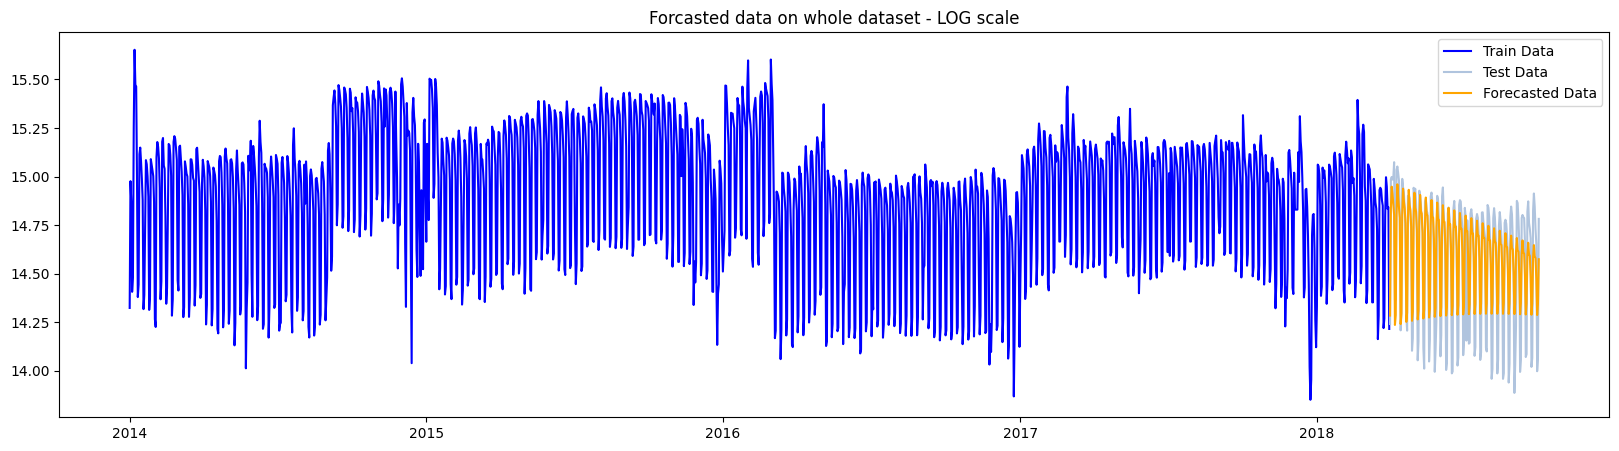

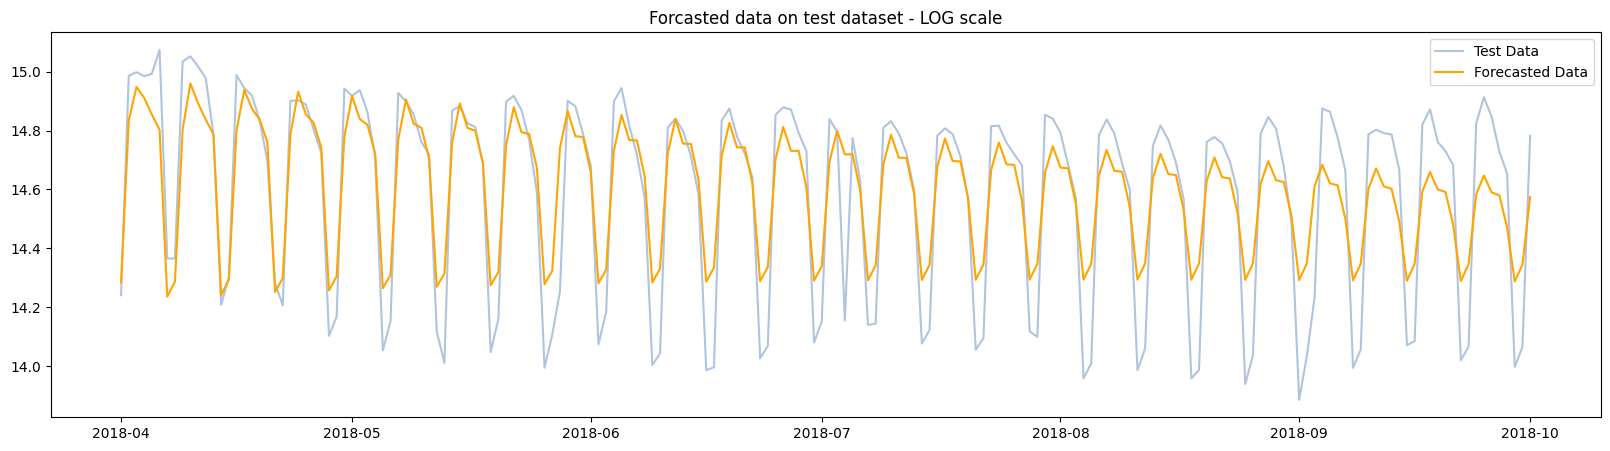

In [14]:
# Forcasted data in LOG scale

Train = train_total['Sessions']
Test = test_total['Sessions']
Forecast = results

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset - LOG scale')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset - LOG scale')
plt.legend()
plt.show()

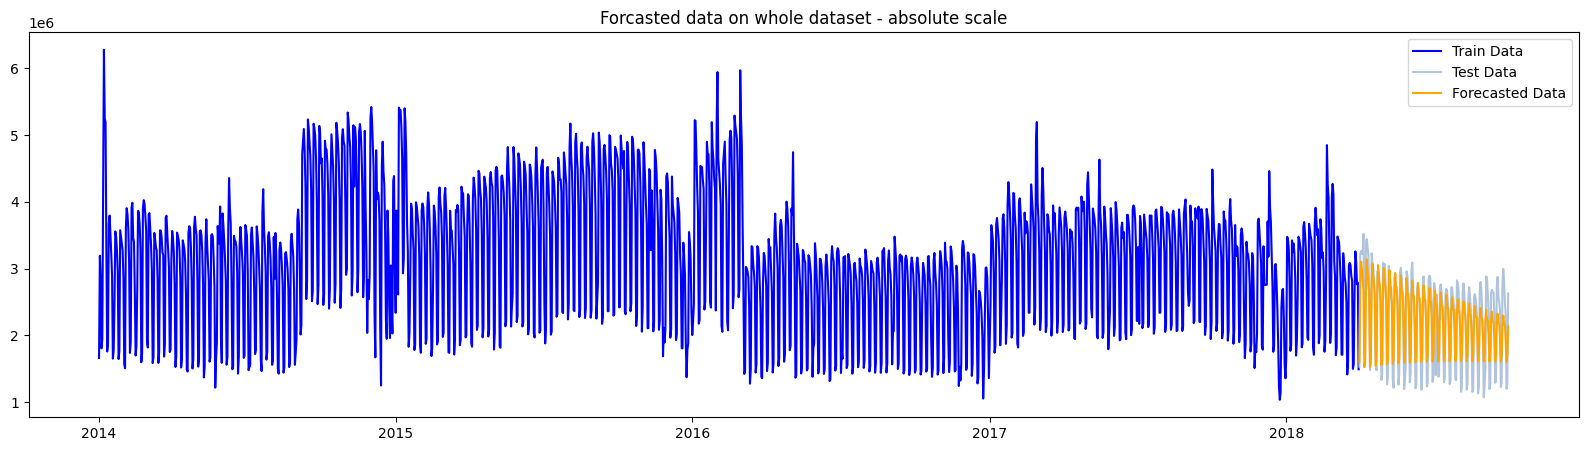

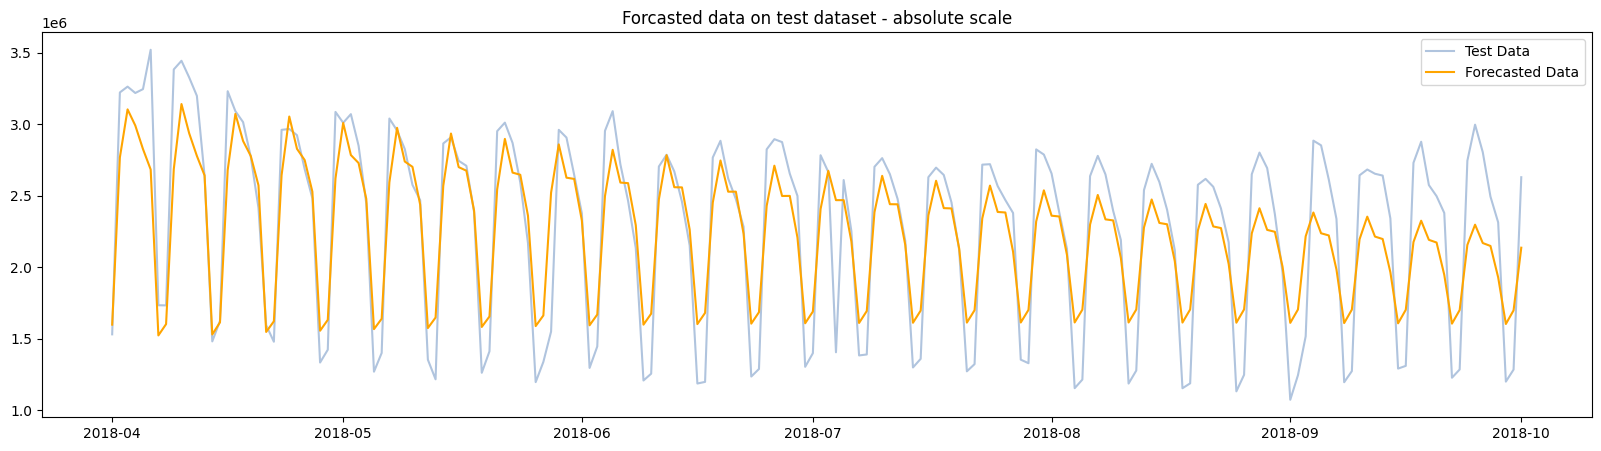

In [15]:
# Forcasted data in absolute scale

Train = np.exp(train_total['Sessions'])
Test = np.exp(test_total['Sessions'])
Forecast = np.exp(results)

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset - absolute scale')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset - absolute scale')
plt.legend()
plt.show()

#
---
## Time Series Forecasting with PROPHET

In [30]:
df_org = pd.read_csv('df_total_final.csv', parse_dates=['Date'])
df = df_org.copy()

In [31]:
df.rename(columns={'Date': 'ds', 'Sessions': 'y'}, inplace=True)

In [32]:
# Train-test split 
train_total = df.loc[df['ds'] <  pd.Timestamp('2018-04-01')]
test_total  = df.loc[df['ds'] >= pd.Timestamp('2018-04-01')]

In [33]:
parameters = {
    'n_changepoints': [5, 6, 7], 
    'changepoint_range': np.arange(0.85, 0.9, 0.001)}

parameter_grid = ParameterGrid(parameters)

best_mape = float('inf')
best_parameters = None

for param_set in parameter_grid:
    n_changepoints = param_set['n_changepoints']
    changepoint_range = param_set['changepoint_range']
    
    model = prophet.Prophet(
        growth='linear',
        changepoints=None,
        n_changepoints=n_changepoints,
        changepoint_range=changepoint_range,
        yearly_seasonality='auto',
        weekly_seasonality='auto',
        daily_seasonality='auto',
        holidays=None
    )
    
    model.fit(train_total)
    
    future = model.make_future_dataframe(periods=test_total.shape[0], freq='D')
    results = model.predict(future)
    
    mape = mean_absolute_percentage_error(test_total['y'], results['yhat'][-len(test_total['y']):])
    
    print(f'MAPE = {round(mape*100, 2)}% - n_changepoints = {n_changepoints}, changepoint_range = {changepoint_range}')
    
    if mape < best_mape:
        best_mape = mape
        best_parameters = param_set

print(f'Best parameters: {best_parameters}, MAPE = {round(best_mape*100, 2)}%')


08:48:19 - cmdstanpy - INFO - Chain [1] start processing
08:48:19 - cmdstanpy - INFO - Chain [1] done processing
08:48:20 - cmdstanpy - INFO - Chain [1] start processing
08:48:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.94% - n_changepoints = 5, changepoint_range = 0.85


08:48:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.65% - n_changepoints = 6, changepoint_range = 0.85


08:48:20 - cmdstanpy - INFO - Chain [1] done processing
08:48:20 - cmdstanpy - INFO - Chain [1] start processing
08:48:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.77% - n_changepoints = 7, changepoint_range = 0.85


08:48:21 - cmdstanpy - INFO - Chain [1] start processing
08:48:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.95% - n_changepoints = 5, changepoint_range = 0.851


08:48:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.64% - n_changepoints = 6, changepoint_range = 0.851


08:48:21 - cmdstanpy - INFO - Chain [1] done processing
08:48:22 - cmdstanpy - INFO - Chain [1] start processing
08:48:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.75% - n_changepoints = 7, changepoint_range = 0.851


08:48:22 - cmdstanpy - INFO - Chain [1] start processing
08:48:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.96% - n_changepoints = 5, changepoint_range = 0.852


08:48:22 - cmdstanpy - INFO - Chain [1] start processing
08:48:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.62% - n_changepoints = 6, changepoint_range = 0.852


08:48:23 - cmdstanpy - INFO - Chain [1] start processing
08:48:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.73% - n_changepoints = 7, changepoint_range = 0.852


08:48:23 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.98% - n_changepoints = 5, changepoint_range = 0.853


08:48:23 - cmdstanpy - INFO - Chain [1] done processing
08:48:24 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.62% - n_changepoints = 6, changepoint_range = 0.853


08:48:24 - cmdstanpy - INFO - Chain [1] done processing
08:48:24 - cmdstanpy - INFO - Chain [1] start processing
08:48:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.72% - n_changepoints = 7, changepoint_range = 0.853


08:48:25 - cmdstanpy - INFO - Chain [1] start processing
08:48:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.97% - n_changepoints = 5, changepoint_range = 0.854


08:48:25 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.6% - n_changepoints = 6, changepoint_range = 0.854


08:48:25 - cmdstanpy - INFO - Chain [1] done processing
08:48:25 - cmdstanpy - INFO - Chain [1] start processing
08:48:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.7% - n_changepoints = 7, changepoint_range = 0.854


08:48:26 - cmdstanpy - INFO - Chain [1] start processing
08:48:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.99% - n_changepoints = 5, changepoint_range = 0.855


08:48:26 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.59% - n_changepoints = 6, changepoint_range = 0.855


08:48:26 - cmdstanpy - INFO - Chain [1] done processing
08:48:27 - cmdstanpy - INFO - Chain [1] start processing
08:48:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.67% - n_changepoints = 7, changepoint_range = 0.855


08:48:27 - cmdstanpy - INFO - Chain [1] start processing
08:48:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.0% - n_changepoints = 5, changepoint_range = 0.856


08:48:28 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.59% - n_changepoints = 6, changepoint_range = 0.856


08:48:28 - cmdstanpy - INFO - Chain [1] done processing
08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.83% - n_changepoints = 7, changepoint_range = 0.856


08:48:29 - cmdstanpy - INFO - Chain [1] start processing
08:48:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.0% - n_changepoints = 5, changepoint_range = 0.857


08:48:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.57% - n_changepoints = 6, changepoint_range = 0.857


08:48:29 - cmdstanpy - INFO - Chain [1] done processing
08:48:30 - cmdstanpy - INFO - Chain [1] start processing
08:48:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.72% - n_changepoints = 7, changepoint_range = 0.857


08:48:30 - cmdstanpy - INFO - Chain [1] start processing
08:48:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.0% - n_changepoints = 5, changepoint_range = 0.858


08:48:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.57% - n_changepoints = 6, changepoint_range = 0.858


08:48:31 - cmdstanpy - INFO - Chain [1] done processing
08:48:31 - cmdstanpy - INFO - Chain [1] start processing
08:48:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.82% - n_changepoints = 7, changepoint_range = 0.858


08:48:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 1.04% - n_changepoints = 5, changepoint_range = 0.859


08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.55% - n_changepoints = 6, changepoint_range = 0.859


08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:32 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.93% - n_changepoints = 7, changepoint_range = 0.859


08:48:33 - cmdstanpy - INFO - Chain [1] start processing
08:48:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.01% - n_changepoints = 5, changepoint_range = 0.86


08:48:33 - cmdstanpy - INFO - Chain [1] start processing
08:48:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.55% - n_changepoints = 6, changepoint_range = 0.86


08:48:34 - cmdstanpy - INFO - Chain [1] start processing
08:48:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.88% - n_changepoints = 7, changepoint_range = 0.86


08:48:34 - cmdstanpy - INFO - Chain [1] start processing
08:48:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.02% - n_changepoints = 5, changepoint_range = 0.861


08:48:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.54% - n_changepoints = 6, changepoint_range = 0.861


08:48:34 - cmdstanpy - INFO - Chain [1] done processing
08:48:35 - cmdstanpy - INFO - Chain [1] start processing
08:48:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.83% - n_changepoints = 7, changepoint_range = 0.861


08:48:35 - cmdstanpy - INFO - Chain [1] start processing
08:48:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.02% - n_changepoints = 5, changepoint_range = 0.862


08:48:35 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.53% - n_changepoints = 6, changepoint_range = 0.862


08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.0% - n_changepoints = 7, changepoint_range = 0.862


08:48:36 - cmdstanpy - INFO - Chain [1] start processing
08:48:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.03% - n_changepoints = 5, changepoint_range = 0.863


08:48:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.52% - n_changepoints = 6, changepoint_range = 0.863


08:48:37 - cmdstanpy - INFO - Chain [1] done processing
08:48:37 - cmdstanpy - INFO - Chain [1] start processing
08:48:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.98% - n_changepoints = 7, changepoint_range = 0.863


08:48:37 - cmdstanpy - INFO - Chain [1] start processing
08:48:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.04% - n_changepoints = 5, changepoint_range = 0.864


08:48:38 - cmdstanpy - INFO - Chain [1] start processing
08:48:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.5% - n_changepoints = 6, changepoint_range = 0.864


08:48:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 2.04% - n_changepoints = 7, changepoint_range = 0.864


08:48:38 - cmdstanpy - INFO - Chain [1] done processing
08:48:38 - cmdstanpy - INFO - Chain [1] start processing
08:48:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.03% - n_changepoints = 5, changepoint_range = 0.865


08:48:39 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.5% - n_changepoints = 6, changepoint_range = 0.865


08:48:39 - cmdstanpy - INFO - Chain [1] done processing
08:48:39 - cmdstanpy - INFO - Chain [1] start processing
08:48:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.97% - n_changepoints = 7, changepoint_range = 0.865


08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.04% - n_changepoints = 5, changepoint_range = 0.866


08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.5% - n_changepoints = 6, changepoint_range = 0.866


08:48:41 - cmdstanpy - INFO - Chain [1] start processing
08:48:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.02% - n_changepoints = 7, changepoint_range = 0.866


08:48:41 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 1.03% - n_changepoints = 5, changepoint_range = 0.867


08:48:41 - cmdstanpy - INFO - Chain [1] done processing
08:48:41 - cmdstanpy - INFO - Chain [1] start processing
08:48:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.49% - n_changepoints = 6, changepoint_range = 0.867


08:48:41 - cmdstanpy - INFO - Chain [1] start processing
08:48:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.97% - n_changepoints = 7, changepoint_range = 0.867


08:48:42 - cmdstanpy - INFO - Chain [1] start processing
08:48:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.04% - n_changepoints = 5, changepoint_range = 0.868


08:48:42 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.49% - n_changepoints = 6, changepoint_range = 0.868


08:48:42 - cmdstanpy - INFO - Chain [1] done processing
08:48:43 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 2.17% - n_changepoints = 7, changepoint_range = 0.868


08:48:43 - cmdstanpy - INFO - Chain [1] done processing
08:48:43 - cmdstanpy - INFO - Chain [1] start processing
08:48:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.04% - n_changepoints = 5, changepoint_range = 0.869


08:48:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.49% - n_changepoints = 6, changepoint_range = 0.869


08:48:44 - cmdstanpy - INFO - Chain [1] done processing
08:48:44 - cmdstanpy - INFO - Chain [1] start processing
08:48:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.02% - n_changepoints = 7, changepoint_range = 0.869


08:48:45 - cmdstanpy - INFO - Chain [1] start processing
08:48:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.03% - n_changepoints = 5, changepoint_range = 0.87
MAPE = 0.48% - n_changepoints = 6, changepoint_range = 0.87


08:48:46 - cmdstanpy - INFO - Chain [1] start processing
08:48:46 - cmdstanpy - INFO - Chain [1] done processing
08:48:46 - cmdstanpy - INFO - Chain [1] start processing
08:48:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.17% - n_changepoints = 7, changepoint_range = 0.87


08:48:47 - cmdstanpy - INFO - Chain [1] start processing
08:48:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.03% - n_changepoints = 5, changepoint_range = 0.871


08:48:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.47% - n_changepoints = 6, changepoint_range = 0.871


08:48:47 - cmdstanpy - INFO - Chain [1] done processing
08:48:47 - cmdstanpy - INFO - Chain [1] start processing
08:48:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.17% - n_changepoints = 7, changepoint_range = 0.871


08:48:48 - cmdstanpy - INFO - Chain [1] start processing
08:48:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.02% - n_changepoints = 5, changepoint_range = 0.872


08:48:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.46% - n_changepoints = 6, changepoint_range = 0.872


08:48:48 - cmdstanpy - INFO - Chain [1] done processing
08:48:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 2.28% - n_changepoints = 7, changepoint_range = 0.872


08:48:49 - cmdstanpy - INFO - Chain [1] done processing
08:48:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 1.02% - n_changepoints = 5, changepoint_range = 0.873


08:48:49 - cmdstanpy - INFO - Chain [1] done processing
08:48:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.46% - n_changepoints = 6, changepoint_range = 0.873


08:48:50 - cmdstanpy - INFO - Chain [1] done processing
08:48:50 - cmdstanpy - INFO - Chain [1] start processing
08:48:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.18% - n_changepoints = 7, changepoint_range = 0.873


08:48:50 - cmdstanpy - INFO - Chain [1] start processing
08:48:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.02% - n_changepoints = 5, changepoint_range = 0.874


08:48:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.45% - n_changepoints = 6, changepoint_range = 0.874


08:48:51 - cmdstanpy - INFO - Chain [1] done processing
08:48:51 - cmdstanpy - INFO - Chain [1] start processing
08:48:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.25% - n_changepoints = 7, changepoint_range = 0.874


08:48:52 - cmdstanpy - INFO - Chain [1] start processing
08:48:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.01% - n_changepoints = 5, changepoint_range = 0.875


08:48:52 - cmdstanpy - INFO - Chain [1] start processing
08:48:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.45% - n_changepoints = 6, changepoint_range = 0.875


08:48:52 - cmdstanpy - INFO - Chain [1] start processing
08:48:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.21% - n_changepoints = 7, changepoint_range = 0.875


08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.03% - n_changepoints = 5, changepoint_range = 0.876


08:48:53 - cmdstanpy - INFO - Chain [1] start processing
08:48:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.45% - n_changepoints = 6, changepoint_range = 0.876


08:48:54 - cmdstanpy - INFO - Chain [1] start processing
08:48:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.17% - n_changepoints = 7, changepoint_range = 0.876


08:48:54 - cmdstanpy - INFO - Chain [1] start processing
08:48:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.01% - n_changepoints = 5, changepoint_range = 0.877


08:48:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.44% - n_changepoints = 6, changepoint_range = 0.877


08:48:54 - cmdstanpy - INFO - Chain [1] done processing
08:48:55 - cmdstanpy - INFO - Chain [1] start processing
08:48:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.23% - n_changepoints = 7, changepoint_range = 0.877


08:48:55 - cmdstanpy - INFO - Chain [1] start processing
08:48:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.01% - n_changepoints = 5, changepoint_range = 0.878


08:48:56 - cmdstanpy - INFO - Chain [1] start processing
08:48:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.44% - n_changepoints = 6, changepoint_range = 0.878


08:48:56 - cmdstanpy - INFO - Chain [1] start processing
08:48:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.23% - n_changepoints = 7, changepoint_range = 0.878


08:48:57 - cmdstanpy - INFO - Chain [1] start processing
08:48:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 1.0% - n_changepoints = 5, changepoint_range = 0.879


08:48:57 - cmdstanpy - INFO - Chain [1] start processing
08:48:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.45% - n_changepoints = 6, changepoint_range = 0.879


08:48:57 - cmdstanpy - INFO - Chain [1] start processing
08:48:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.16% - n_changepoints = 7, changepoint_range = 0.879


08:48:58 - cmdstanpy - INFO - Chain [1] start processing
08:48:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.99% - n_changepoints = 5, changepoint_range = 0.88


08:48:58 - cmdstanpy - INFO - Chain [1] start processing
08:48:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.45% - n_changepoints = 6, changepoint_range = 0.88


08:48:58 - cmdstanpy - INFO - Chain [1] start processing
08:48:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.25% - n_changepoints = 7, changepoint_range = 0.88


08:48:59 - cmdstanpy - INFO - Chain [1] start processing
08:48:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.99% - n_changepoints = 5, changepoint_range = 0.881


08:48:59 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.46% - n_changepoints = 6, changepoint_range = 0.881


08:48:59 - cmdstanpy - INFO - Chain [1] done processing
08:49:00 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 2.1% - n_changepoints = 7, changepoint_range = 0.881


08:49:00 - cmdstanpy - INFO - Chain [1] done processing
08:49:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.98% - n_changepoints = 5, changepoint_range = 0.882


08:49:01 - cmdstanpy - INFO - Chain [1] done processing
08:49:01 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.46% - n_changepoints = 6, changepoint_range = 0.882


08:49:01 - cmdstanpy - INFO - Chain [1] done processing
08:49:01 - cmdstanpy - INFO - Chain [1] start processing
08:49:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.19% - n_changepoints = 7, changepoint_range = 0.882


08:49:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 1.0% - n_changepoints = 5, changepoint_range = 0.883


08:49:02 - cmdstanpy - INFO - Chain [1] done processing
08:49:02 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.48% - n_changepoints = 6, changepoint_range = 0.883


08:49:02 - cmdstanpy - INFO - Chain [1] done processing
08:49:03 - cmdstanpy - INFO - Chain [1] start processing
08:49:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.21% - n_changepoints = 7, changepoint_range = 0.883


08:49:03 - cmdstanpy - INFO - Chain [1] start processing
08:49:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.98% - n_changepoints = 5, changepoint_range = 0.884


08:49:04 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.5% - n_changepoints = 6, changepoint_range = 0.884


08:49:04 - cmdstanpy - INFO - Chain [1] done processing
08:49:04 - cmdstanpy - INFO - Chain [1] start processing
08:49:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.19% - n_changepoints = 7, changepoint_range = 0.884


08:49:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.98% - n_changepoints = 5, changepoint_range = 0.885


08:49:05 - cmdstanpy - INFO - Chain [1] done processing
08:49:05 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.51% - n_changepoints = 6, changepoint_range = 0.885


08:49:05 - cmdstanpy - INFO - Chain [1] done processing
08:49:06 - cmdstanpy - INFO - Chain [1] start processing
08:49:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.17% - n_changepoints = 7, changepoint_range = 0.885


08:49:06 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.96% - n_changepoints = 5, changepoint_range = 0.886


08:49:06 - cmdstanpy - INFO - Chain [1] done processing
08:49:07 - cmdstanpy - INFO - Chain [1] start processing
08:49:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.53% - n_changepoints = 6, changepoint_range = 0.886


08:49:07 - cmdstanpy - INFO - Chain [1] start processing
08:49:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.2% - n_changepoints = 7, changepoint_range = 0.886


08:49:07 - cmdstanpy - INFO - Chain [1] start processing
08:49:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.95% - n_changepoints = 5, changepoint_range = 0.887


08:49:08 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.54% - n_changepoints = 6, changepoint_range = 0.887


08:49:08 - cmdstanpy - INFO - Chain [1] done processing
08:49:08 - cmdstanpy - INFO - Chain [1] start processing
08:49:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.21% - n_changepoints = 7, changepoint_range = 0.887


08:49:08 - cmdstanpy - INFO - Chain [1] start processing
08:49:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.94% - n_changepoints = 5, changepoint_range = 0.888


08:49:09 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.58% - n_changepoints = 6, changepoint_range = 0.888


08:49:09 - cmdstanpy - INFO - Chain [1] done processing
08:49:09 - cmdstanpy - INFO - Chain [1] start processing
08:49:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.2% - n_changepoints = 7, changepoint_range = 0.888


08:49:10 - cmdstanpy - INFO - Chain [1] start processing
08:49:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.94% - n_changepoints = 5, changepoint_range = 0.889


08:49:10 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.59% - n_changepoints = 6, changepoint_range = 0.889


08:49:10 - cmdstanpy - INFO - Chain [1] done processing
08:49:11 - cmdstanpy - INFO - Chain [1] start processing
08:49:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.21% - n_changepoints = 7, changepoint_range = 0.889


08:49:11 - cmdstanpy - INFO - Chain [1] start processing
08:49:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.94% - n_changepoints = 5, changepoint_range = 0.89


08:49:11 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.62% - n_changepoints = 6, changepoint_range = 0.89


08:49:12 - cmdstanpy - INFO - Chain [1] done processing
08:49:12 - cmdstanpy - INFO - Chain [1] start processing
08:49:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.25% - n_changepoints = 7, changepoint_range = 0.89


08:49:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.91% - n_changepoints = 5, changepoint_range = 0.891


08:49:12 - cmdstanpy - INFO - Chain [1] done processing
08:49:13 - cmdstanpy - INFO - Chain [1] start processing
08:49:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.63% - n_changepoints = 6, changepoint_range = 0.891


08:49:13 - cmdstanpy - INFO - Chain [1] start processing
08:49:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.25% - n_changepoints = 7, changepoint_range = 0.891


08:49:14 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.91% - n_changepoints = 5, changepoint_range = 0.892


08:49:14 - cmdstanpy - INFO - Chain [1] done processing
08:49:14 - cmdstanpy - INFO - Chain [1] start processing
08:49:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.68% - n_changepoints = 6, changepoint_range = 0.892


08:49:15 - cmdstanpy - INFO - Chain [1] start processing
08:49:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.28% - n_changepoints = 7, changepoint_range = 0.892


08:49:15 - cmdstanpy - INFO - Chain [1] start processing
08:49:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.91% - n_changepoints = 5, changepoint_range = 0.893


08:49:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.72% - n_changepoints = 6, changepoint_range = 0.893


08:49:15 - cmdstanpy - INFO - Chain [1] done processing
08:49:16 - cmdstanpy - INFO - Chain [1] start processing
08:49:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.3% - n_changepoints = 7, changepoint_range = 0.893


08:49:16 - cmdstanpy - INFO - Chain [1] start processing
08:49:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.87% - n_changepoints = 5, changepoint_range = 0.894


08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.73% - n_changepoints = 6, changepoint_range = 0.894


08:49:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 2.34% - n_changepoints = 7, changepoint_range = 0.894


08:49:17 - cmdstanpy - INFO - Chain [1] done processing
08:49:17 - cmdstanpy - INFO - Chain [1] start processing
08:49:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.86% - n_changepoints = 5, changepoint_range = 0.895


08:49:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.81% - n_changepoints = 6, changepoint_range = 0.895


08:49:18 - cmdstanpy - INFO - Chain [1] done processing
08:49:18 - cmdstanpy - INFO - Chain [1] start processing
08:49:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.2% - n_changepoints = 7, changepoint_range = 0.895


08:49:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.86% - n_changepoints = 5, changepoint_range = 0.896


08:49:19 - cmdstanpy - INFO - Chain [1] done processing
08:49:19 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.82% - n_changepoints = 6, changepoint_range = 0.896


08:49:19 - cmdstanpy - INFO - Chain [1] done processing
08:49:20 - cmdstanpy - INFO - Chain [1] start processing
08:49:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.21% - n_changepoints = 7, changepoint_range = 0.896


08:49:20 - cmdstanpy - INFO - Chain [1] start processing
08:49:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.85% - n_changepoints = 5, changepoint_range = 0.897


08:49:20 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.85% - n_changepoints = 6, changepoint_range = 0.897


08:49:20 - cmdstanpy - INFO - Chain [1] done processing
08:49:21 - cmdstanpy - INFO - Chain [1] start processing
08:49:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.13% - n_changepoints = 7, changepoint_range = 0.897


08:49:21 - cmdstanpy - INFO - Chain [1] start processing
08:49:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.83% - n_changepoints = 5, changepoint_range = 0.898


08:49:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE = 0.88% - n_changepoints = 6, changepoint_range = 0.898


08:49:22 - cmdstanpy - INFO - Chain [1] done processing
08:49:22 - cmdstanpy - INFO - Chain [1] start processing
08:49:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.15% - n_changepoints = 7, changepoint_range = 0.898


08:49:22 - cmdstanpy - INFO - Chain [1] start processing
08:49:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.84% - n_changepoints = 5, changepoint_range = 0.899


08:49:23 - cmdstanpy - INFO - Chain [1] start processing
08:49:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.93% - n_changepoints = 6, changepoint_range = 0.899


08:49:23 - cmdstanpy - INFO - Chain [1] start processing
08:49:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 2.08% - n_changepoints = 7, changepoint_range = 0.899


08:49:23 - cmdstanpy - INFO - Chain [1] start processing
08:49:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.85% - n_changepoints = 5, changepoint_range = 0.9


08:49:24 - cmdstanpy - INFO - Chain [1] start processing
08:49:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 0.96% - n_changepoints = 6, changepoint_range = 0.9
MAPE = 2.07% - n_changepoints = 7, changepoint_range = 0.9
Best parameters: {'changepoint_range': 0.877, 'n_changepoints': 6}, MAPE = 0.44%


In [34]:
model = prophet.Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=best_parameters['n_changepoints'],
    changepoint_range=best_parameters['changepoint_range'],
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None
)

model.fit(train_total)

future = model.make_future_dataframe(periods=test_total.shape[0], freq='D')
results = model.predict(future)

08:49:24 - cmdstanpy - INFO - Chain [1] start processing
08:49:24 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
y_test = test_total['y']
y_pred = results['yhat'][-len(y_test):]

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Preformance metrics for PROPHET model:')
print('--------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))  
print('R2:    ', round(r2*100, 2), '%')
print('MAPE:  ', round(mape*100, 2), '%') 

Preformance metrics for PROPHET model:
--------------------------------------
MAE:    0.06
RMSE:   0.1
R2:     91.11 %
MAPE:   0.44 %


<Figure size 2000x800 with 0 Axes>

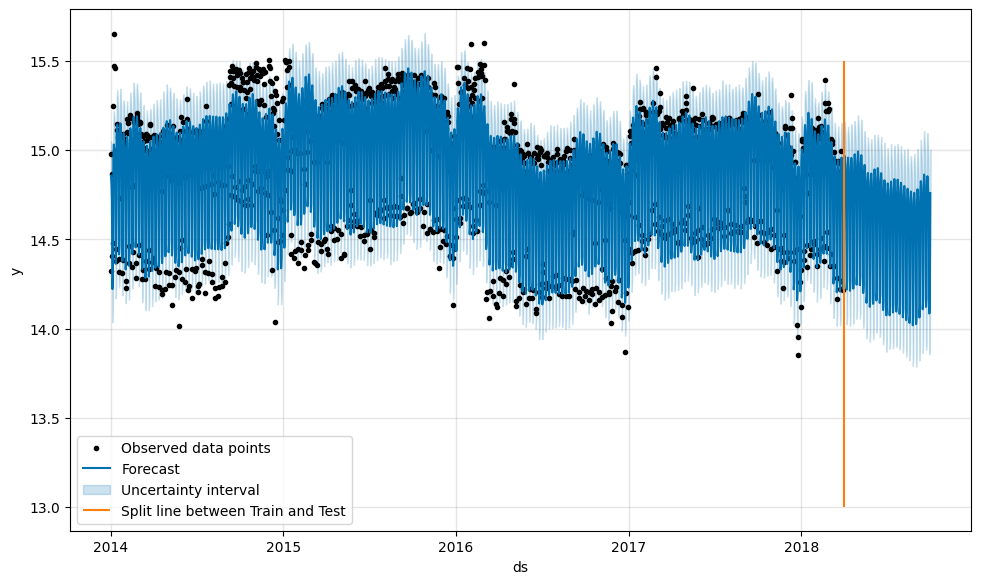

In [36]:
plt.figure(figsize=(20,8))
fig = model.plot(results)
plt.vlines(pd.Timestamp('2018-04-01'), 13, 15.5, color='tab:orange', label='Split line between Train and Test')
plt.legend()
plt.show()

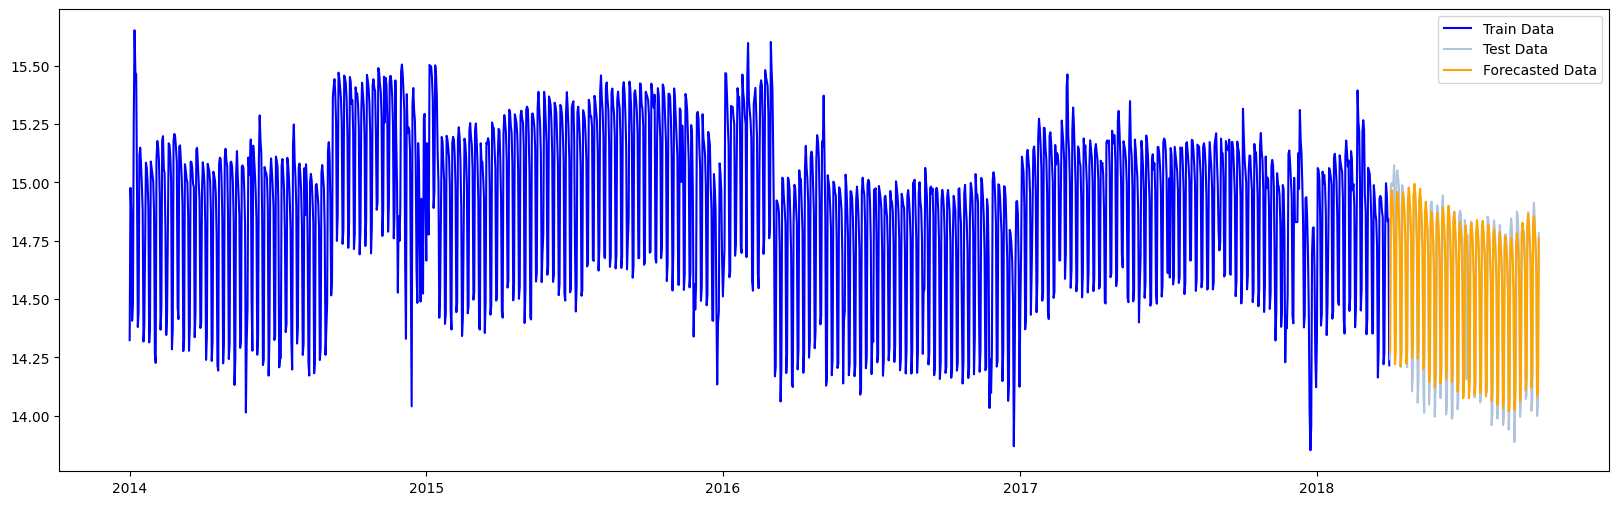

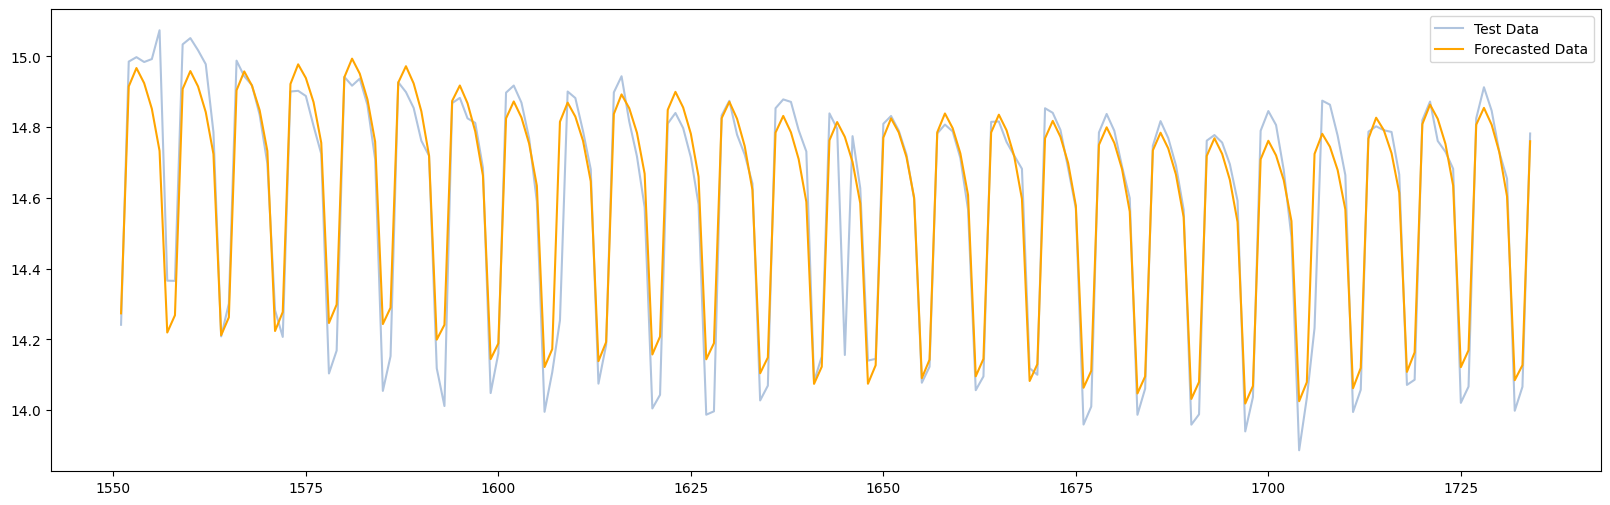

In [42]:
x_train = train_total['ds']
y_train = train_total['y']

x_test = test_total['ds']
y_test = test_total['y']

x_pred = df['ds'][-len(x_test):]
y_pred = results['yhat'][-len(y_test):]

plt.figure(figsize=(20,6))
plt.plot(x_train, y_train, color='blue', label='Train Data')
plt.plot(x_test, y_test, color='lightsteelblue', label='Test Data')
plt.plot(x_pred, y_pred, color='orange', label='Forecasted Data')
plt.legend()
plt.show()

plt.figure(figsize=(20,6))
plt.plot(y_test, color='lightsteelblue', label='Test Data')
plt.plot(y_pred, color='orange', label='Forecasted Data')
plt.legend()
plt.show()